# Insurance Customer Segmentation and Fraud Detection

## Data Scientist: 

### Project overview:

This project examines insurance customer behavior to support both customer segmentation and fraud detection, with the goal of reducing financial risk while improving understanding of policyholder behavior. Rather than optimizing a single model or metric, the focus is on careful exploratory analysis, feature characterization, and evaluating multiple modeling approaches to understand where and why fraudulent claims occur.

The workflow follows an end-to-end data science process, including data validation, exploratory analysis, feature engineering, feature selection, model comparison using scikit-learn pipelines, and post-model error analysis.

### About the data:

This dataset contains vehicle, policy, claim and demographic details for auto insurance customers. It was retrieved from Kaggle and has 15420 records and 33 attributes including:

*  Month: The month in which the insurance claim was made.
*  WeekOfMonth: The week of the month in which the insurance claim was made.
*  DayOfWeek: The day of the week on which the insurance claim was made.
*  Make: The manufacturer of the vehicle involved in the claim.
*  AccidentArea: The area where the accident occurred (e.g., urban, rural).
*  DayOfWeekClaimed: The day of the week on which the insurance claim was processed.
*  MonthClaimed: The month in which the insurance claim was processed.
*  WeekOfMonthClaimed: The week of the month in which the insurance claim was processed.
*  Sex: The gender of the policyholder.
*  MaritalStatus: The material status of the policyholder.
*  Age: The age of the policyholder.
*  Fault: Indicates whether the policyholder was at fault in the accident.
*  PolicyType: The type of insurance policy (e.g., comprehensive, third-party).
*  VehicleCategory: The category of the vehicle (e.g., sedan, SUV).
*  VehiclePrice: The price of vehicle.
*  FraudFound_P: Indicates whether fraud was detected in the insurance claim.
*  PolicyNumber: The unique identifier for the insurance policy.
*  RepNumber: The unique identifier for the insurance representative handling the claim.
*  Deductible: The amount that the policy holder must pay out of pocket before the insurance company pays the remaining costs.
*  DriverRating: The rating of the driver, often based on driving history or other factors.
*  Days_Policy_Accident: The number of days since the policy was issued until the accident occurred.
*  Days_Policy_Claim: The number of days since the policy was issued until the claim was made.
*  PastNumberOfClaims: The number of claims previously made by the policyholder.
*  AgeOfVehicle: The age of the vehicle involved in the claim.
*  AgeOfPolicyHolder: The age of the policyholder.
*  PoliceReportFiled: Indicates whether a police report was filed for the accident.
*  WitnessPresent: Indicates whether a witness was present at the scene of the accident.
*  AgentType: The type of insurance agent handling the policy (e.g., internal, external)
*  NumberOfSuppliments: The number of supplementary documents or claims related to the main claim, categorized into ranges.
*  AddressChange_Claim: Indicates whether the address of the policyholder was changed at the time of the claim, categorized into ranges.
*  NumberOfCars: The number of cars insured under the policy, categorized into ranges.
*  Year: The year in which the claim was made or processed.
*  BasePolicy: The base policy type (e.g., Liability, Collision, All Perils).


FraudFound_P is the target.

### Install packages

In [80]:
%pip install imbalanced-learn xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.6/72.0 MB 10.5 MB/s eta 0:00:07
   -- ------------------------------------- 3.9/72.0 MB 10.3 MB/s eta 0:00:07
   --- ------------------------------------ 5.8/72.0 MB 9.9 MB/s eta 0:00:07
   ---- ----------------------------------- 7.9/72.0 MB 9.7 MB/s eta 0:00:07
   ----- ---------------------------------- 10.0/72.0 MB 9.7 MB/s eta 0:00:07
   ------ --------------------------------- 12.1/72.0 MB 9.9 MB/s eta 0:00:07
   -------- ------------------------------- 14.4/72.0 MB 10.1 MB/s eta 0:00:06
   --------- ------------------------------ 16.8/72.0 MB 10.2 MB/s eta 0:00:06
   ---------- ----------------------------- 18.9/72.0 MB 10.2 MB/s eta 0:00:06
   ----------- ---------------------------- 20.7/72.0 MB 10.1 MB/s eta 0:00:06
   ------------ --------------------------- 22.8/72.0 MB 10.1 MB/s eta 0:00:05
   ------------- -------------------------- 25.2/72.0 MB 10.1 MB/s e


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load libraries:

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


import shutil
from pathlib import Path
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy import sparse
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import silhouette_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_auc_score, average_precision_score, roc_curve, recall_score, accuracy_score, precision_score, f1_score  
from sklearn.pipeline import Pipeline, FunctionTransformer, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

### Load and sanity-check the data:

In [2]:
# load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('data\\fraud_oracle.csv')
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

   PolicyNumber  RepNumber  Deductible  DriverRating Days_Policy_Accident  \
0             1         12         300             1         more than 30   
1             2         15         400             4         more than 30   
2             3          7         400             3         more than 30   
3             4          4         400             2         more than 30   
4             5          3         400             1         more than 30   

  Days_Policy_Claim PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder  \
0      more than 30               none      3 years          26 to 30   
1      more than 30               none      6 years          31 to 35   
2      more than 30                  1      7 years          41 to 50   
3      more than 30                  1  more than 7          51 to 65   
4      more than 30               none      5 years          31 to 35   

  PoliceReportFiled WitnessPresent AgentType NumberOfSuppliments  \
0                No             No  External                none   
1               Yes             No  External                none   
2                No             No  External                none   
3               Yes             No  External         more than 5   
4                No             No  External                none   

  AddressChange_Claim NumberOfCars  Year BasePolicy  
0              1 year       3 to 4  1994  Liability  
1           no change    1 vehicle  1994  Collision  
2           no change    1 vehicle  1994  Collision  
3           no change    1 vehicle  1994  Liability  
4           no change    1 vehicle  1994  Collision

In [3]:
# sample a few rows
df.sample(10)

Month  WeekOfMonth  DayOfWeek       Make AccidentArea DayOfWeekClaimed  \
13645   Aug            5    Tuesday     Toyota        Urban          Tuesday   
6953    Mar            1   Saturday      Honda        Urban         Saturday   
11887   Aug            3     Friday  Chevrolet        Urban          Tuesday   
4650    Dec            2     Monday      Mazda        Urban        Wednesday   
5291    Mar            4     Friday      Honda        Urban           Friday   
6559    Jan            2   Thursday      Honda        Urban         Thursday   
4770    Apr            4     Friday      Honda        Urban           Sunday   
7931    Apr            4  Wednesday      Honda        Urban        Wednesday   
3885    Feb            3     Monday  Chevrolet        Urban          Tuesday   
9591    Jul            3   Saturday    Pontiac        Urban          Tuesday   

      MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  Age  \
13645          Sep                   1  Male       Married   54   
6953           Mar                   1  Male       Married   32   
11887          Sep                   1  Male        Single   32   
4650           Dec                   2  Male        Single   26   
5291           Mar                   4  Male       Married   48   
6559           Jan                   2  Male       Married   55   
4770           May                   1  Male       Married   53   
7931           Apr                   4  Male       Married   44   
3885           Feb                   4  Male        Single   34   
9591           Jul                   3  Male       Married   34   

               Fault          PolicyType VehicleCategory    VehiclePrice  \
13645  Policy Holder   Sedan - Collision           Sedan  30000 to 39000   
6953   Policy Holder  Sedan - All Perils           Sedan  20000 to 29000   
11887  Policy Holder   Sedan - Collision           Sedan  20000 to 29000   
4650   Policy Holder   Sedan - Liability           Sport  30000 to 39000   
5291     Third Party   Sedan - Collision           Sedan  20000 to 29000   
6559     Third Party   Sedan - Collision           Sedan  20000 to 29000   
4770   Policy Holder   Sedan - Collision           Sedan  20000 to 29000   
7931   Policy Holder   Sedan - Collision           Sedan  20000 to 29000   
3885   Policy Holder   Sedan - Liability           Sport  20000 to 29000   
9591     Third Party   Sedan - Liability           Sport  20000 to 29000   

       FraudFound_P  PolicyNumber  RepNumber  Deductible  DriverRating  \
13645             0         13646          8         400             4   
6953              0          6954          8         400             1   
11887             0         11888          1         400             1   
4650              0          4651          2         700             3   
5291              0          5292         11         400             3   
6559              0          6560          7         400             4   
4770              0          4771         11         400             3   
7931              0          7932          2         400             3   
3885              0          3886          2         400             4   
9591              0          9592          4         400             1   

      Days_Policy_Accident Days_Policy_Claim PastNumberOfClaims AgeOfVehicle  \
13645         more than 30      more than 30               none  more than 7   
6953          more than 30      more than 30                  1      7 years   
11887         more than 30      more than 30        more than 4      6 years   
4650          more than 30      more than 30        more than 4      7 years   
5291          more than 30      more than 30             2 to 4  more than 7   
6559          more than 30      more than 30             2 to 4  more than 7   
4770          more than 30      more than 30             2 to 4  more than 7   
7931          more than 30      more than 30             2 to 4  more than 7   
3885          m

In [4]:
# review the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [5]:
# get names of columns
df.columns.tolist()

['Month',
 'WeekOfMonth',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'WeekOfMonthClaimed',
 'Sex',
 'MaritalStatus',
 'Age',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'FraudFound_P',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'Year',
 'BasePolicy']

Descriptive (numerical) considerations and insights:

*  Data doesn't appear to have any extreme values, so outlier removal techniques won't be necessary
*  Average driver age is ~ 39.9 years, which includes those under the age of 18
*  Average deductible is ~ $407.70
*  Average driver rating is ~ 2.5, on a 1-4 scale
*  Most claims were made or processed in 1994
*  Fraud only occurs in a very, very small number of claims, as one would expect

In [6]:
# descriptive stats for numerical features
df.describe().T.round(3)

count      mean       std     min      25%     50%  \
WeekOfMonth         15420.0     2.789     1.288     1.0     2.00     3.0   
WeekOfMonthClaimed  15420.0     2.694     1.259     1.0     2.00     3.0   
Age                 15420.0    39.856    13.492     0.0    31.00    38.0   
FraudFound_P        15420.0     0.060     0.237     0.0     0.00     0.0   
PolicyNumber        15420.0  7710.500  4451.515     1.0  3855.75  7710.5   
RepNumber           15420.0     8.483     4.600     1.0     5.00     8.0   
Deductible          15420.0   407.704    43.951   300.0   400.00   400.0   
DriverRating        15420.0     2.488     1.119     1.0     1.00     2.0   
Year                15420.0  1994.866     0.803  1994.0  1994.00  1995.0   

                         75%      max  
WeekOfMonth             4.00      5.0  
WeekOfMonthClaimed      4.00      5.0  
Age                    48.00     80.0  
FraudFound_P            0.00      1.0  
PolicyNumber        11565.25  15420.0  
RepNumber              12.00     16.0  
Deductible            400.00    700.0  
DriverRating            3.00      4.0  
Year                 1996.00   1996.0

Descriptive (categorical) considerations and insights:

*  Will need to review DayOfWeekClaimed and MonthClaimed, as the number of unique values exceed expectation (based on number of calendar days and months)
*  When looking at categories with large (instead of marginal) majorities, most claims:
    *  occur on Monday
    *  occur in urban areas
    *  involve married men who are at fault and have multiple previous claims
    *  involve lower priced sedans that are 7 years old, with collision policies
    *  did not have a witness present or have a police report filed
    *  occur at least a month after the policy was issued

In [7]:
# descriptive stats for categorical features
df.describe(include="object").T

count unique                top   freq
Month                 15420     12                Jan   1411
DayOfWeek             15420      7             Monday   2616
Make                  15420     19            Pontiac   3837
AccidentArea          15420      2              Urban  13822
DayOfWeekClaimed      15420      8             Monday   3757
MonthClaimed          15420     13                Jan   1446
Sex                   15420      2               Male  13000
MaritalStatus         15420      4            Married  10625
Fault                 15420      2      Policy Holder  11230
PolicyType            15420      9  Sedan - Collision   5584
VehicleCategory       15420      3              Sedan   9671
VehiclePrice          15420      6     20000 to 29000   8079
Days_Policy_Accident  15420      5       more than 30  15247
Days_Policy_Claim     15420      4       more than 30  15342
PastNumberOfClaims    15420      4             2 to 4   5485
AgeOfVehicle          15420      8            7 years   5807
AgeOfPolicyHolder     15420      9           31 to 35   5593
PoliceReportFiled     15420      2                 No  14992
WitnessPresent        15420      2                 No  15333
AgentType             15420      2           External  15179
NumberOfSuppliments   15420      4               none   7047
AddressChange_Claim   15420      5          no change  14324
NumberOfCars          15420      5          1 vehicle  14316
BasePolicy            15420      3          Collision   5962

In reviewing the DayOfWeekClaimed and MonthClaimed features, '0' values were included which will be removed. All other features appear ok, but will need to have some type conversions.

In [8]:
# list the different categories, to check for typos, casing and unexpected values
for col in df.select_dtypes(include='object'):
    print(f'{col}: {sorted(df[col].unique())}\n')

Month: ['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

DayOfWeek: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Make: ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW']

AccidentArea: ['Rural', 'Urban']

DayOfWeekClaimed: ['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

MonthClaimed: ['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Sex: ['Female', 'Male']

MaritalStatus: ['Divorced', 'Married', 'Single', 'Widow']

Fault: ['Policy Holder', 'Third Party']

PolicyType: ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability', 'Sport - All Perils', 'Sport - Collision', 'Sport - Liability', 'Utility - All Perils', 'Utility - Collision', 'Utility - Liability']

VehicleCategory: ['Sedan', 'Sport', 'Utility']


Data doesn't have any missing values.

In [9]:
# check for na values
df.isna().sum().sort_values(ascending=False)

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

Data doesn't have any duplicate rows.

In [10]:
# check for dups
df.duplicated().sum()

np.int64(0)

### Data cleaning:

A few different updates need to be made before starting EDA, including:

*  dropping unique identifiers
*  dropping '0' values from the DayOfWeekClaimed and MonthClaimed features
*  type conversions 

In [11]:
# drop unique identifiers ()
df = df.drop(columns=['RepNumber', 'PolicyNumber'])
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

   Deductible  DriverRating Days_Policy_Accident Days_Policy_Claim  \
0         300             1         more than 30      more than 30   
1         400             4         more than 30      more than 30   
2         400             3         more than 30      more than 30   
3         400             2         more than 30      more than 30   
4         400             1         more than 30      more than 30   

  PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder PoliceReportFiled  \
0               none      3 years          26 to 30                No   
1               none      6 years          31 to 35               Yes   
2                  1      7 years          41 to 50                No   
3                  1  more than 7          51 to 65               Yes   
4               none      5 years          31 to 35                No   

  WitnessPresent AgentType NumberOfSuppliments AddressChange_Claim  \
0             No  External                none              1 year   
1             No  External                none           no change   
2             No  External                none           no change   
3             No  External         more than 5           no change   
4             No  External                none           no change   

  NumberOfCars  Year BasePolicy  
0       3 to 4  1994  Liability  
1    1 vehicle  1994  Collision  
2    1 vehicle  1994  Collision  
3    1 vehicle  1994  Liability  
4    1 vehicle  1994  Collision

In [12]:
# drop '0' values from DayOfWeekClaimed and MonthClaimed features
df = df[(df['DayOfWeekClaimed'] != '0') & (df['MonthClaimed'] != '0')]  
zero = df[(df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0')]    
print(zero.shape)

(0, 31)


In [13]:
# seperate categorical features
ordinal_cols = [
    "VehiclePrice",
    "Days_Policy_Accident",
    "Days_Policy_Claim",
    "PastNumberOfClaims",
    "AgeOfVehicle",
    "AgeOfPolicyHolder",
    "NumberOfSuppliments",
    "AddressChange_Claim",
    "NumberOfCars",
    "DriverRating",
    "Deductible",
    "Year",
    "WeekOfMonth",
    "WeekOfMonthClaimed"
]

nominal_cols = [
    "Make",
    "AccidentArea",
    "Sex",
    "MaritalStatus",
    "Fault",
    "PolicyType",
    "VehicleCategory",
    "PoliceReportFiled",
    "WitnessPresent",
    "AgentType",
    "BasePolicy"
]

cyclic_cols = [
    "Month",
    "MonthClaimed",
    "DayOfWeek",
    "DayOfWeekClaimed"
]

In [14]:
# convert nominal data to category dtype
for col in nominal_cols:
    df[col] = df[col].astype('category')
df[nominal_cols].dtypes

Make                 category
AccidentArea         category
Sex                  category
MaritalStatus        category
Fault                category
PolicyType           category
VehicleCategory      category
PoliceReportFiled    category
WitnessPresent       category
AgentType            category
BasePolicy           category
dtype: object

In [15]:
# create ordering dictionary for ordinal features
ordinal_order_map = {
    "VehiclePrice": ["less than 20000", "20000 to 29000", "30000 to 39000", "40000 to 59000", "60000 to 69000", "more than 69000"],
    "Days_Policy_Accident": ["none", "1 to 7", "8 to 15", "15 to 30", "more than 30"],
    "Days_Policy_Claim": ["none", "8 to 15", "15 to 30", "more than 30"],
    "PastNumberOfClaims": ["none", "1", "2 to 4", "more than 4"],
    "AgeOfVehicle": ["new", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "more than 7"],
    "AgeOfPolicyHolder": ["16 to 17", "18 to 20", "21 to 25", "26 to 30", "31 to 35", "36 to 40", "41 to 50", "51 to 65", "over 65"],
    "NumberOfSuppliments": ["none", "1 to 2", "3 to 5", "more than 5"],
    "AddressChange_Claim": ["no change", "under 6 months", "1 year", "2 to 3 years", "4 to 8 years"],
    "NumberOfCars": ["1 vehicle", "2 vehicles", "3 to 4", "5 to 8", "more than 8"],
    "DriverRating" : [1, 2, 3, 4],
    "Deductible" : [300, 400, 500, 700],
    "Year": [1994, 1995, 1996],
    "WeekOfMonth": [1, 2, 3, 4, 5],
    "WeekOfMonthClaimed": [1, 2, 3, 4, 5]
}

In [16]:
# apply ordering
for col, order in ordinal_order_map.items():
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)

df['Year'].cat.categories

Index([1994, 1995, 1996], dtype='int64')

In [17]:
# create ordering for cyclic features
month_order = ["Jan","Feb","Mar","Apr","May","Jun", "Jul","Aug","Sep","Oct","Nov","Dec"]
dow_order = ["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]

In [18]:
# apply ordering
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
df["MonthClaimed"] = pd.Categorical(df["MonthClaimed"], categories=month_order, ordered=True)
df["DayOfWeek"] = pd.Categorical(df["DayOfWeek"], categories=dow_order, ordered=True)
df["DayOfWeekClaimed"] = pd.Categorical(df["DayOfWeekClaimed"], categories=dow_order, ordered=True)

Now that the data has been cleaned, we'll do a quick review of proportions to identify rare types prior to EDA.

In [20]:
# calculate category proportions to identify most common and most rare categories
for c in nominal_cols:
    display((df[c].value_counts(normalize=True) * 100).round(3).head(10))

Make
Pontiac      24.885
Toyota       20.241
Honda        18.159
Mazda        15.267
Chevrolet    10.902
Accura        3.061
Ford          2.918
VW            1.835
Dodge         0.707
Saab          0.700
Name: proportion, dtype: float64

AccidentArea
Urban    89.643
Rural    10.357
Name: proportion, dtype: float64

Sex
Male      84.305
Female    15.695
Name: proportion, dtype: float64

MaritalStatus
Married     68.908
Single      30.372
Divorced     0.493
Widow        0.227
Name: proportion, dtype: float64

Fault
Policy Holder    72.826
Third Party      27.174
Name: proportion, dtype: float64

PolicyType
Sedan - Collision       36.215
Sedan - Liability       32.343
Sedan - All Perils      26.500
Sport - Collision        2.257
Utility - All Perils     2.205
Utility - Collision      0.195
Sport - All Perils       0.143
Utility - Liability      0.136
Sport - Liability        0.006
Name: proportion, dtype: float64

VehicleCategory
Sedan      62.715
Sport      34.749
Utility     2.536
Name: proportion, dtype: float64

PoliceReportFiled
No     97.224
Yes     2.776
Name: proportion, dtype: float64

WitnessPresent
No     99.436
Yes     0.564
Name: proportion, dtype: float64

AgentType
External    98.437
Internal     1.563
Name: proportion, dtype: float64

BasePolicy
Collision     38.667
Liability     32.486
All Perils    28.848
Name: proportion, dtype: float64

In [21]:
# calculate category proportions to identify most common and most rare categories
for c in ordinal_cols:
    display((df[c].value_counts(normalize=True) * 100).round(3).head(10))

VehiclePrice
20000 to 29000     52.396
30000 to 39000     22.913
more than 69000    14.028
less than 20000     7.108
40000 to 59000      2.990
60000 to 69000      0.564
Name: proportion, dtype: float64

Days_Policy_Accident
more than 30    98.878
none             0.357
8 to 15          0.357
15 to 30         0.318
1 to 7           0.091
Name: proportion, dtype: float64

Days_Policy_Claim
more than 30    99.501
15 to 30         0.363
8 to 15          0.136
none             0.000
Name: proportion, dtype: float64

PastNumberOfClaims
2 to 4         35.573
none           28.218
1              23.173
more than 4    13.036
Name: proportion, dtype: float64

AgeOfVehicle
7 years        37.661
more than 7    25.819
6 years        22.362
5 years         8.801
new             2.413
4 years         1.485
3 years         0.986
2 years         0.473
Name: proportion, dtype: float64

AgeOfPolicyHolder
31 to 35    36.273
36 to 40    26.221
41 to 50    18.341
51 to 65     9.028
26 to 30     3.976
over 65      3.295
16 to 17     2.069
21 to 25     0.700
18 to 20     0.097
Name: proportion, dtype: float64

NumberOfSuppliments
none           45.697
more than 5    25.079
1 to 2         16.142
3 to 5         13.081
Name: proportion, dtype: float64

AddressChange_Claim
no change         92.892
4 to 8 years       4.092
2 to 3 years       1.887
1 year             1.103
under 6 months     0.026
Name: proportion, dtype: float64

NumberOfCars
1 vehicle      92.840
2 vehicles      4.598
3 to 4          2.413
5 to 8          0.136
more than 8     0.013
Name: proportion, dtype: float64

DriverRating
1    25.579
3    25.190
2    24.645
4    24.587
Name: proportion, dtype: float64

Deductible
400    96.225
700     2.017
500     1.706
300     0.052
Name: proportion, dtype: float64

Year
1994    39.827
1995    33.692
1996    26.480
Name: proportion, dtype: float64

WeekOfMonth
3    23.607
2    23.069
4    22.038
1    20.669
5    10.617
Name: proportion, dtype: float64

WeekOfMonthClaimed
2    24.126
3    23.238
1    22.369
4    22.265
5     8.003
Name: proportion, dtype: float64

In [22]:
# calculate category proportions to identify most common and most rare categories
for c in cyclic_cols:
    display((df[c].value_counts(normalize=True) * 100).round(3).head(10))

Month
Jan    9.151
May    8.866
Mar    8.820
Jun    8.567
Oct    8.464
Dec    8.334
Apr    8.301
Feb    8.211
Jul    8.146
Sep    8.042
Name: proportion, dtype: float64

MonthClaimed
Jan    9.378
May    9.151
Mar    8.742
Oct    8.684
Jun    8.386
Feb    8.347
Nov    8.334
Apr    8.243
Sep    8.055
Jul    7.945
Name: proportion, dtype: float64

DayOfWeek
Monday       16.960
Friday       15.857
Tuesday      14.917
Thursday     14.093
Wednesday    14.002
Saturday     12.854
Sunday       11.317
Name: proportion, dtype: float64

DayOfWeekClaimed
Monday       24.366
Tuesday      21.889
Wednesday    19.139
Thursday     17.251
Friday       16.194
Saturday      0.824
Sunday        0.337
Name: proportion, dtype: float64

Rare types insights:

*  Identifying rare types can be informative in fraud detection tasks.
*  For the nominal data, some of the rarest types include:
    *  Make: VW, Dodge, Saab
    *  MartialStatus: Divorced, Single
    *  PolicyType: Utility - Collision, Sport - All Perils, Utility - Liability, Sport - Liability
    *  VehicleCategory: Utility
    *  PoliceReportFiled: No
    *  WitnessPresent: No
    *  AgentType: Internal
*  For the ordinal data, some of the rarest types include:
    *  VehiclePrice: 40000 to 59000, 60000 to 69000
    *  Days_Policy_Accident: none, 8 to 15, 15 to 30, 1 to 7
    *  Days_Policy_Claimed: 15 to 30, 8 to 15
    *  AgeOfVehicle: 3 years, 2 years
    *  AgeOfPolicyHolder: 21 to 25, 18 to 20
    *  AddressChange_Claim: 2 to 3 years, 1 year, under 6 months
    *  NumberOfCars: 3 to 4, 5 to 8, more than 8
    *  Deductible: 700, 500, 300
*  Most of the cyclic features are relatively stable/uniform, with the exception of DayOfWeekClaimed, which is skewed towards the beginning of the week

## Exploratory Data Analysis:

*  Univariate Analysis

    1. Categorical features: Barplots
    2. Numerical features: Histograms (w/ KDE) 

*  Bivariate Analysis

    1. Categorical vs Target: Heatmap of crosstabs
    2. Numerical vs Target: Violinplots
    3. Behavioral relationships with Target: fraud-rate barplots
    4. Effect size: Lift barplots/lineplots
    5. Association Analysis: Cramer's V/ Spearman correlation barplots

*  Customer segmentation

In [23]:
# group numeric and categorical features
num_features =  'Age'
target = 'FraudFound_P'
cat_features = nominal_cols + ordinal_cols + cyclic_cols + [target]
print(num_features)
print(target)
print(cat_features)

Age
FraudFound_P
['Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'DriverRating', 'Deductible', 'Year', 'WeekOfMonth', 'WeekOfMonthClaimed', 'Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'FraudFound_P']


### Univariate Analysis

1. Categorical features: Barplots
2. Numeric feature: Histograms

In [24]:
# create eda features list
#eda_target = df[target].astype('int64')
eda_features = nominal_cols + ordinal_cols + cyclic_cols + [target]

In [25]:
"""X = pd.DataFrame(index=df.index)"""

'X = pd.DataFrame(index=df.index)'

Barplots for categorical features

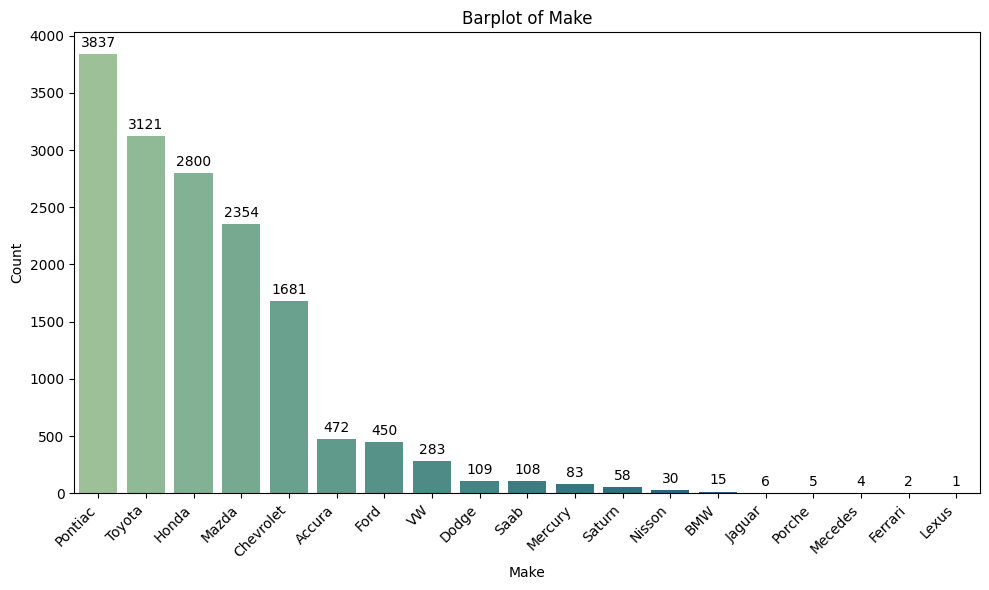

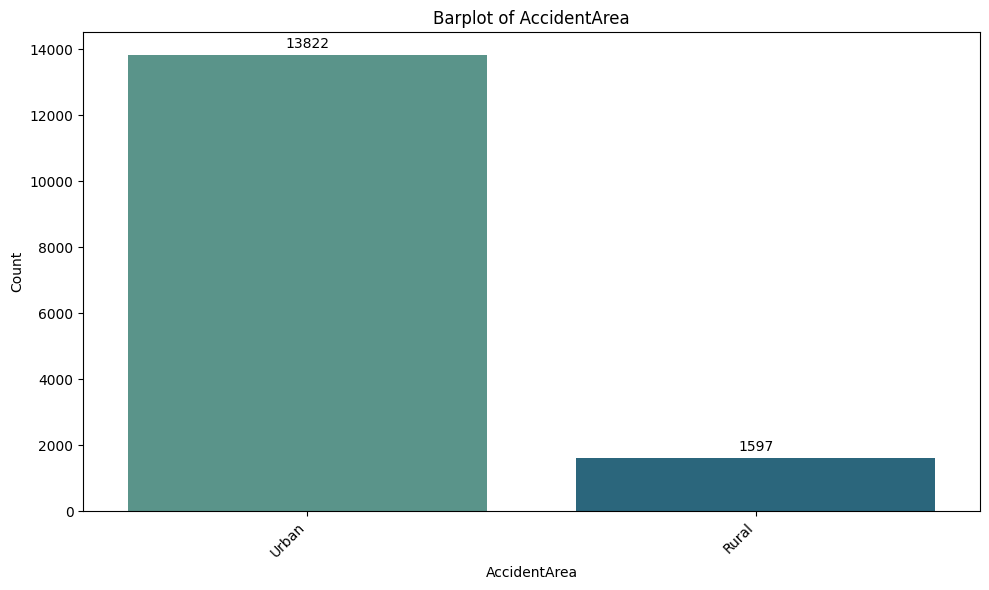

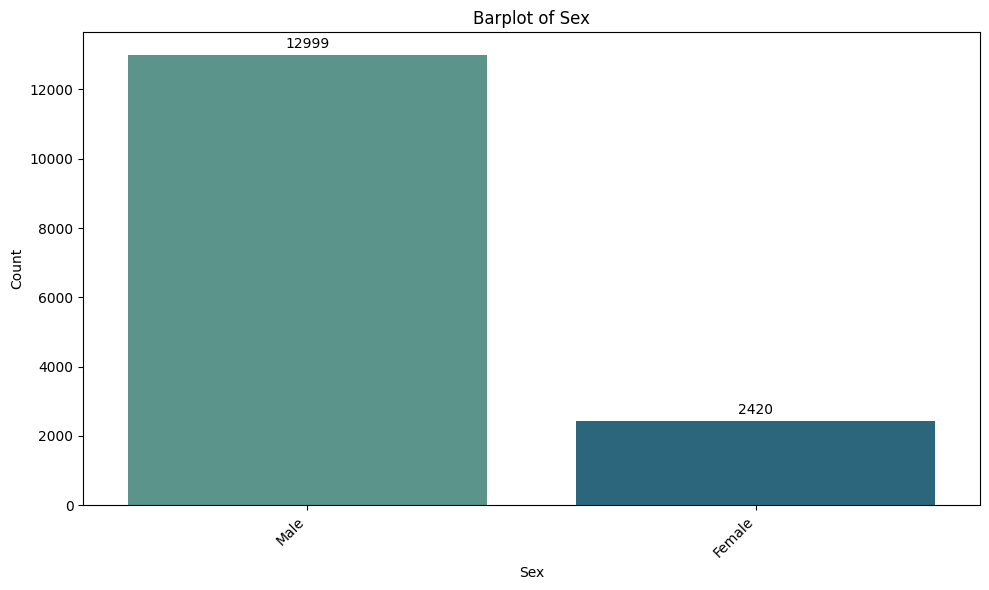

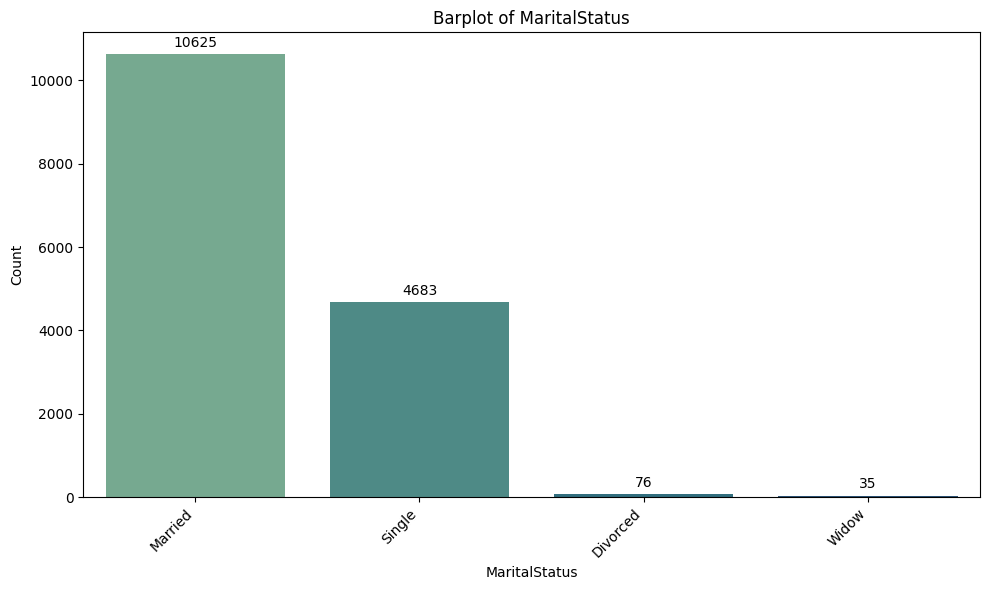

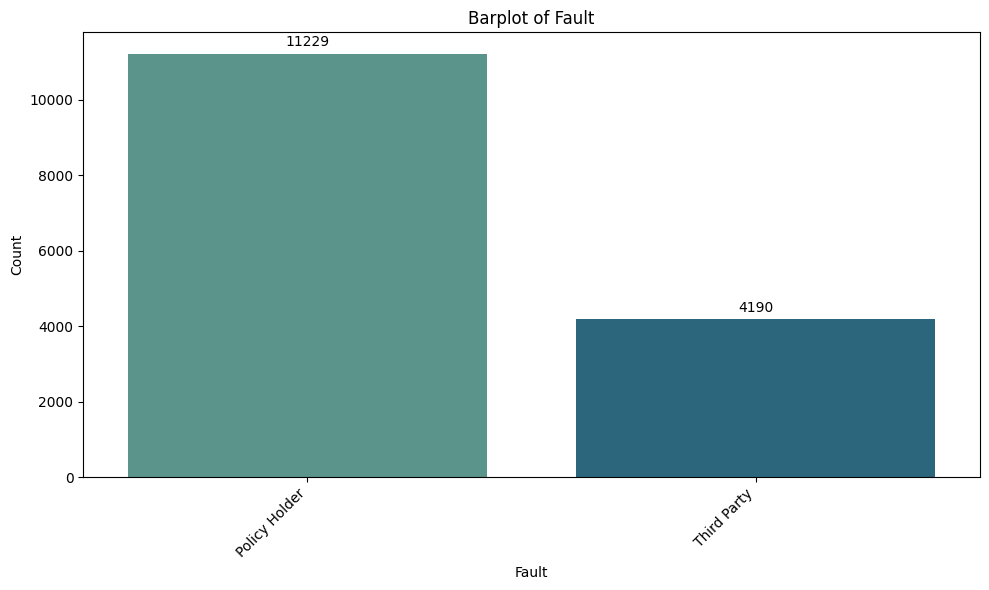

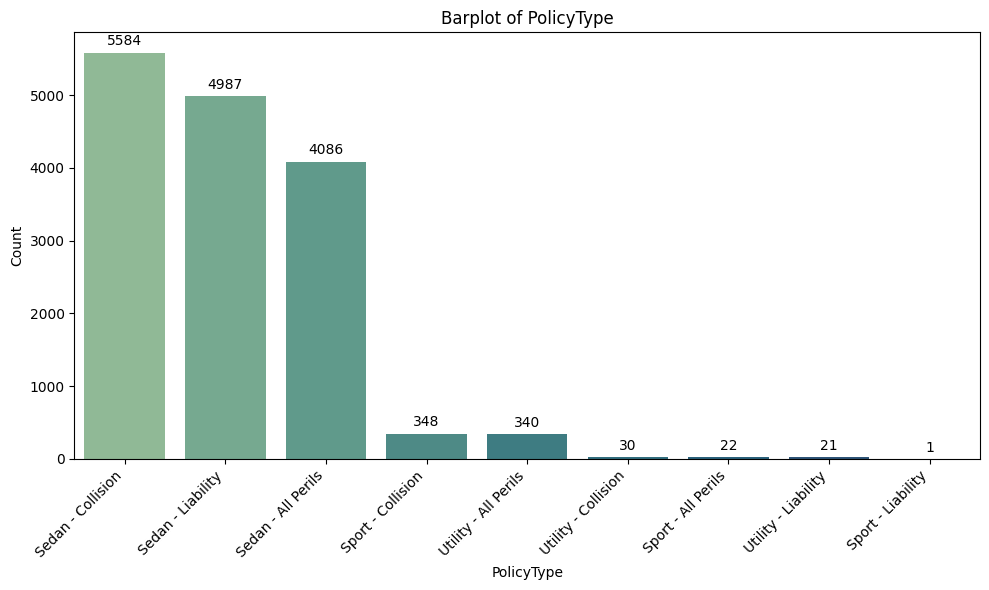

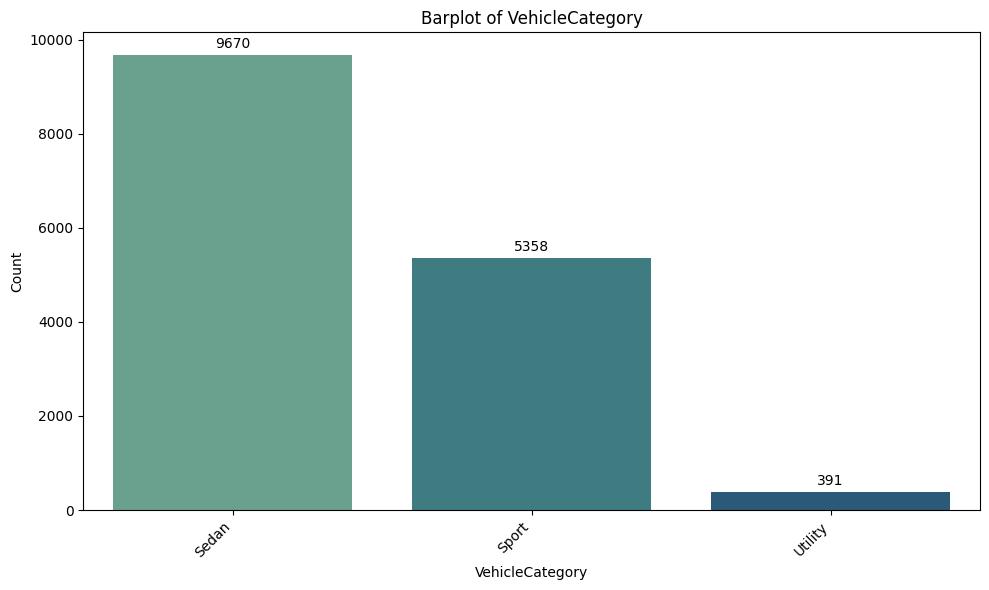

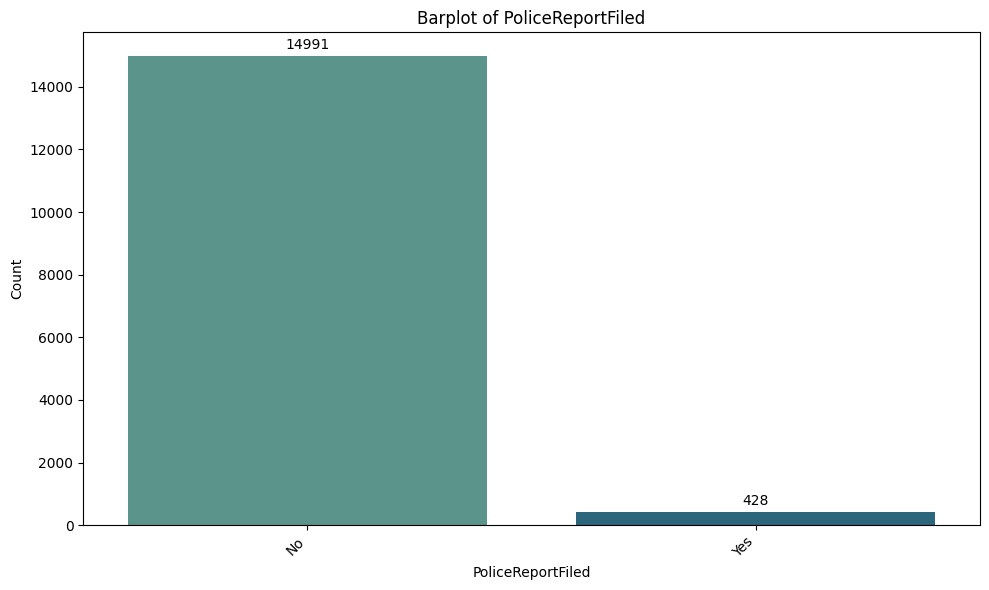

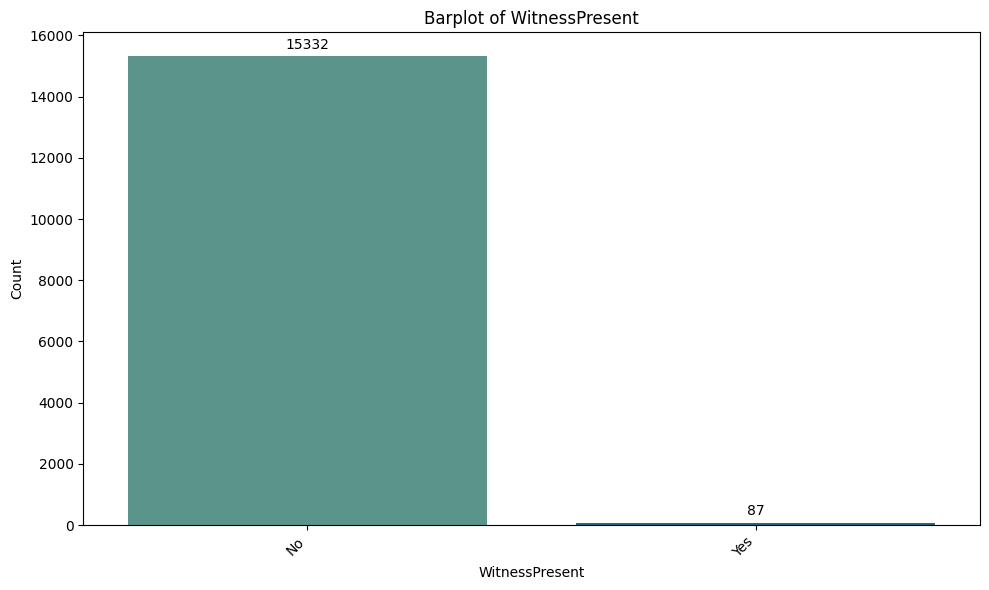

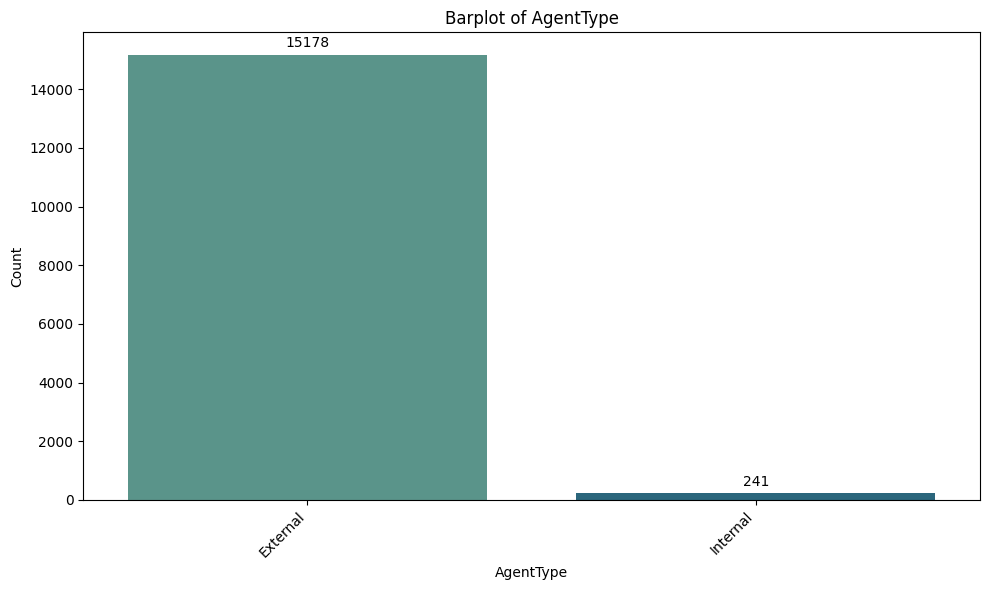

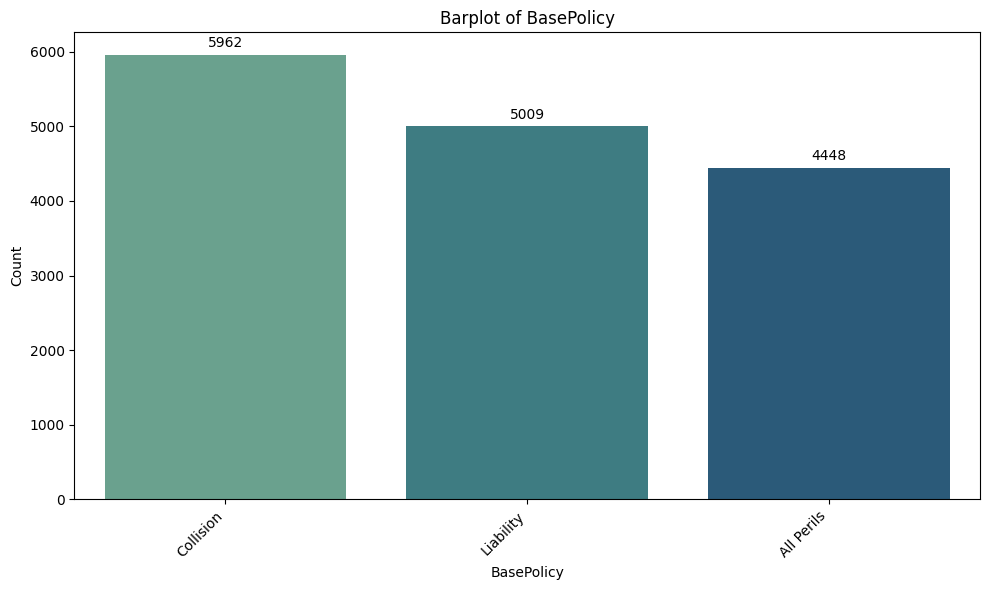

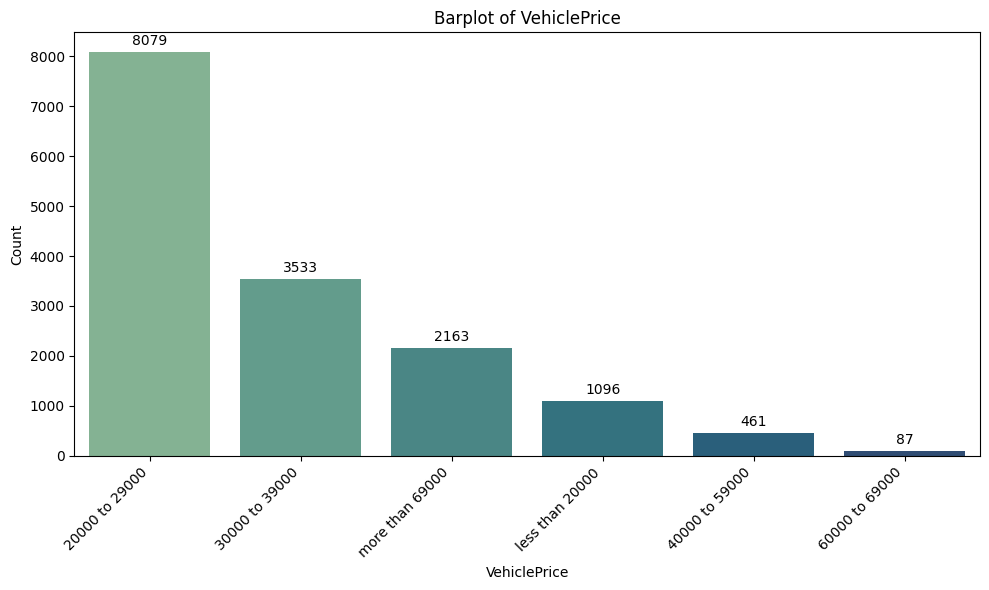

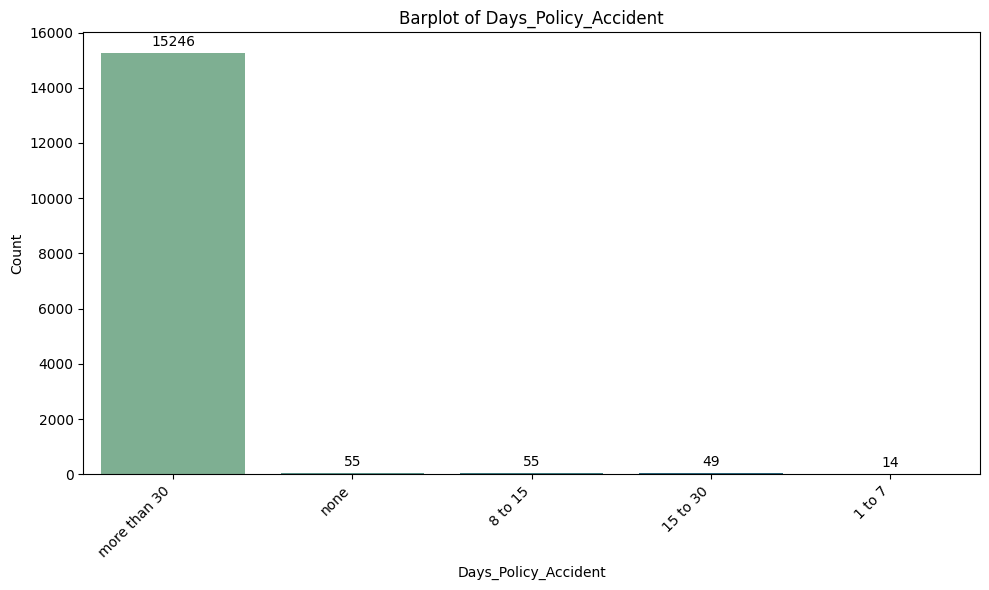

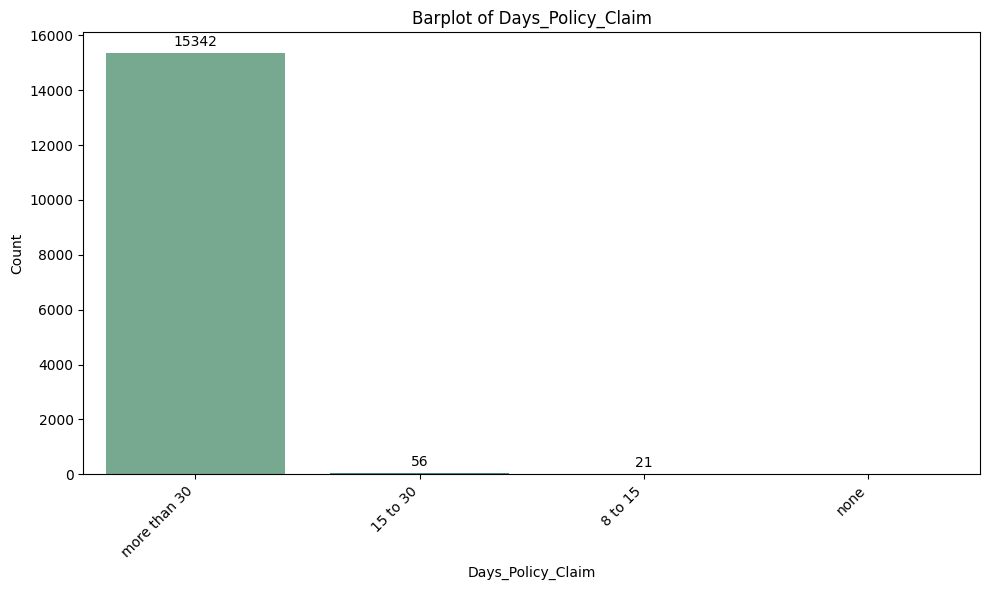

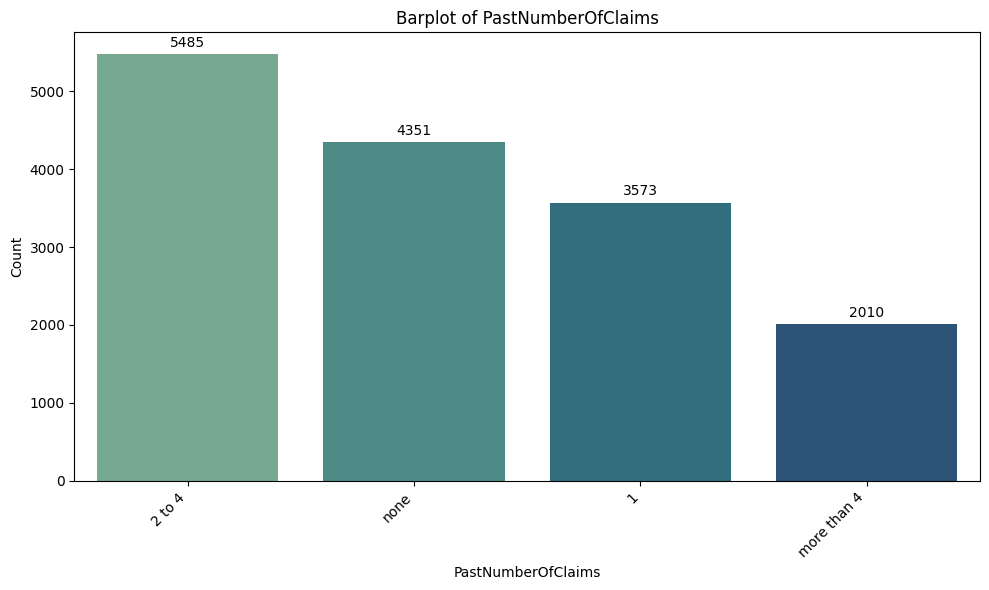

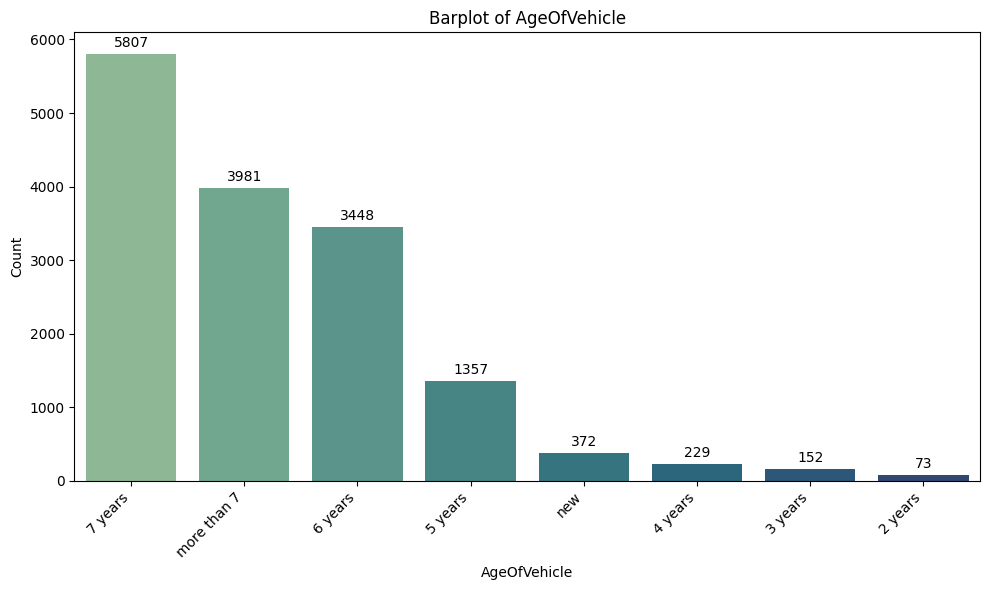

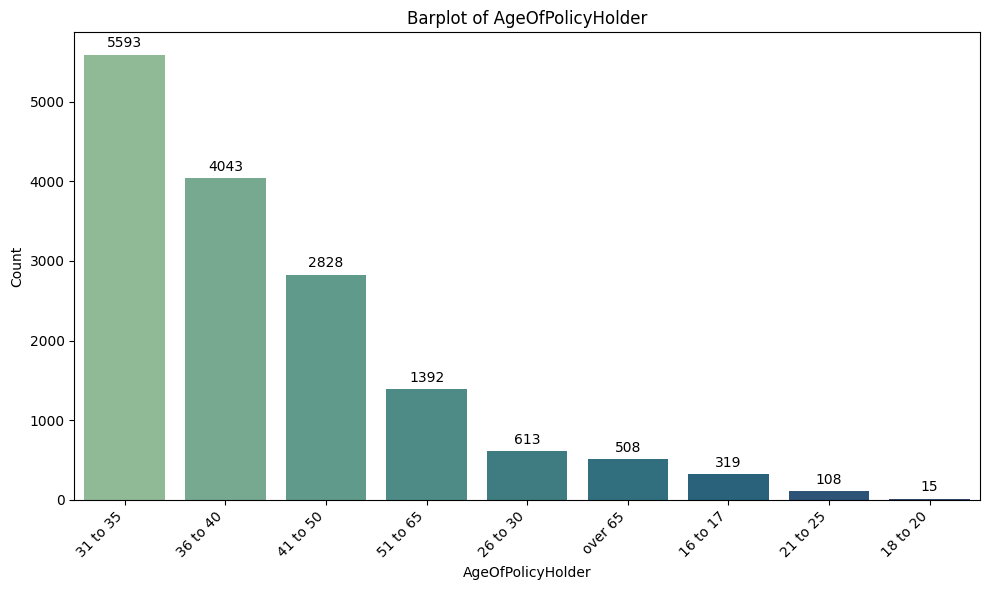

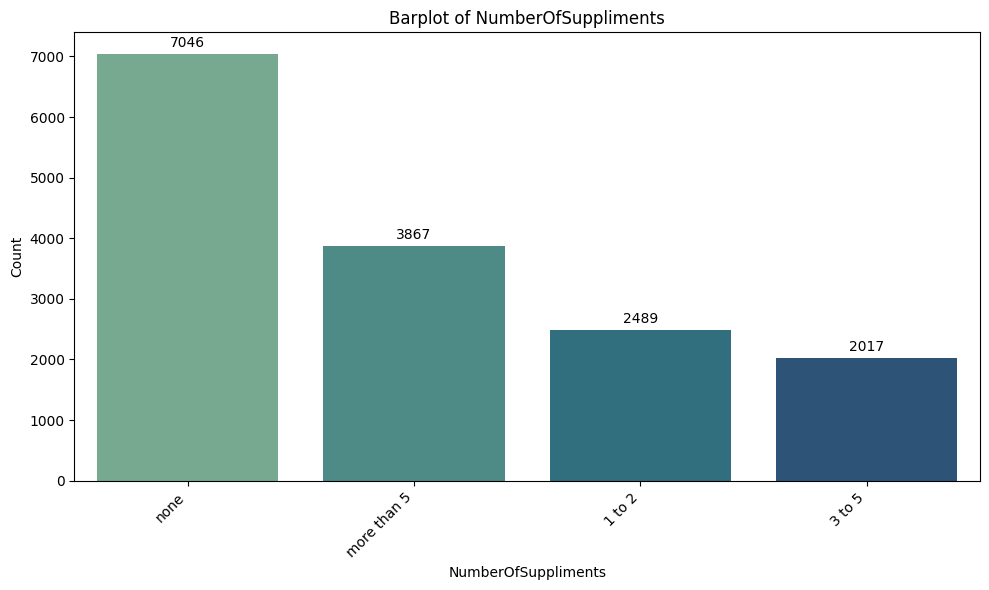

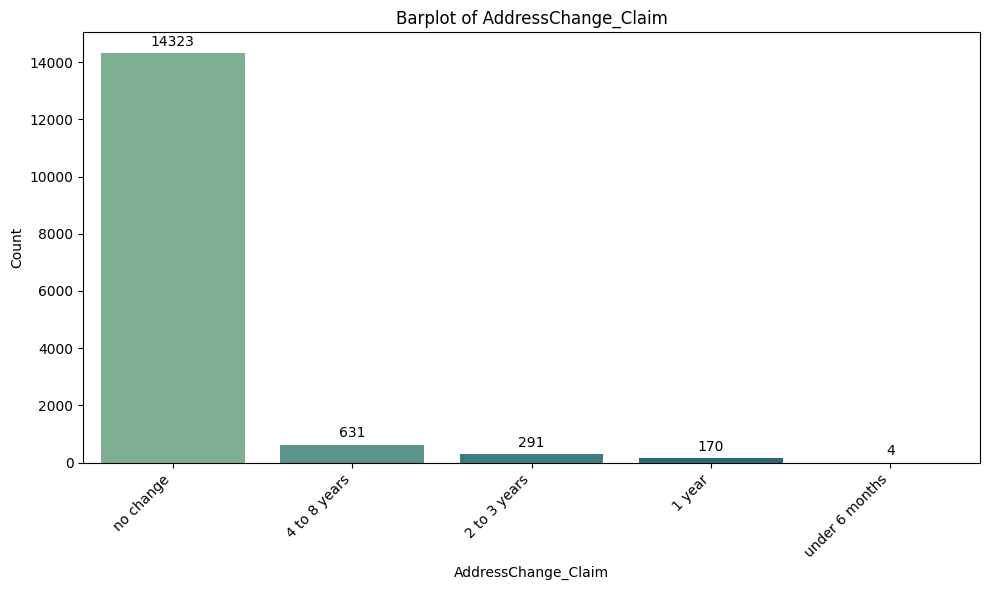

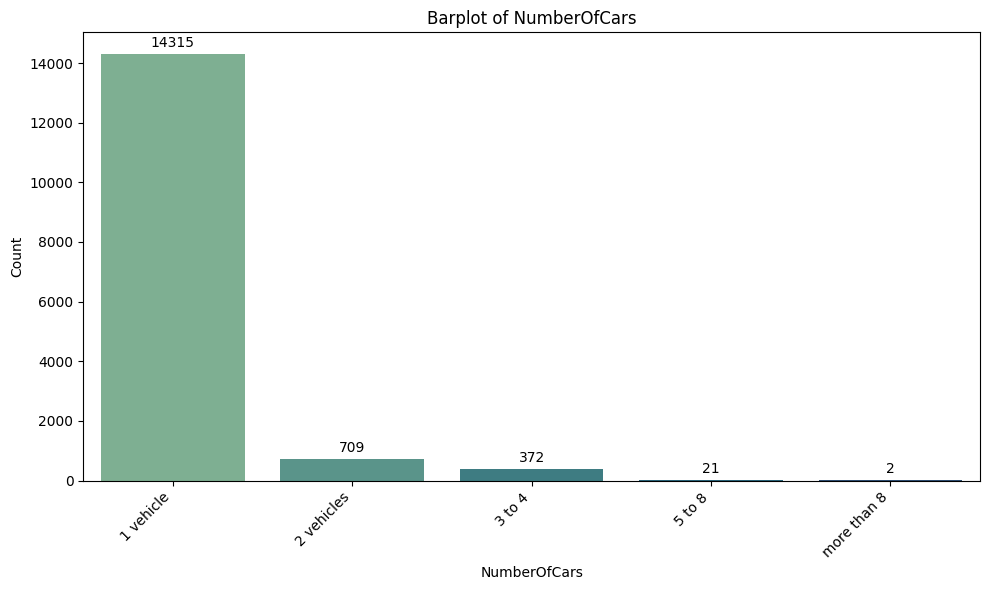

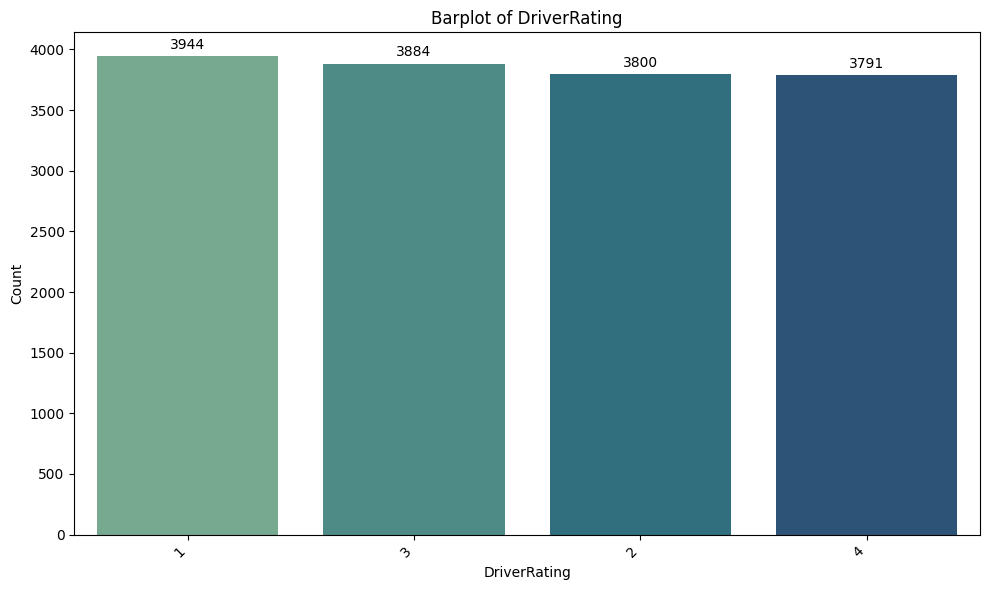

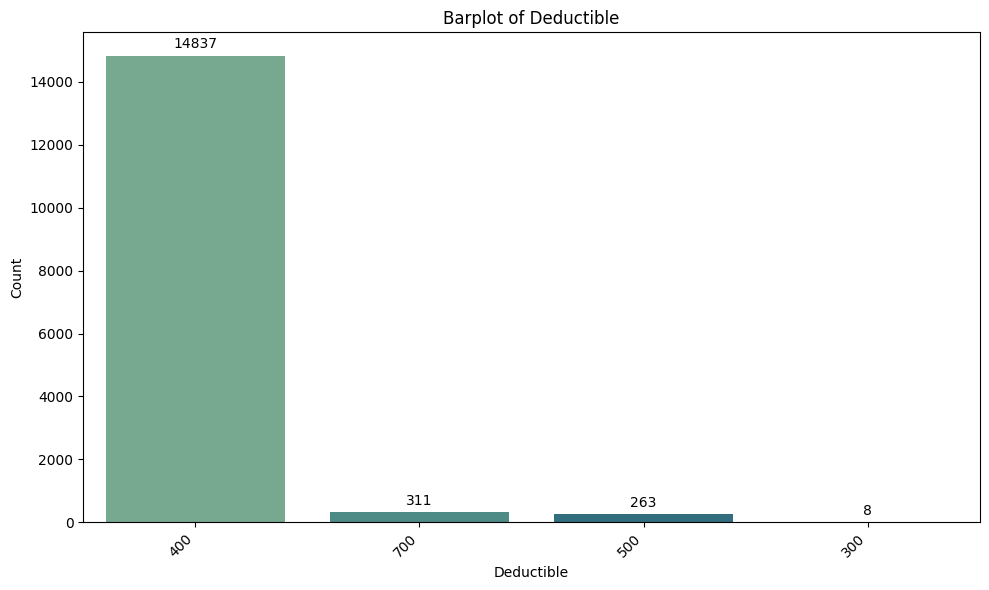

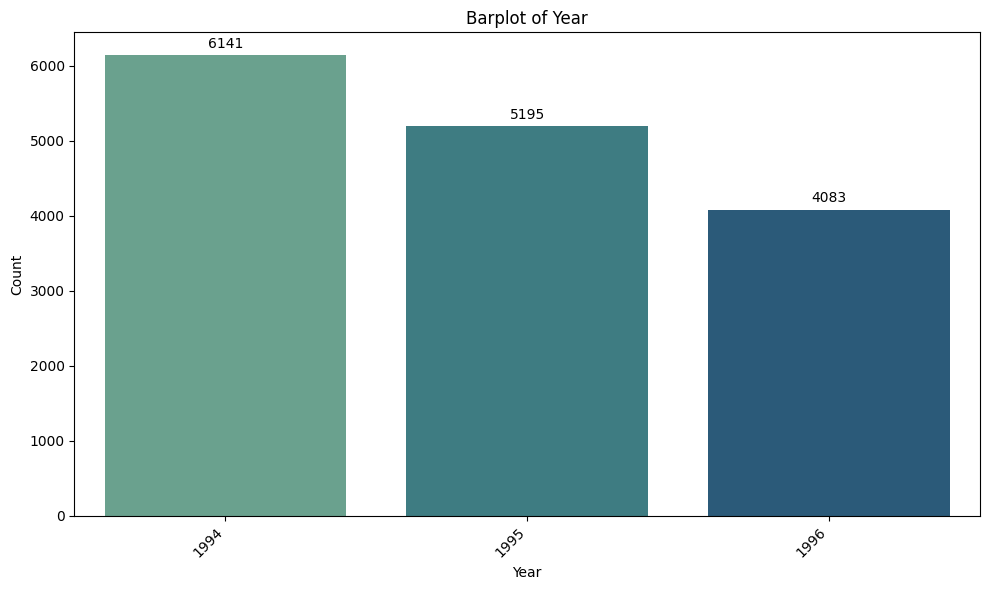

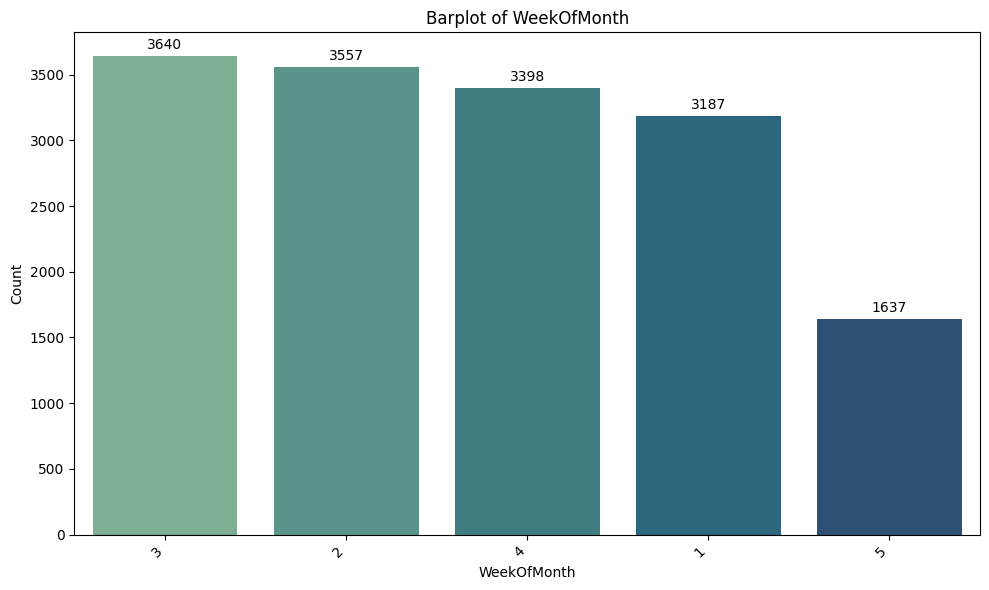

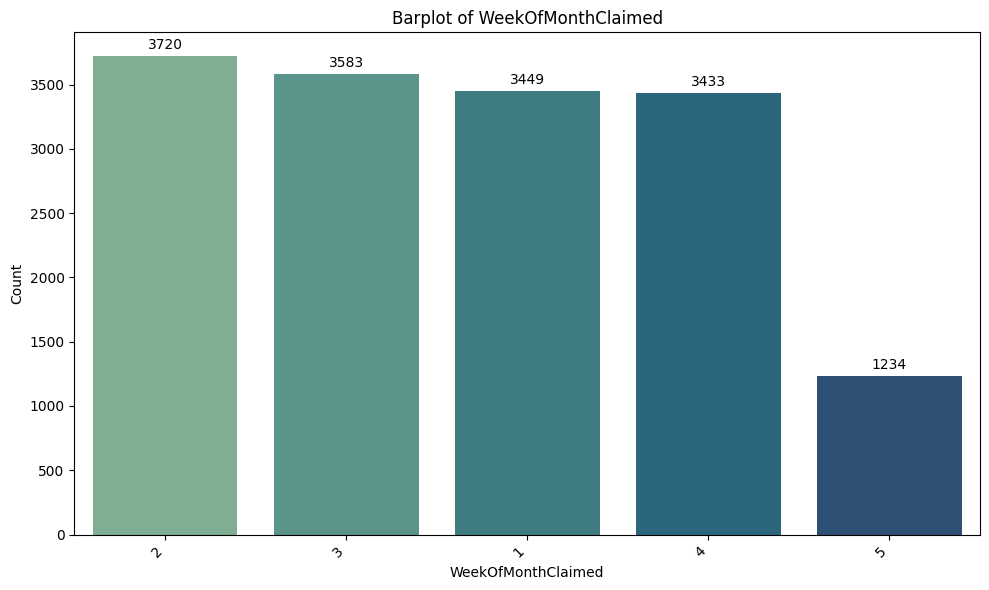

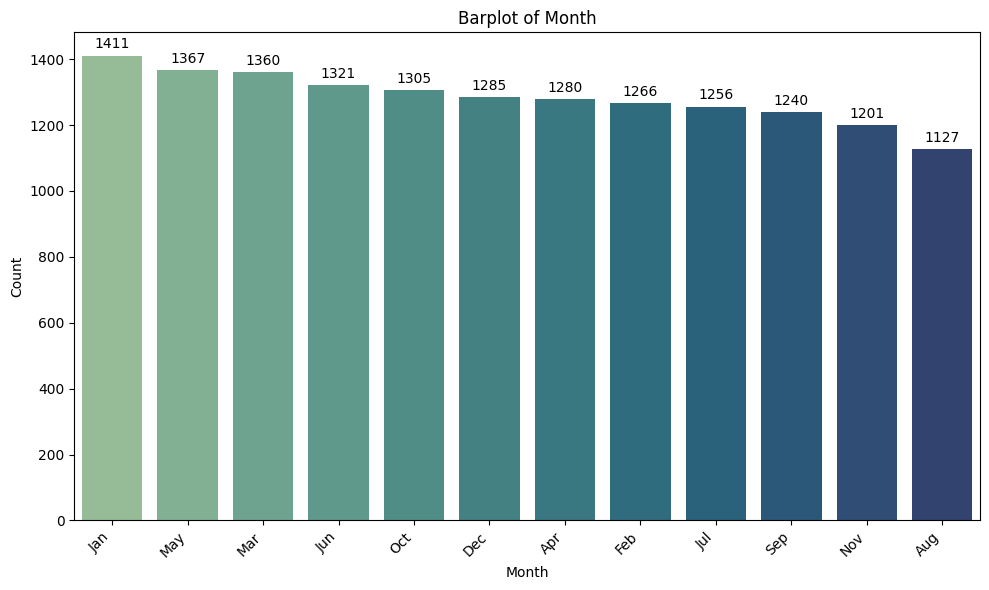

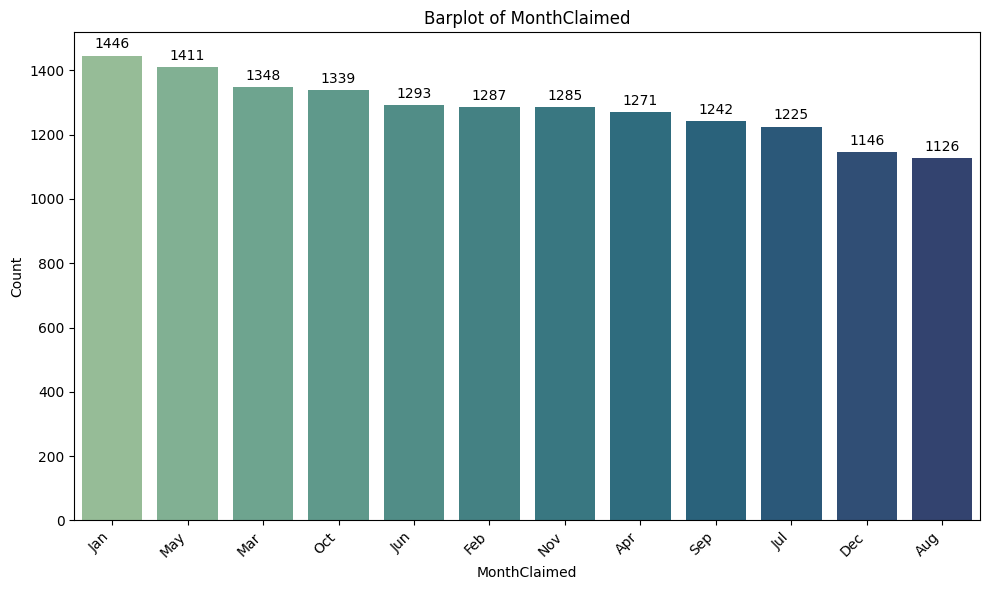

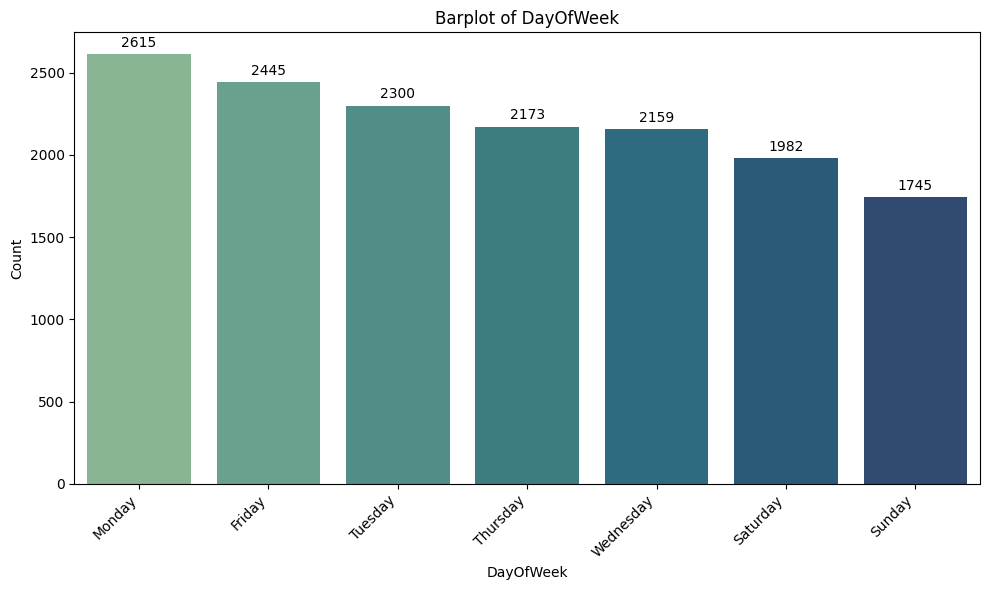

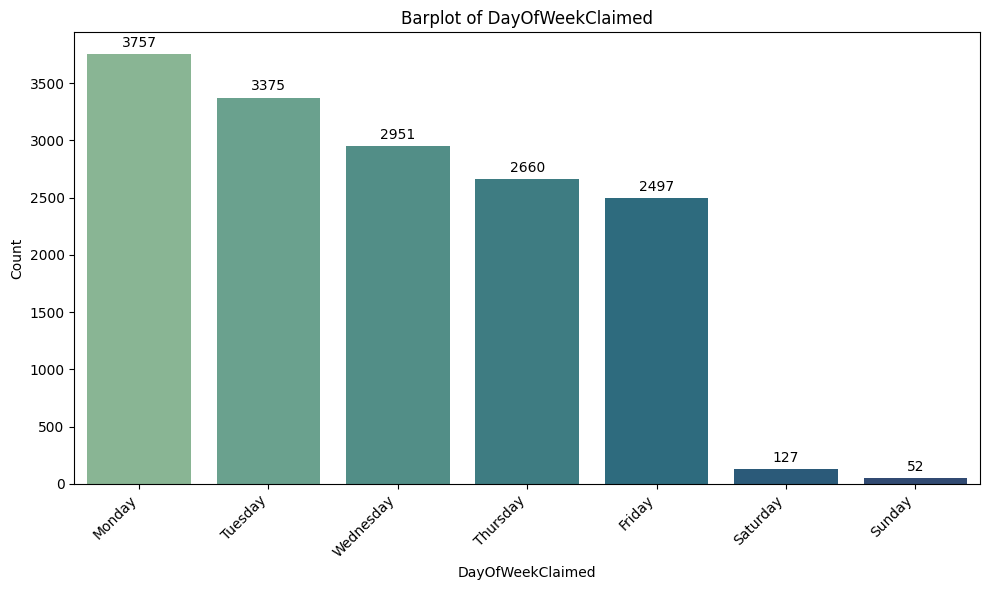

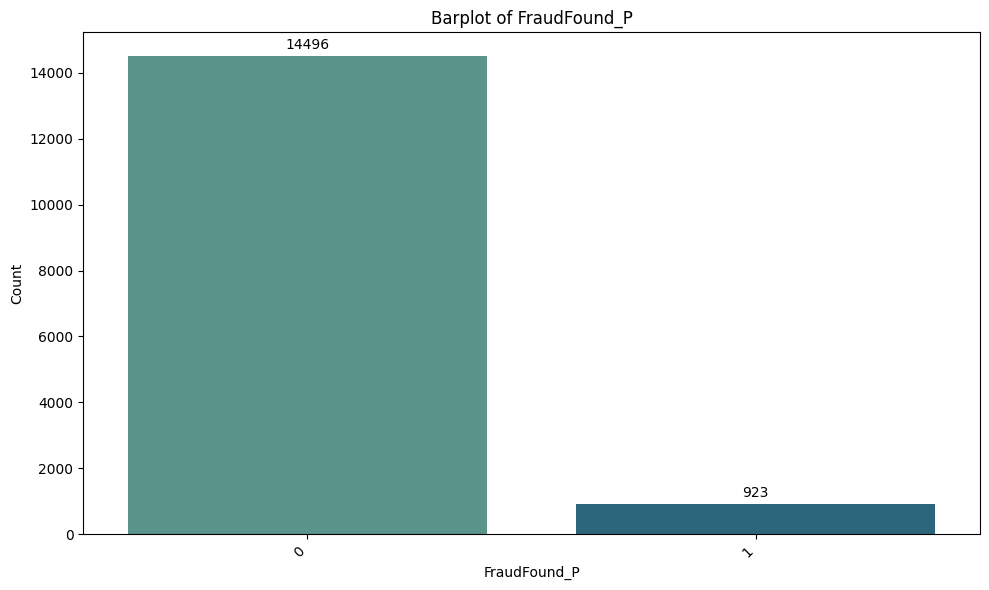

In [26]:
# create bar charts for categorical features
for feature in eda_features:
    plt.figure(figsize=(10, 6))

    order = df[feature].value_counts().index  # sorted by count (desc)
    ax = sns.countplot(data=df, x=feature, order=order, palette='crest')

    # annotate bars that were actually drawn
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=10)

    plt.title(f'Barplot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Categorical univariate insights:

*  Many of the features reflect unstable/uneven distributions, with many reflecting sparse categories.
*  Most of the temporal features are relatively stable
*  The target, 'FraudFound_P' is very imbalanced, which is to be expected in fraud use cases

### Histogram for numeric feature

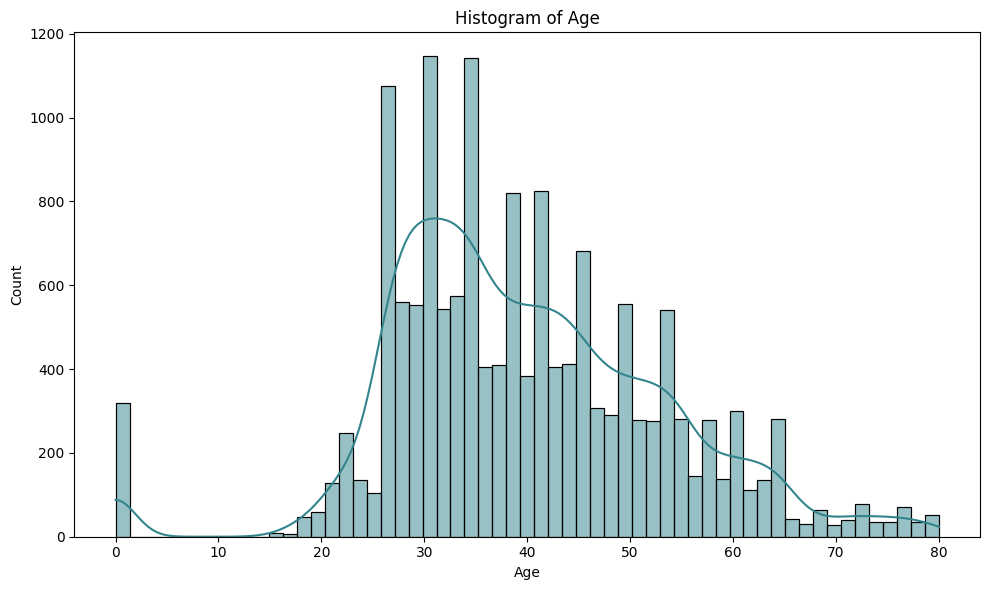

In [27]:
colors = sns.color_palette("crest", 1)
plt.figure(figsize=(10,6))
sns.histplot(df[num_features], kde=True, color=colors[0])
plt.title(f'Histogram of {num_features}')
plt.xlabel(num_features)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Numeric univariate insights:

*  Large spike at 0 suggests data quality issue, as babies can't drive
*  Likely represents default/placeholder or missing value encoded as 0, since there appears to be between 300-350 records (which is about 2%)
*  To address this, one of two options will be implemented:
    * During preprocessing, the 0 values will be replaced with nan; once the modeling pipeline is initiated, they will be imputed with the median age (maybe by martial status)  or,
    * Age will be dropped, as there's already a binned age column

## Bivariate 

1. Categorical vs Target: Heatmap of crosstabs
2. Numerical vs Target: Violinplots
3. Behavioral relationships with Target: fraud-rate
4. Effect size: Lift
5. Association Analysis

### Heatmaps for categorical features by target

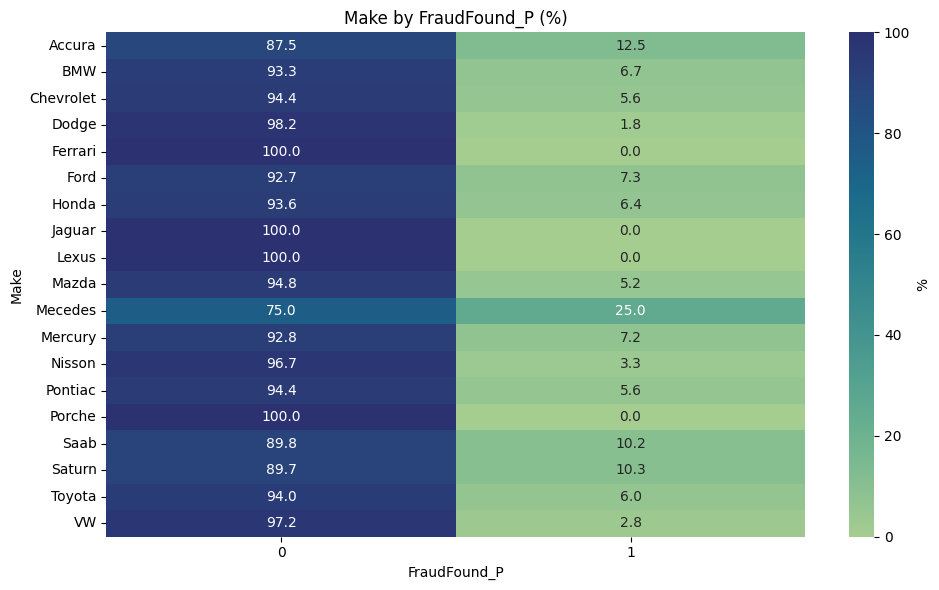

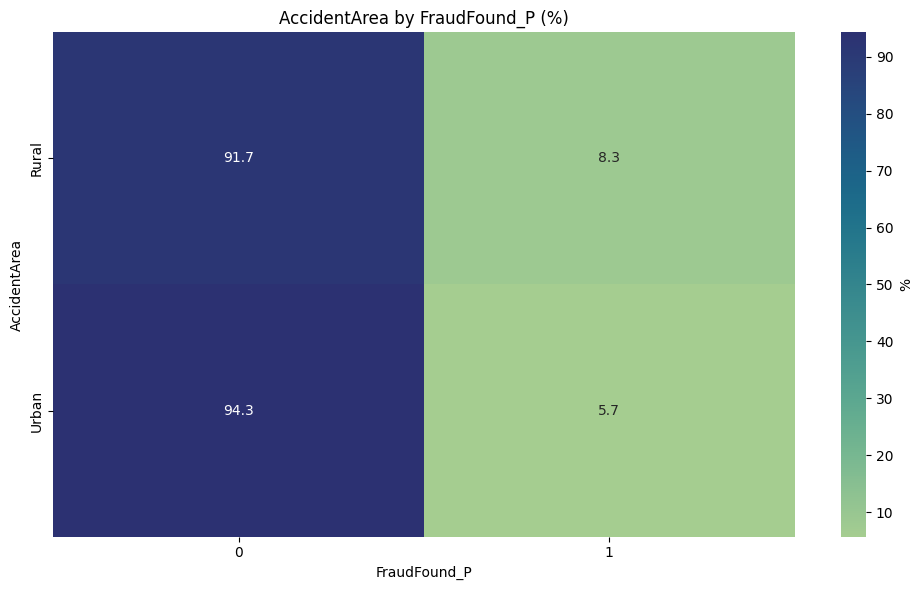

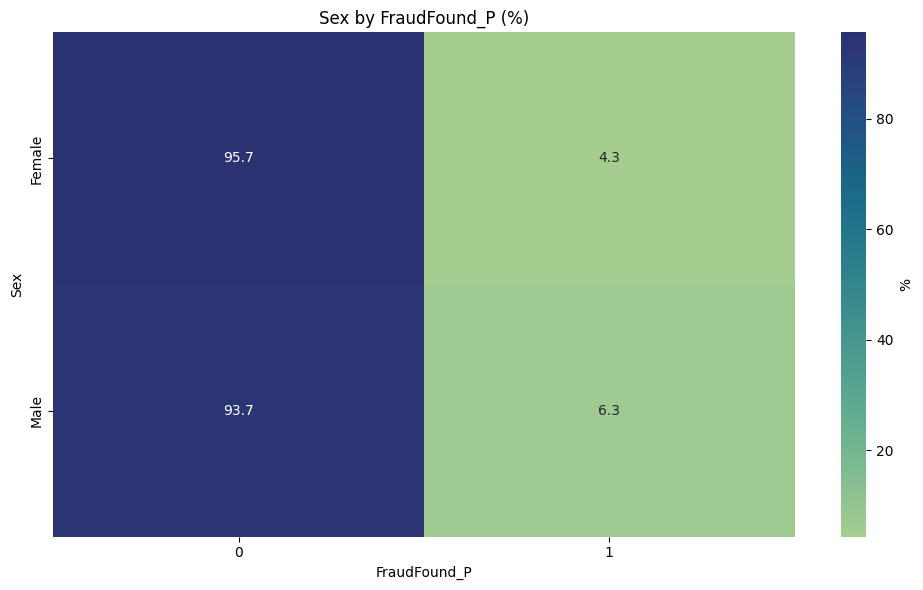

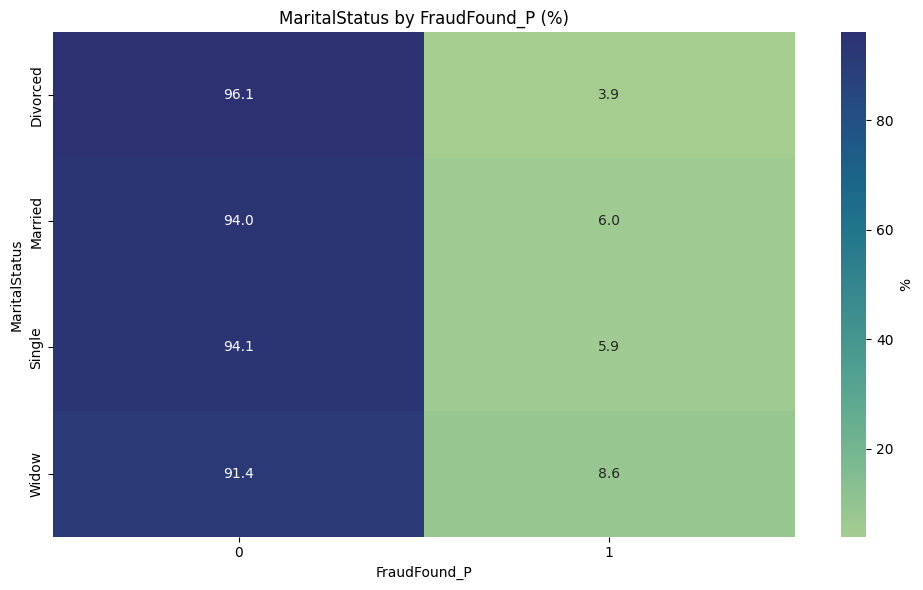

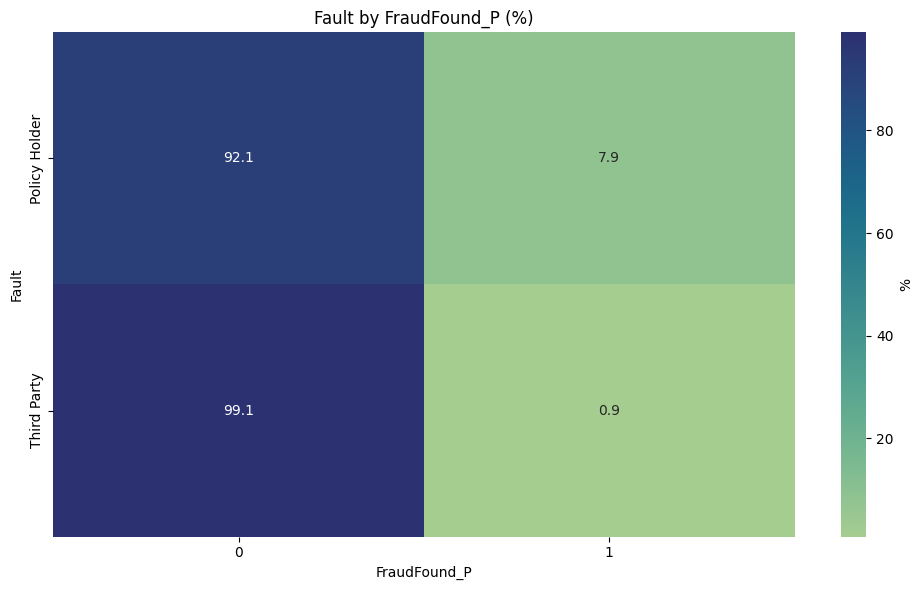

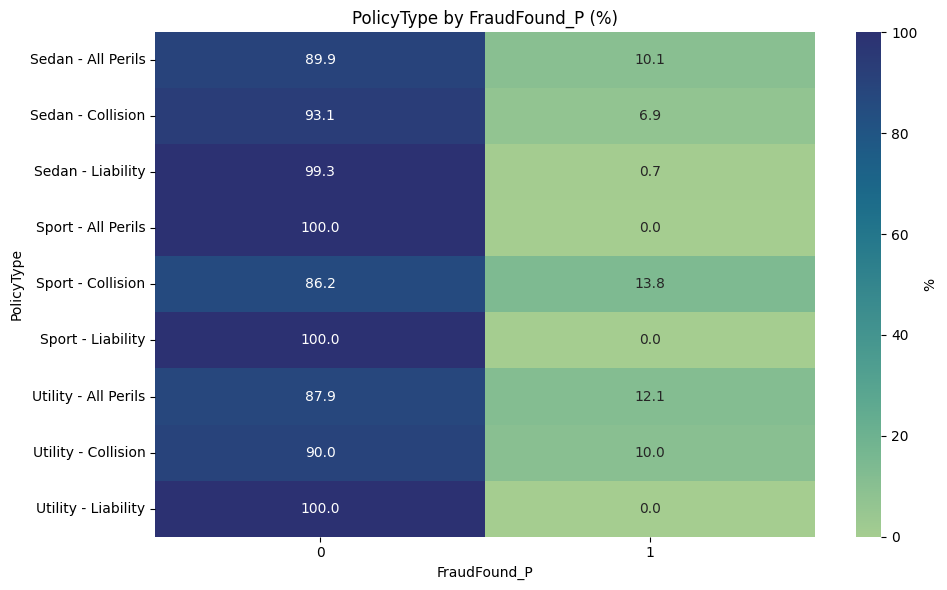

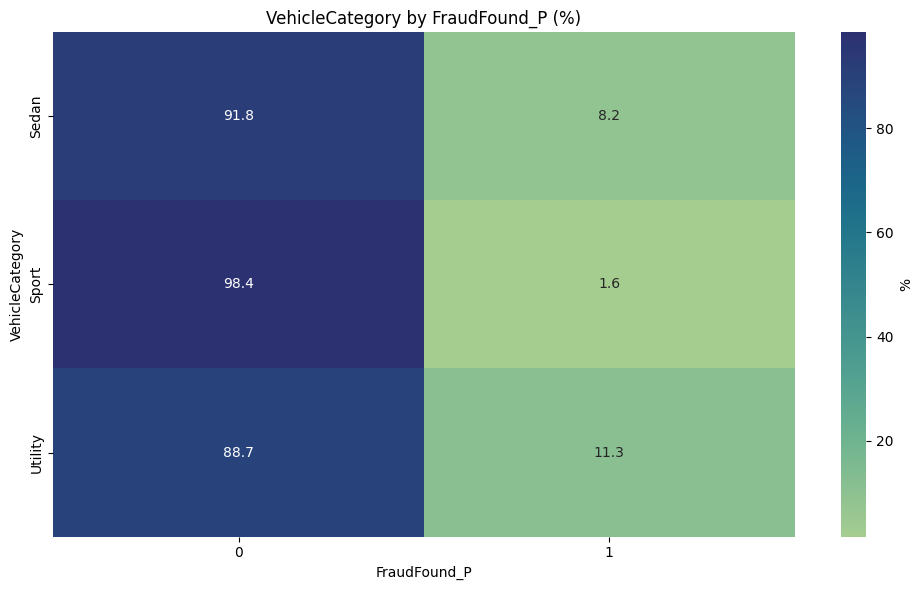

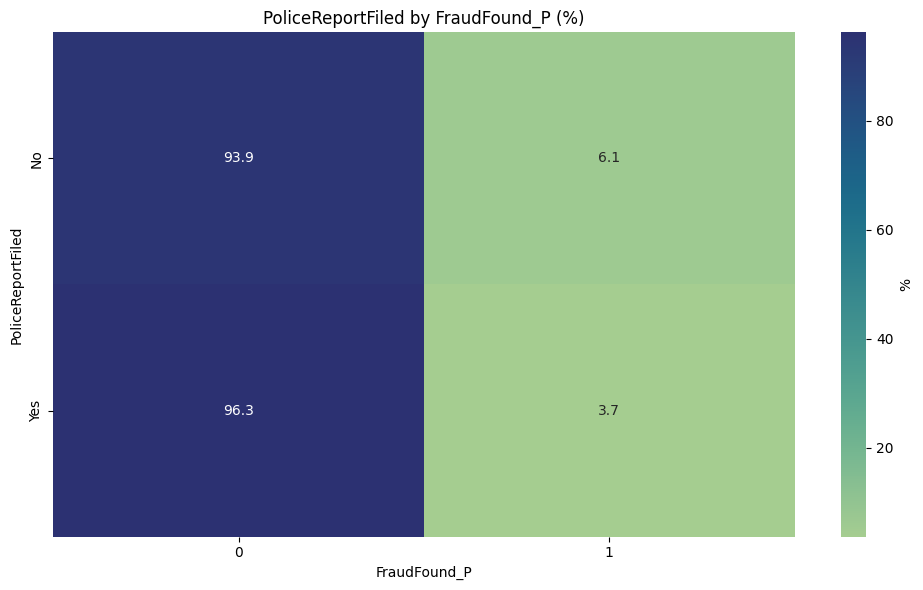

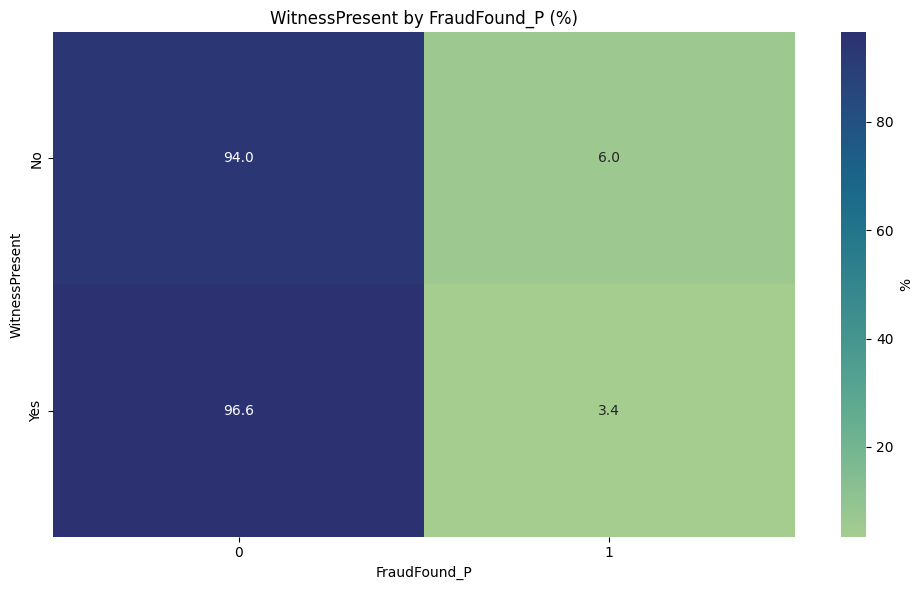

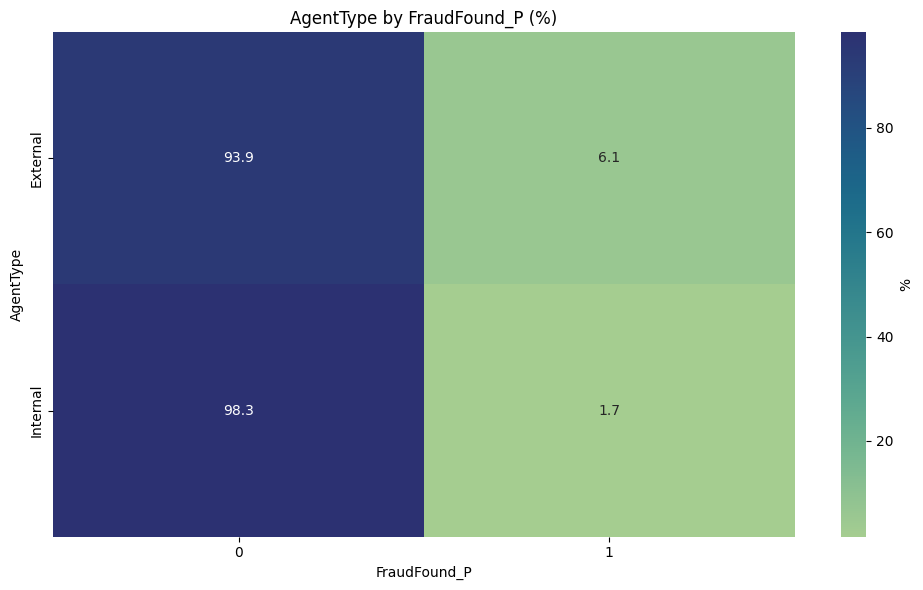

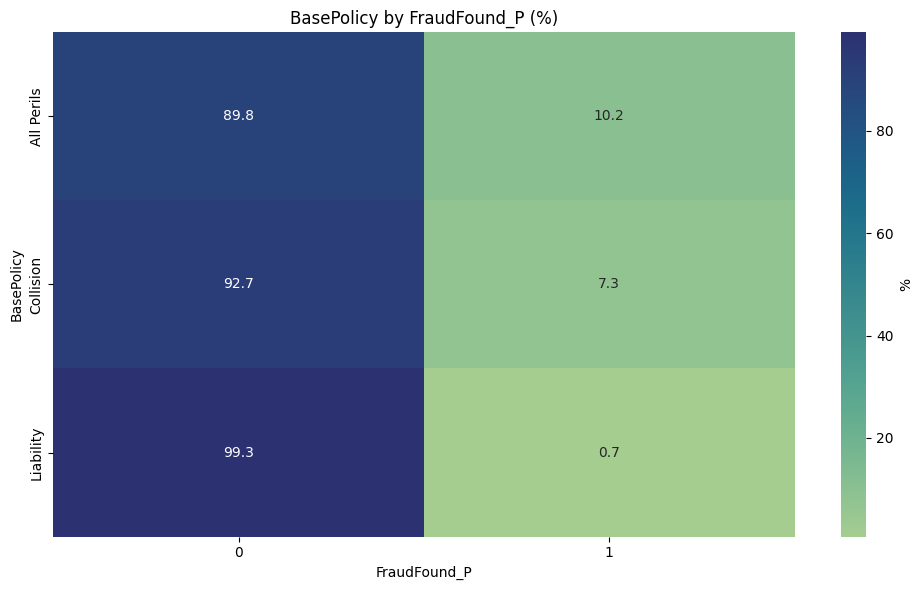

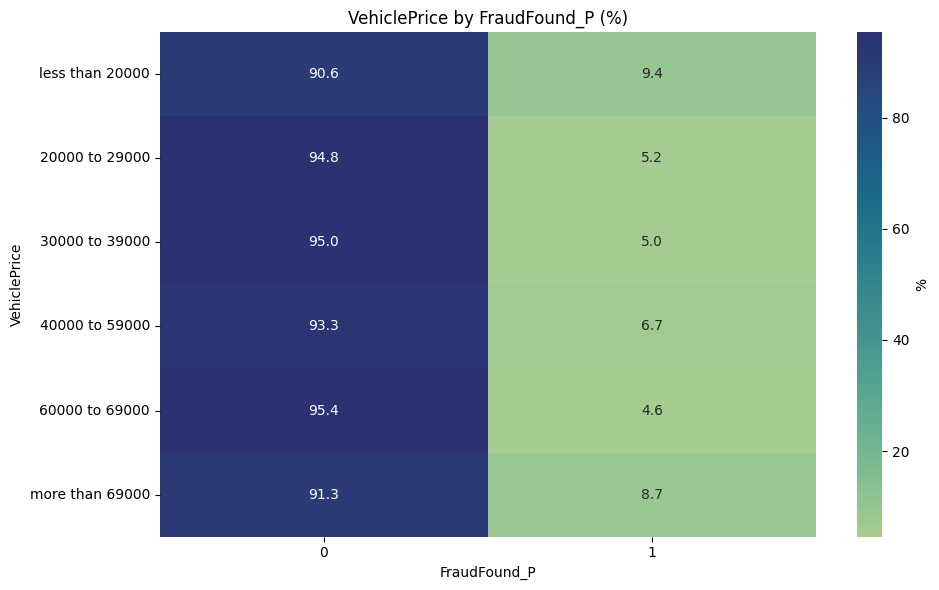

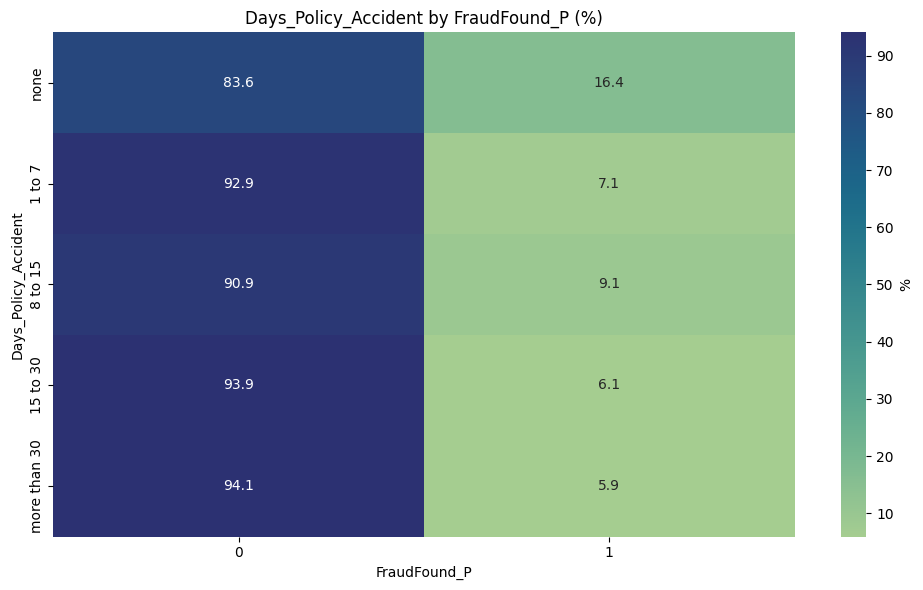

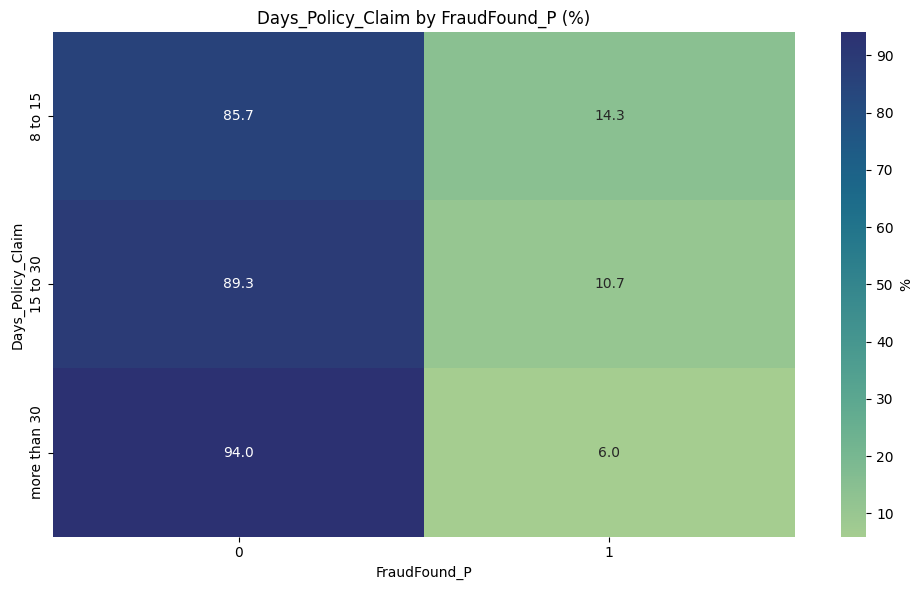

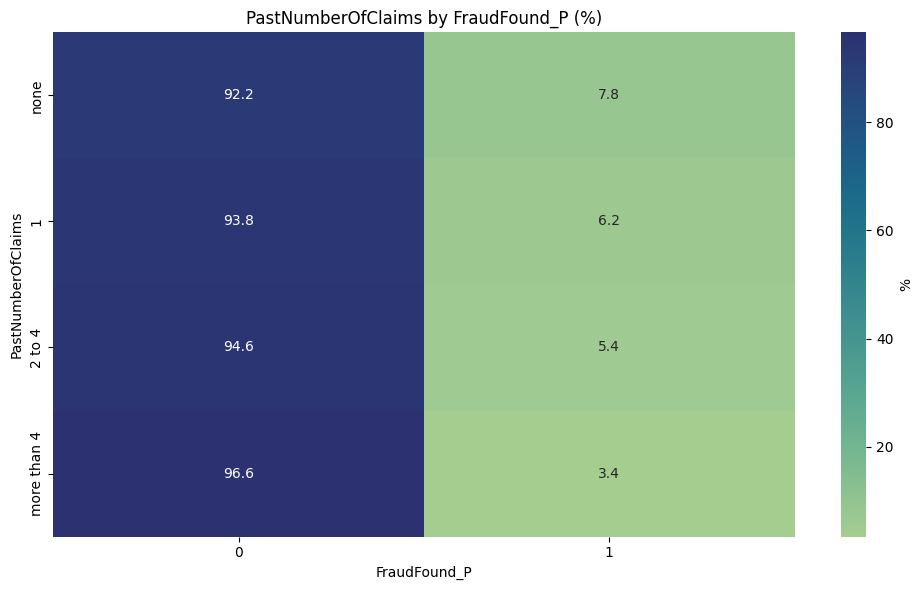

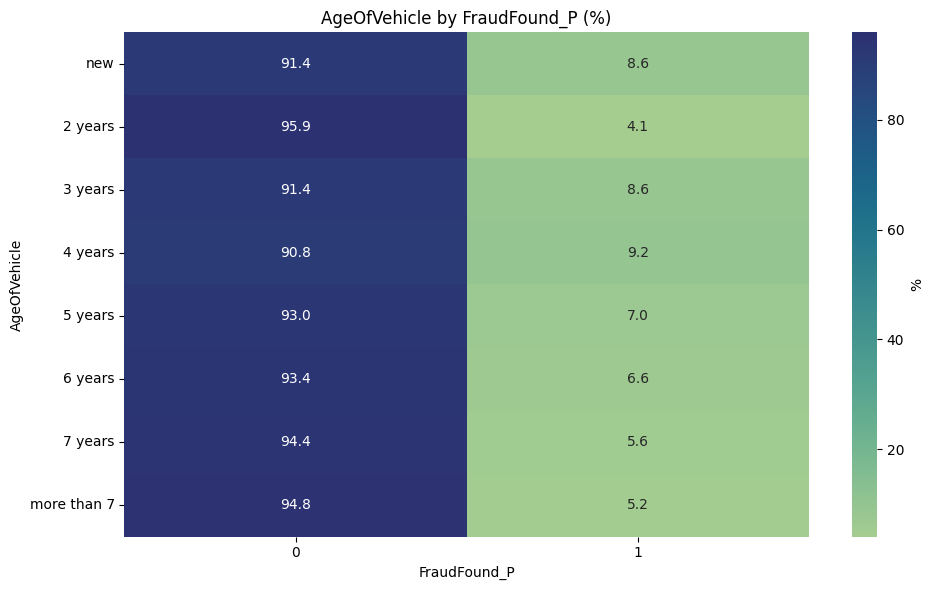

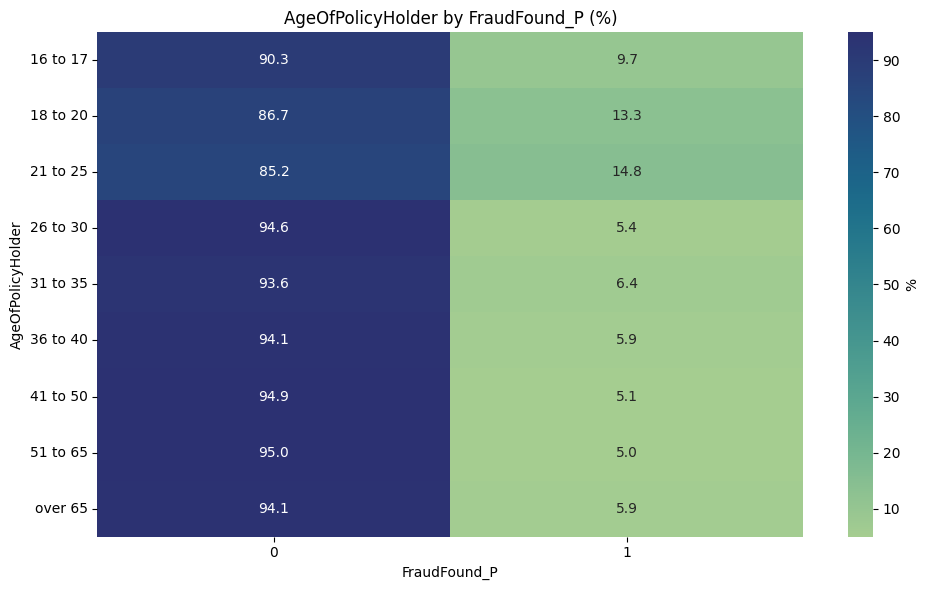

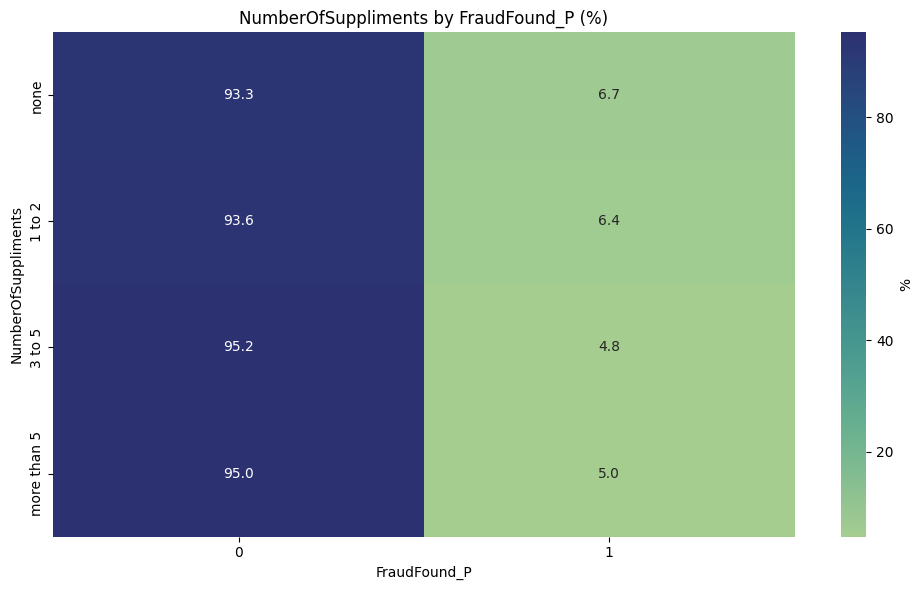

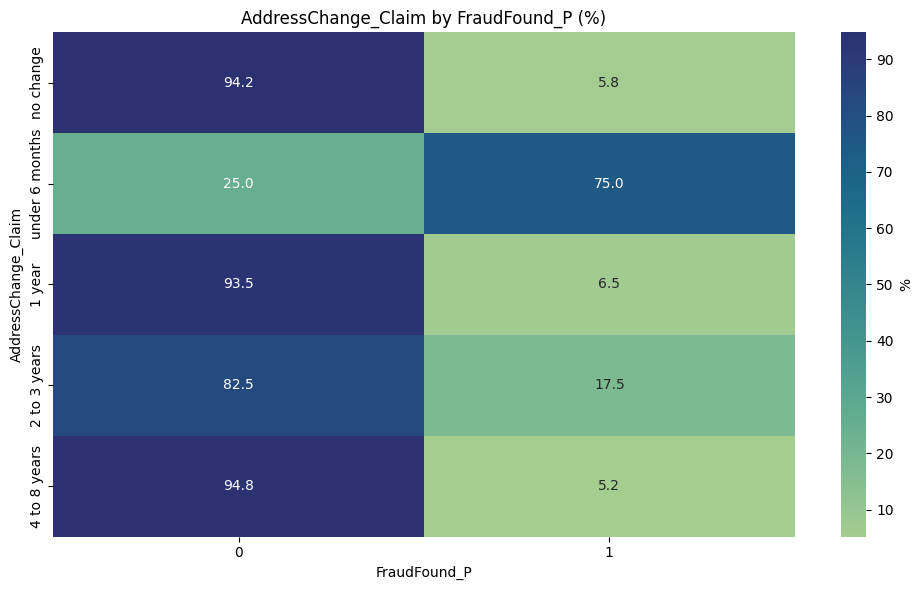

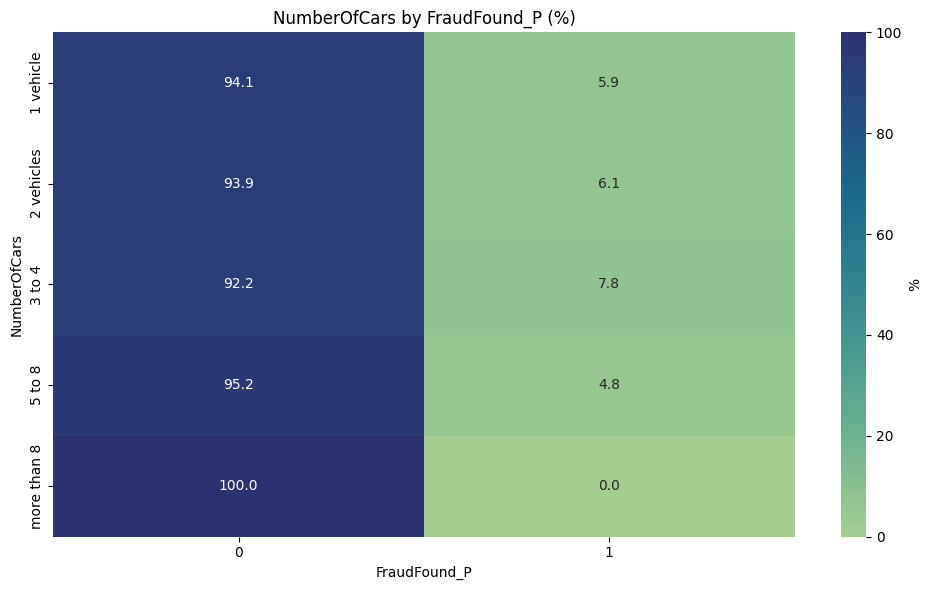

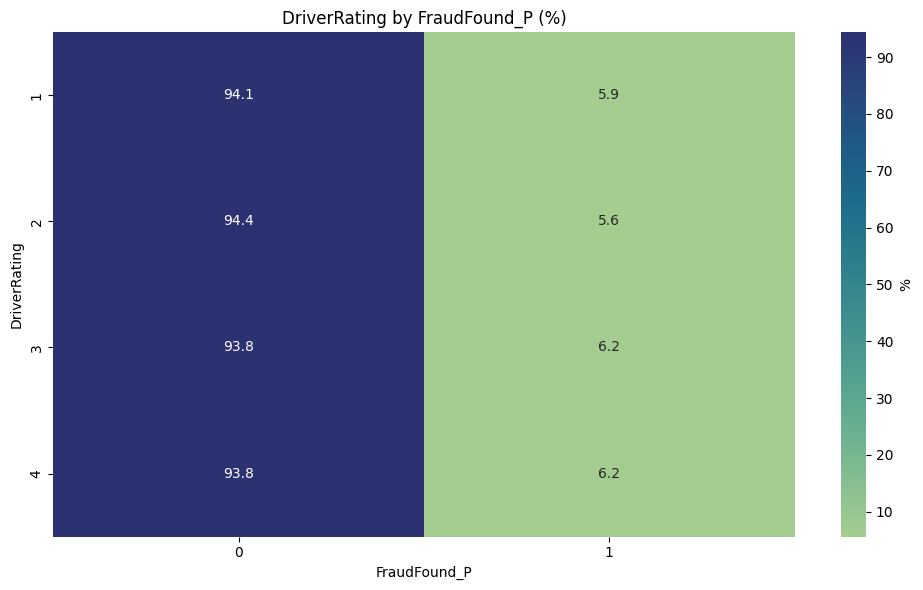

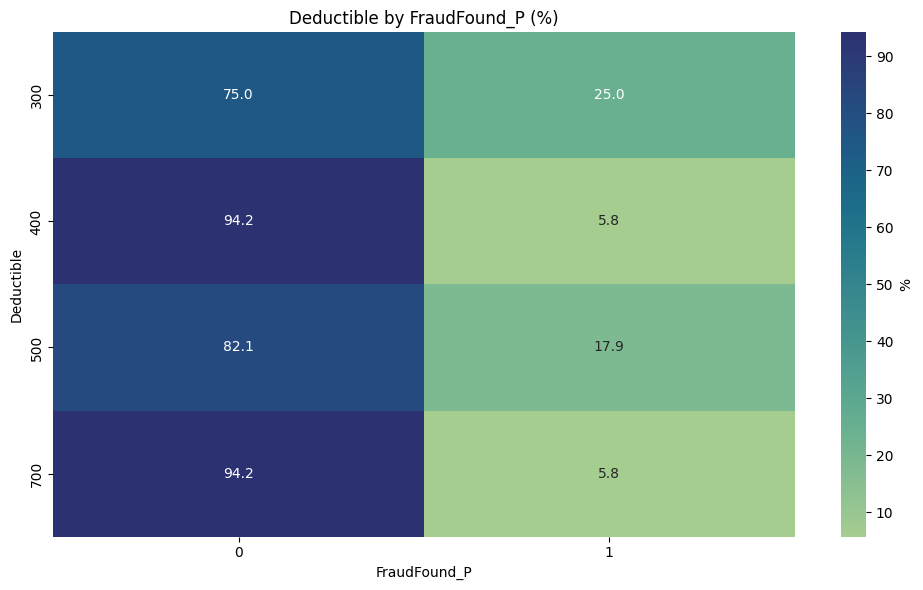

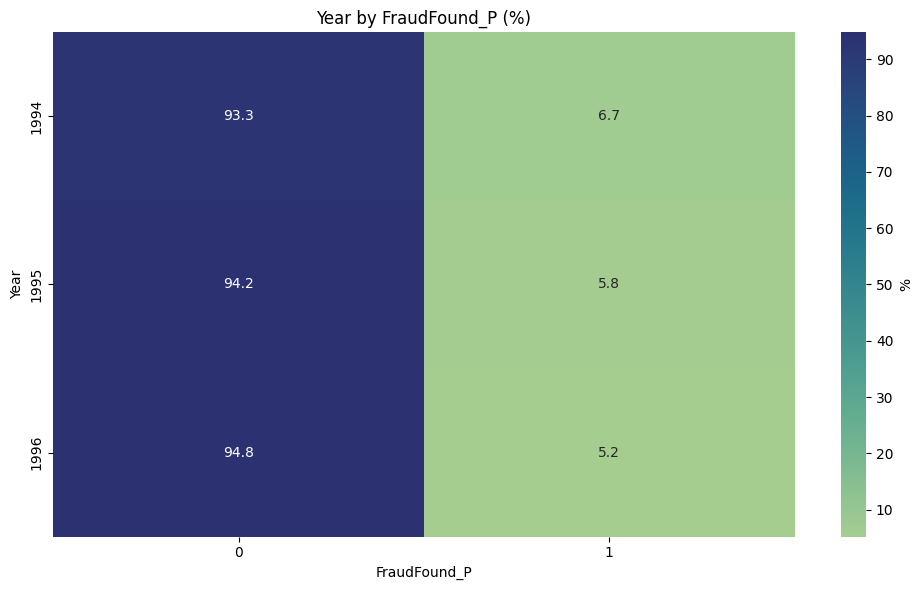

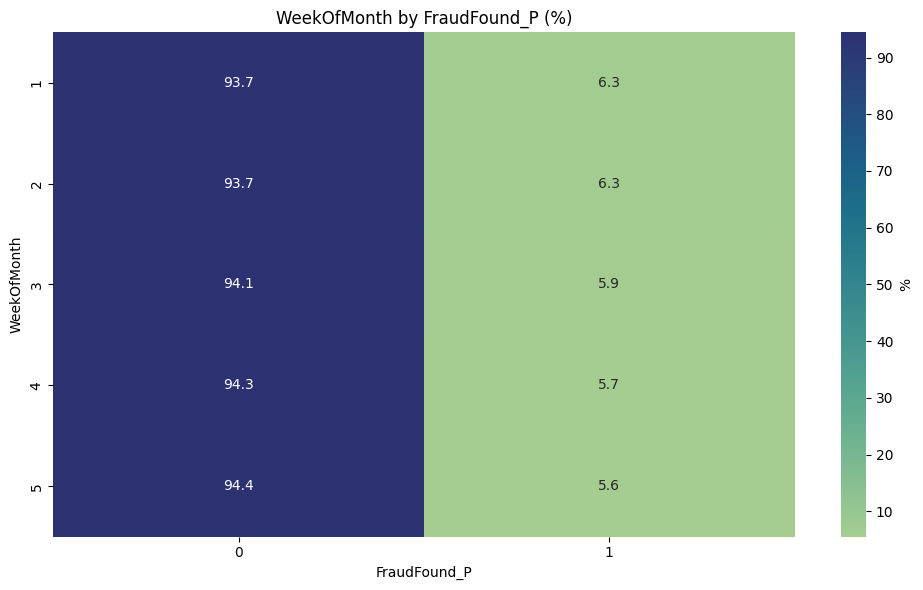

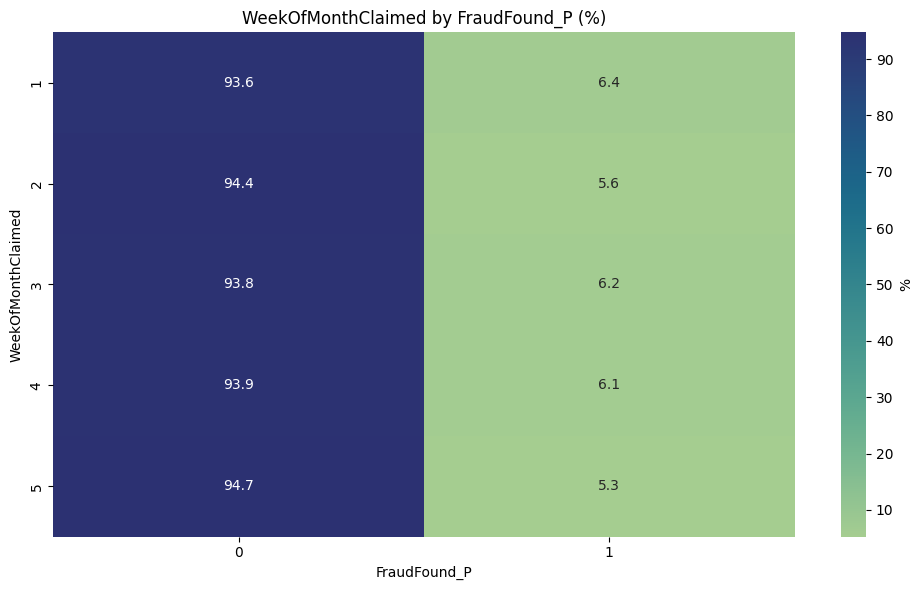

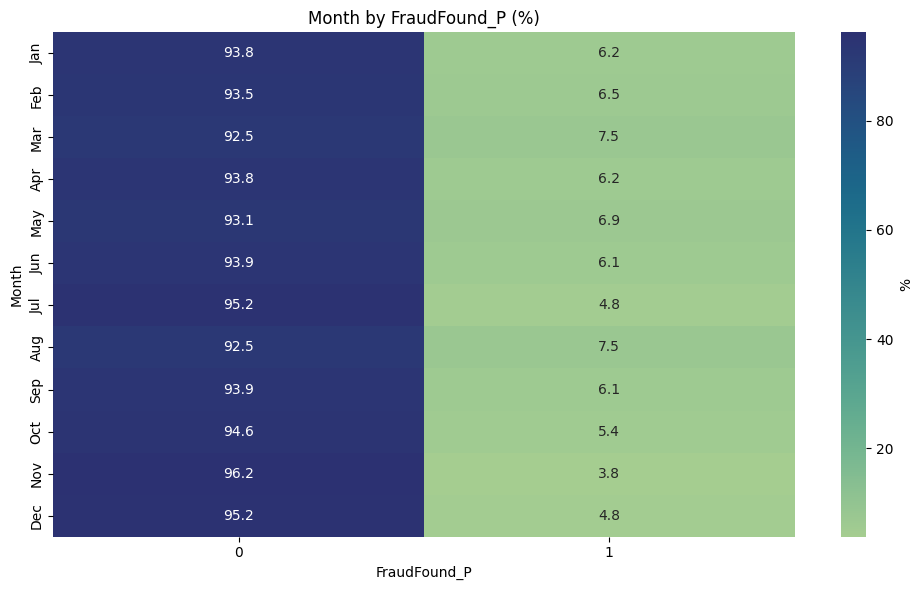

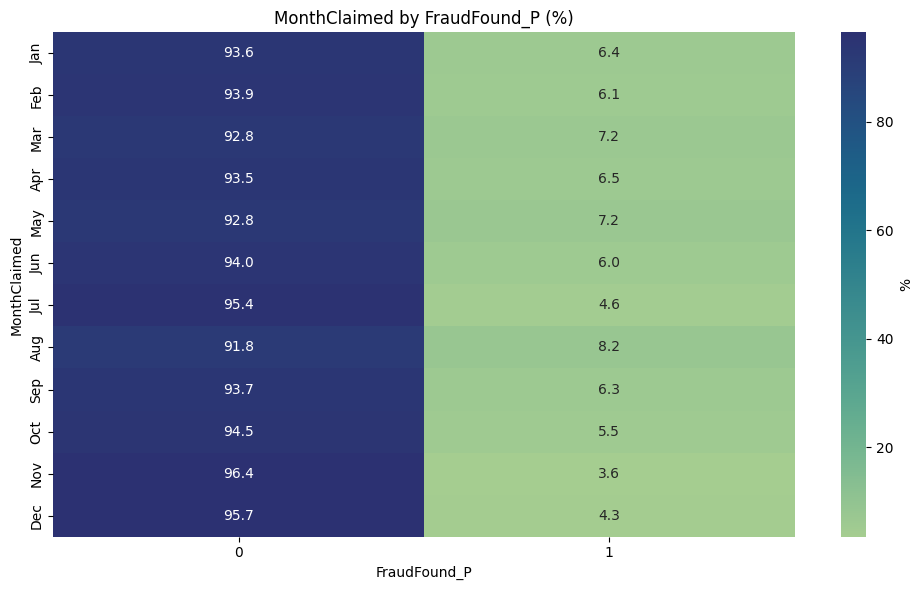

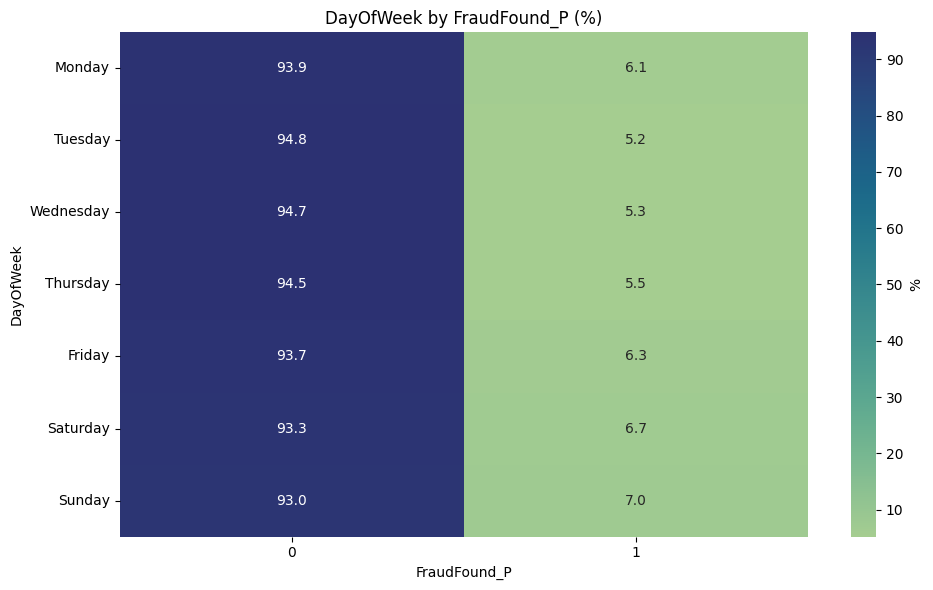

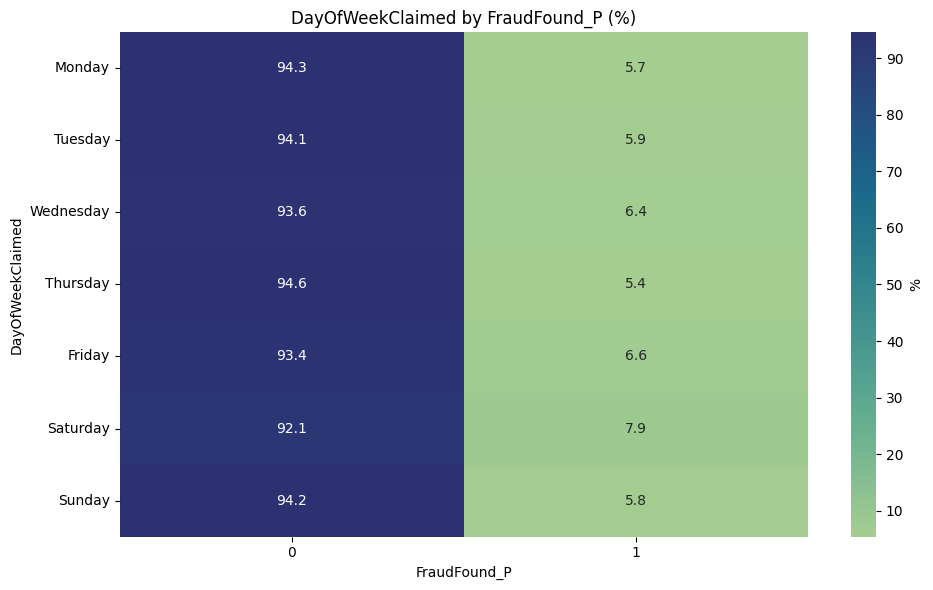

In [28]:
# create heatmaps
for feature in eda_features:
    if feature != 'FraudFound_P':
        plt.figure(figsize=(10,6))
        ct = pd.crosstab(df[feature], df['FraudFound_P'], normalize='index') * 100
        sns.heatmap(ct, annot=True, fmt='.1f', cmap='crest', cbar_kws={'label': '%'})
        plt.title(f'{feature} by FraudFound_P (%)')
        plt.xlabel('FraudFound_P')
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show

Categorical distribution insights:

*  Most of the categorical features are not highly seperable by the target, FraudFound_P, which is to be expected.
*  Given the very small percentage of fraud found, anything over 10% is considered noticeable.
*  AddressChange_Claim's 'under 6 month' category showed high seperability (fraud found in 75%), while '2 to 3 year' category showed noticeable fraud rates (17.5%).
*  There were a few outliers in the Make feature, including  Mercedes (fraud found in 25%) and Accura (12.5%)
*  Deductible also showed noticeable concentrations of fraud at the $300 and $500 amounts (25% and 17.9% respectively).
*  AgeOfPolicyHolder showed higher concentrations of fraud amongst it's younger drives (16-25) 

### Violin plot for numeric feature by target

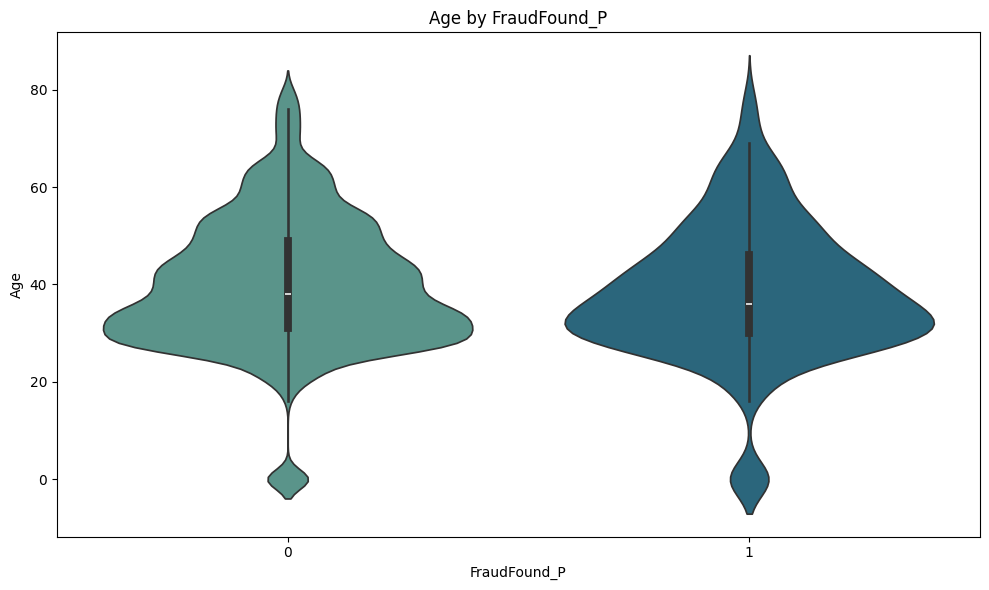

In [29]:
# create violin plot
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='FraudFound_P', y='Age', palette='crest')
plt.title('Age by FraudFound_P')
plt.tight_layout()
plt.show()

Numeric distribution insights:

*  The Age feature is not seperable by the fraud, the target.
*  Age will not be included for feature selection, since a binned version is still available.

### Fraud rate for categorical features

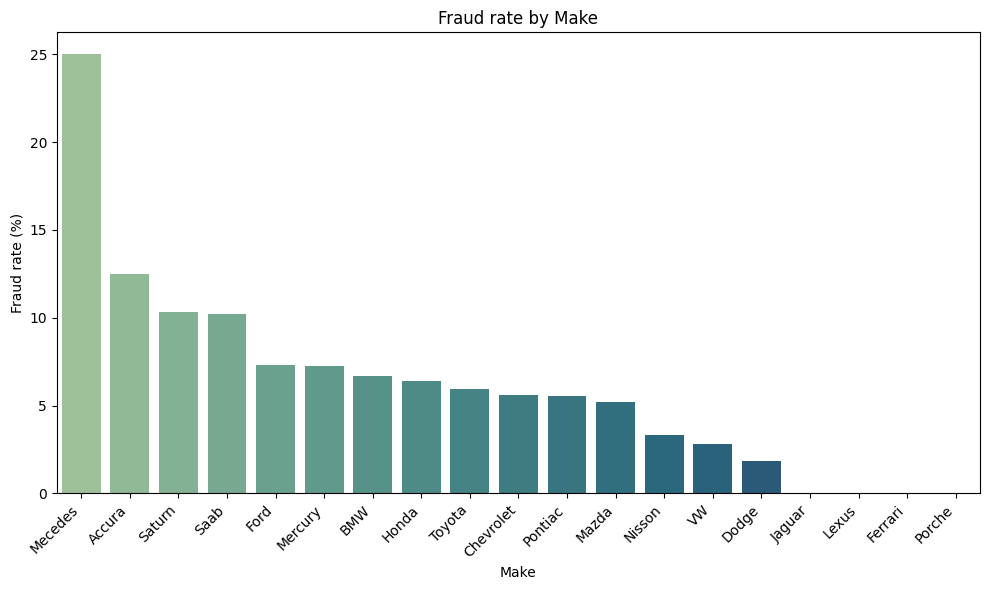

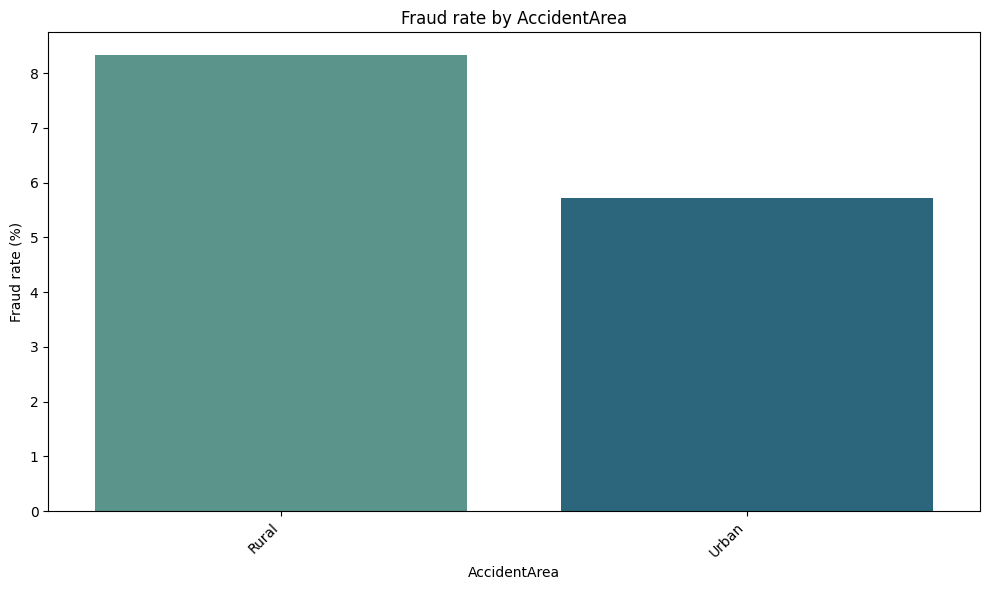

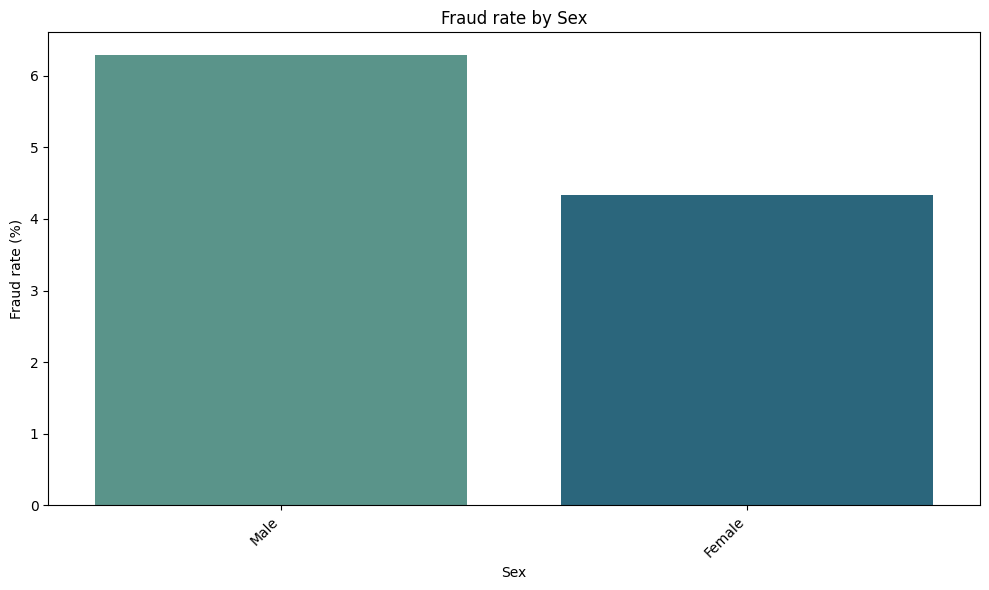

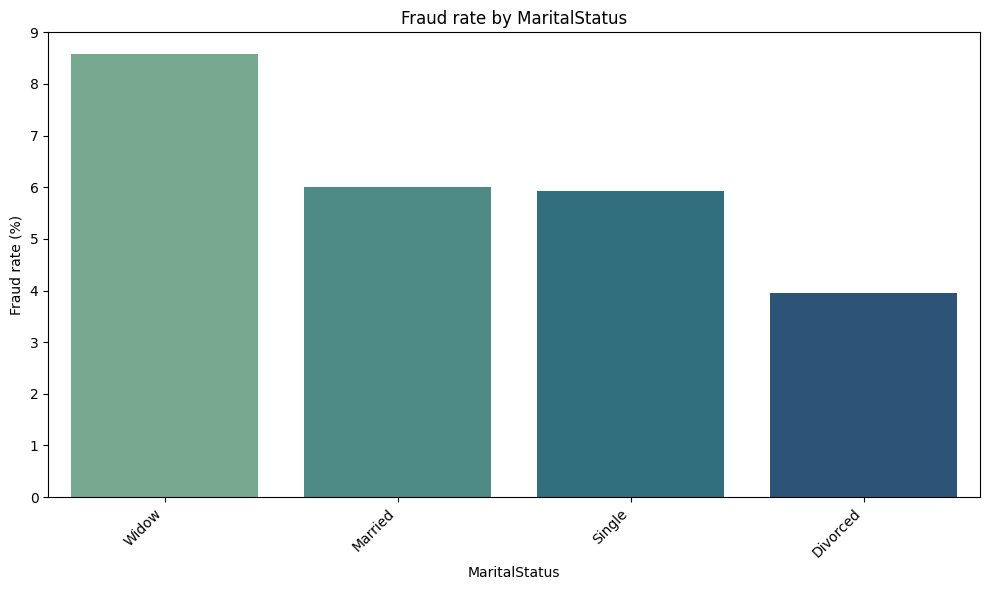

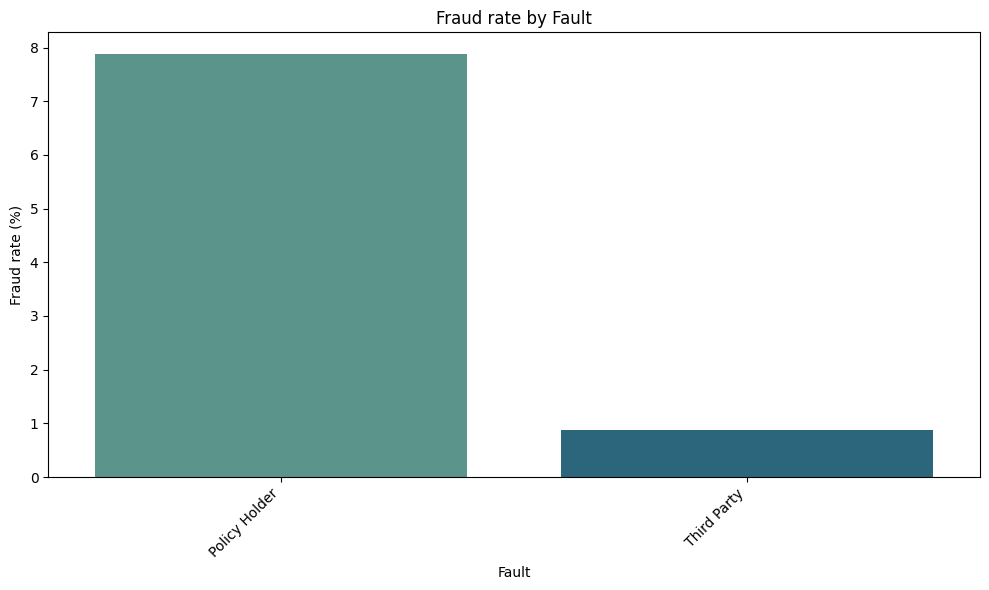

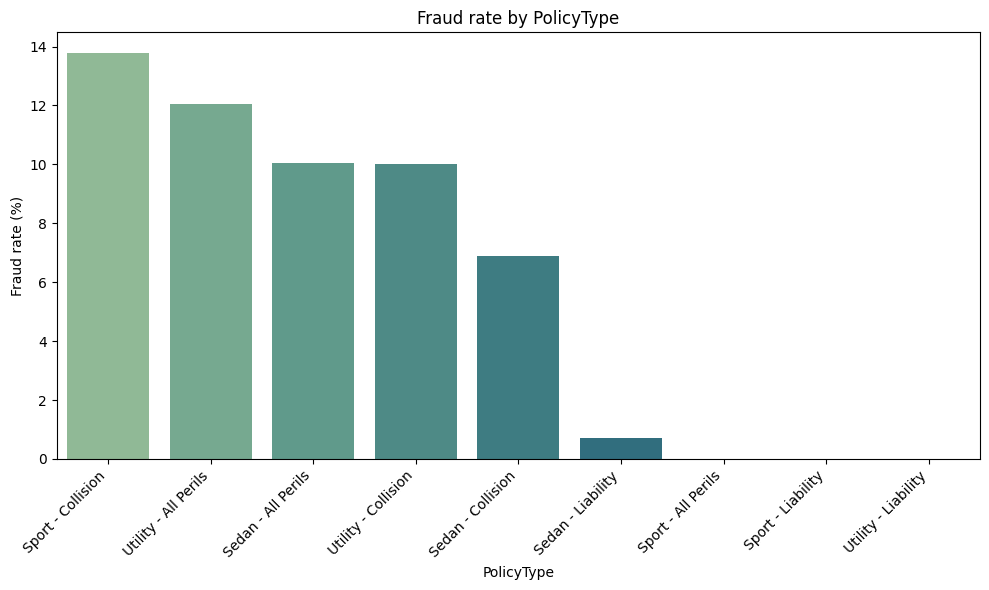

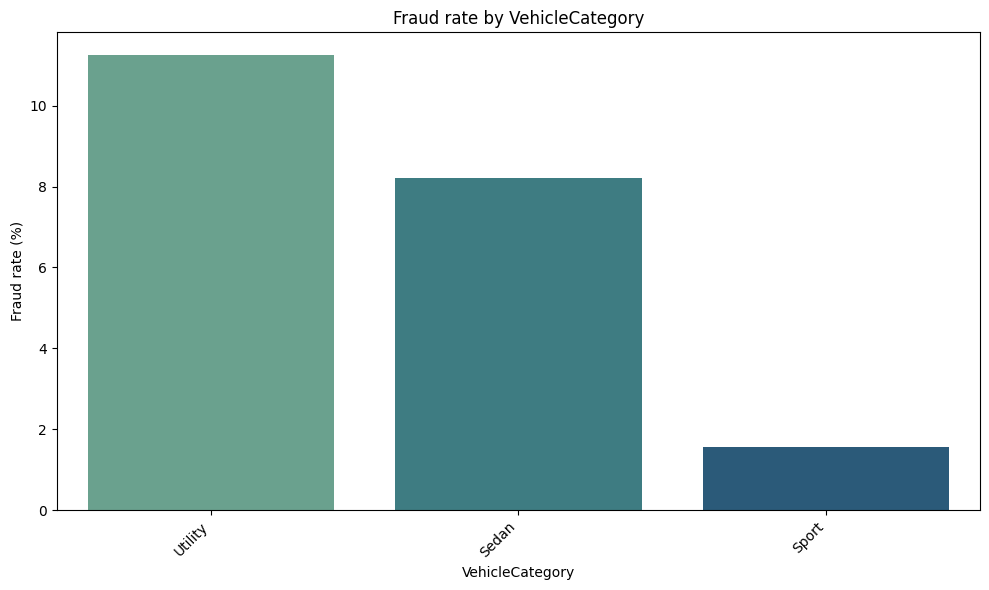

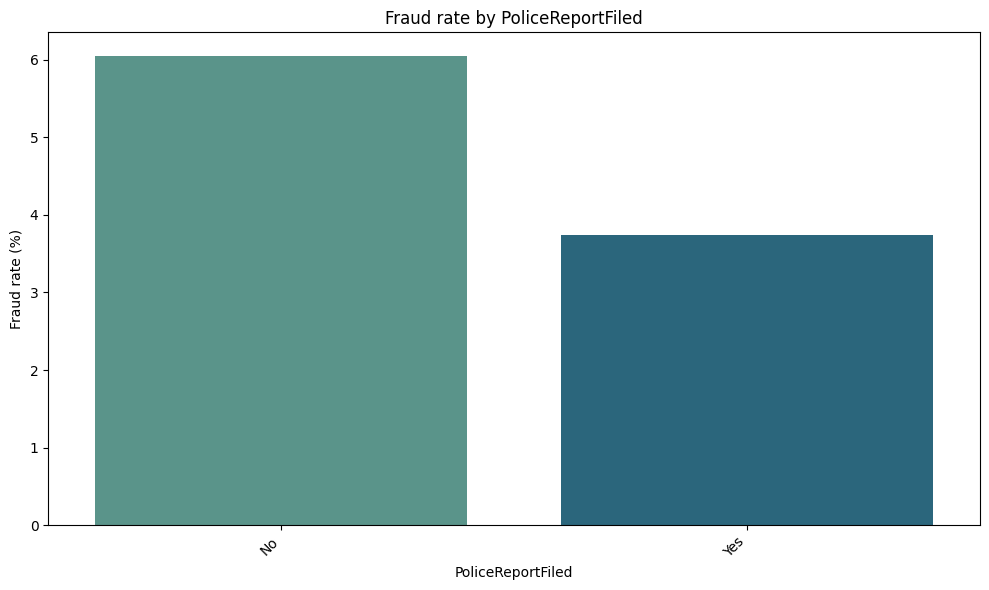

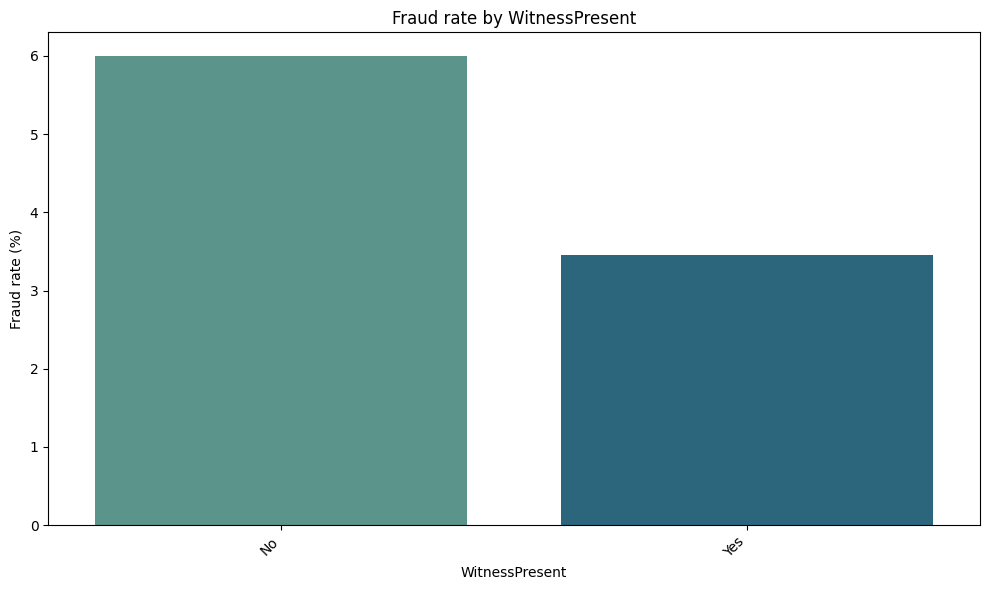

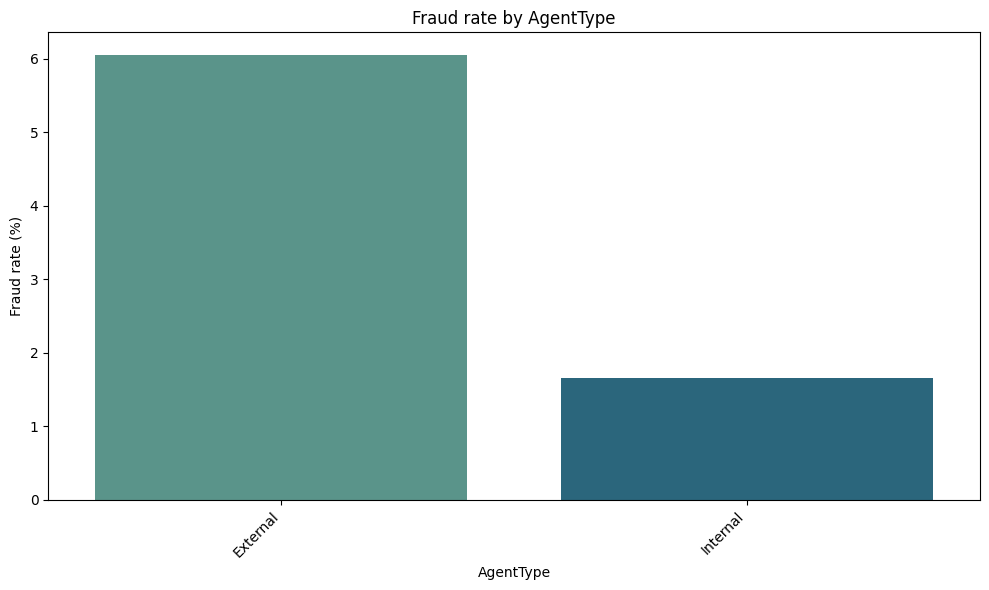

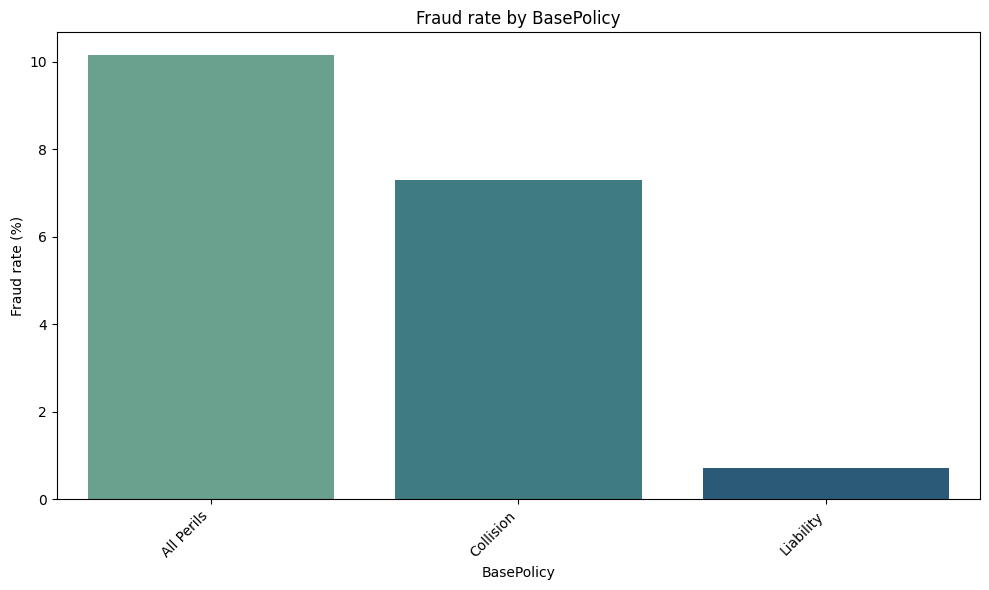

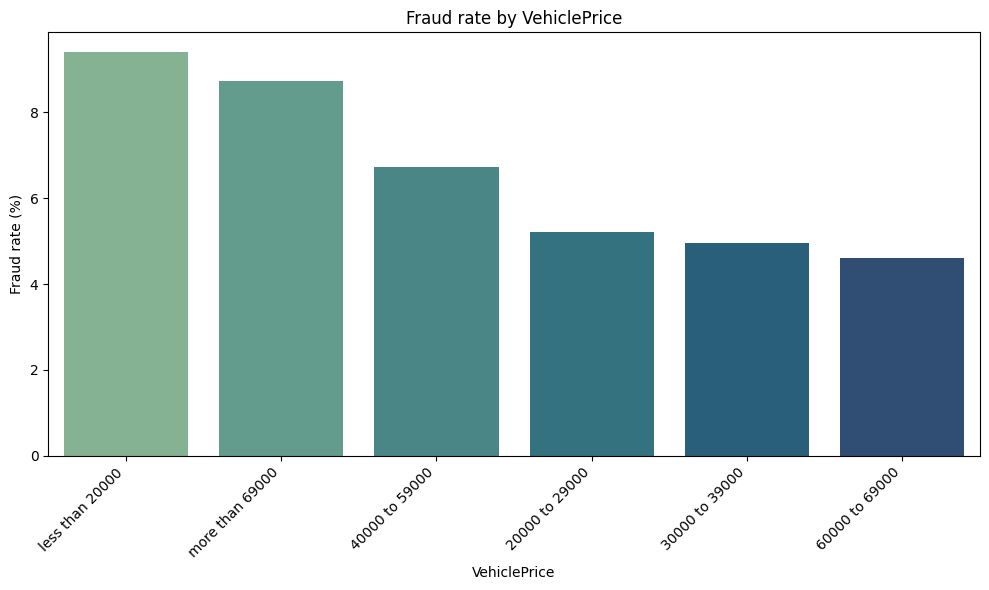

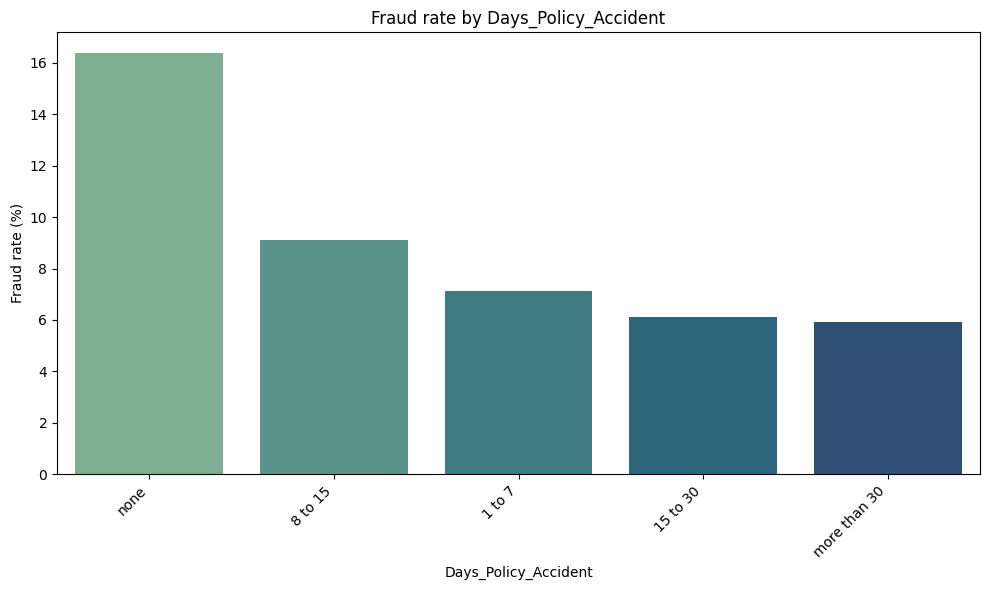

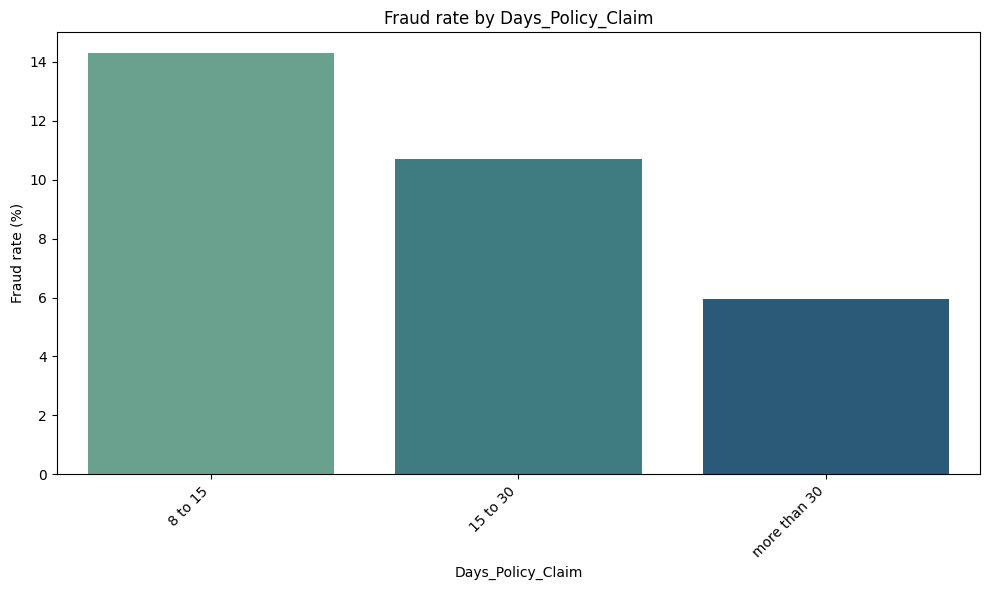

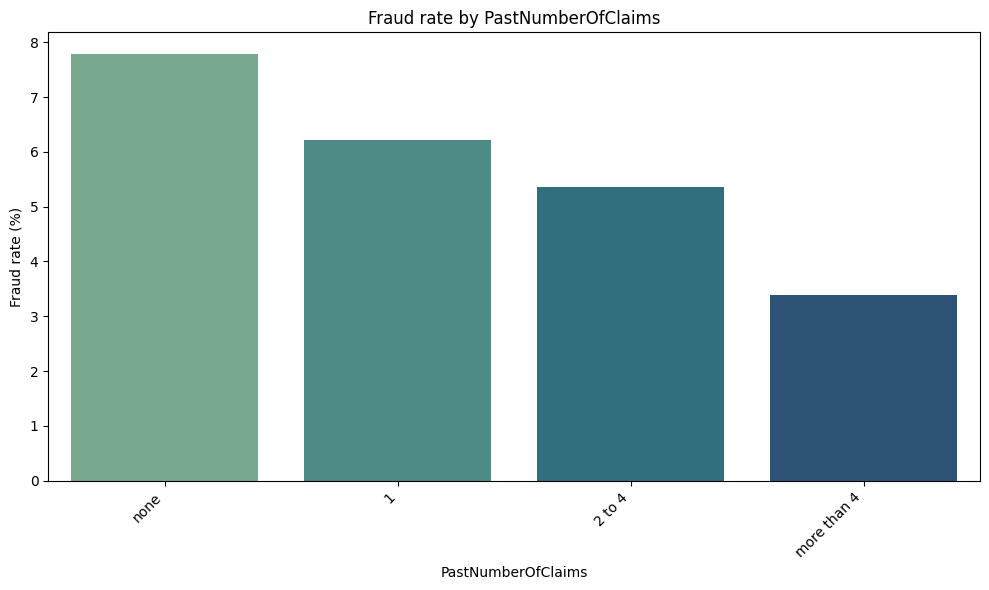

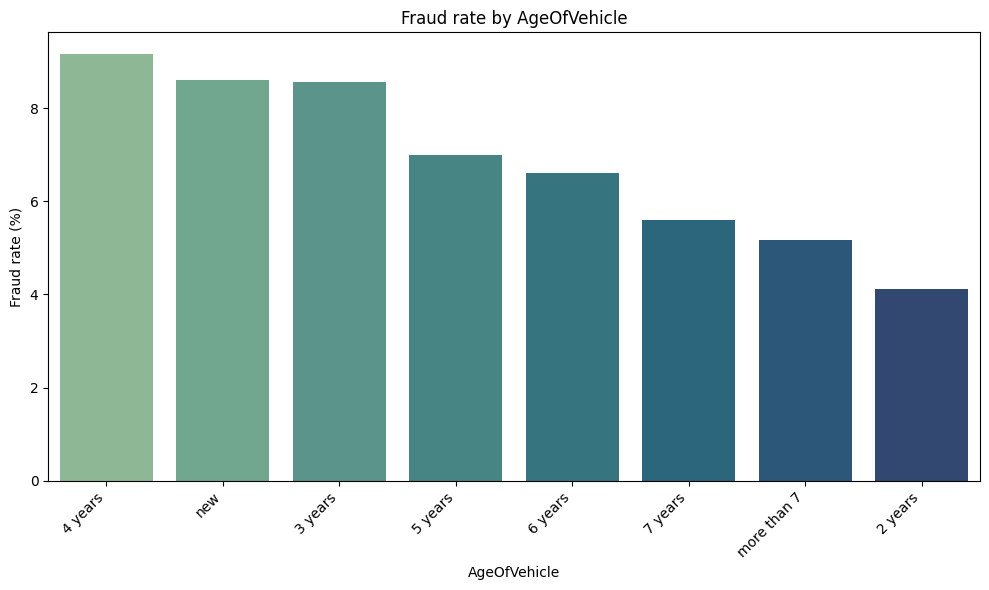

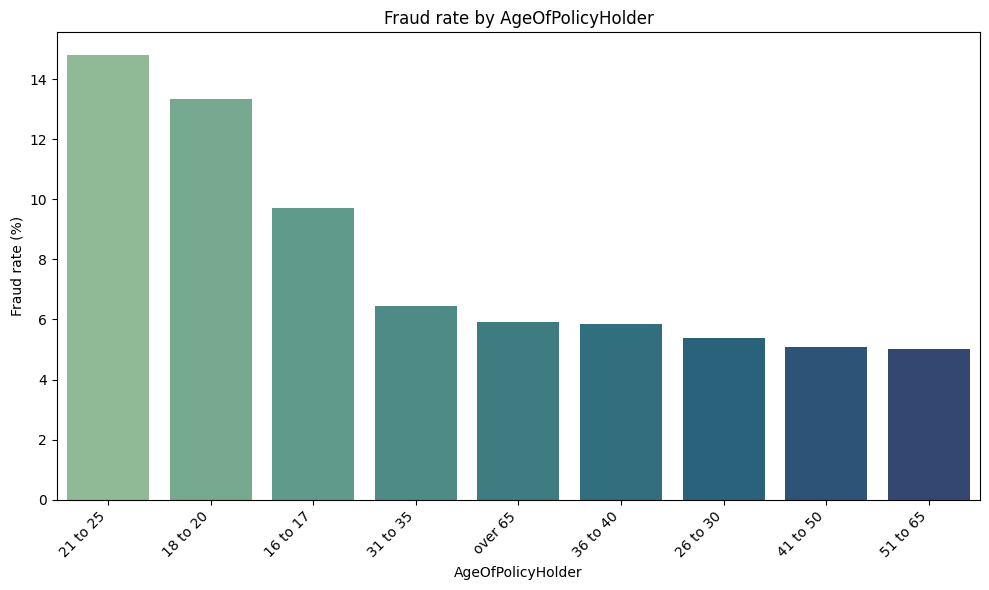

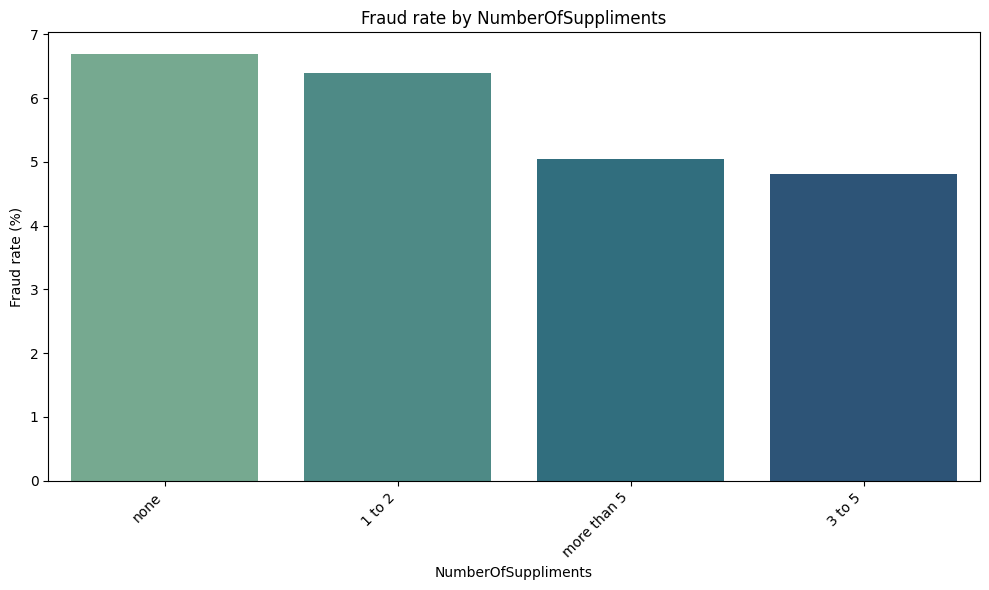

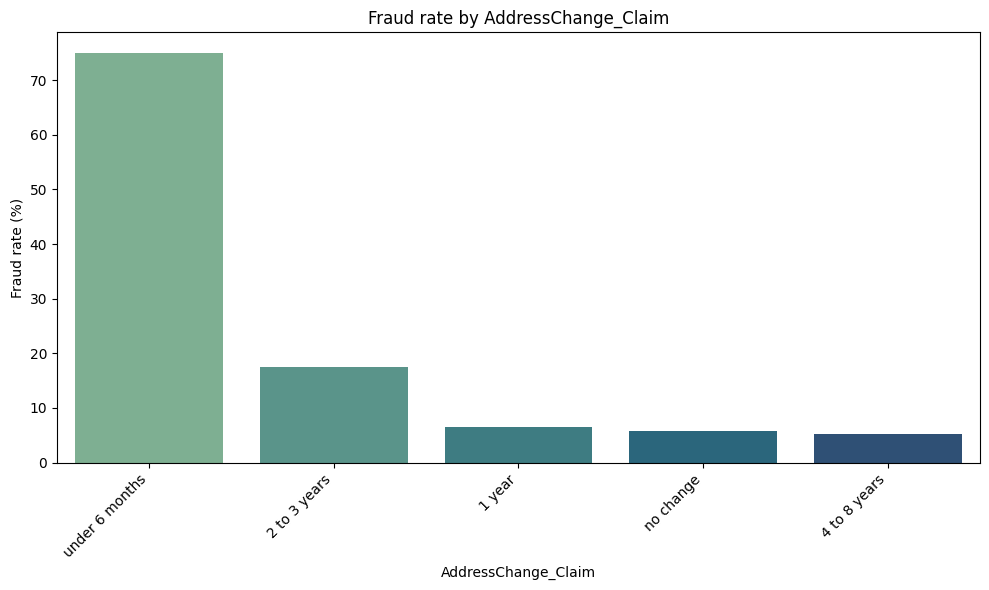

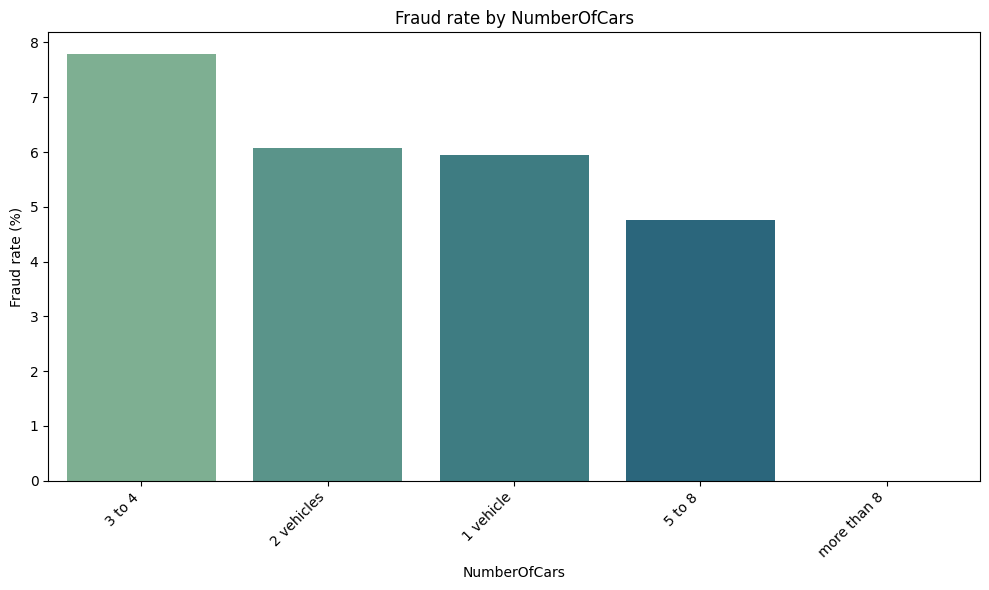

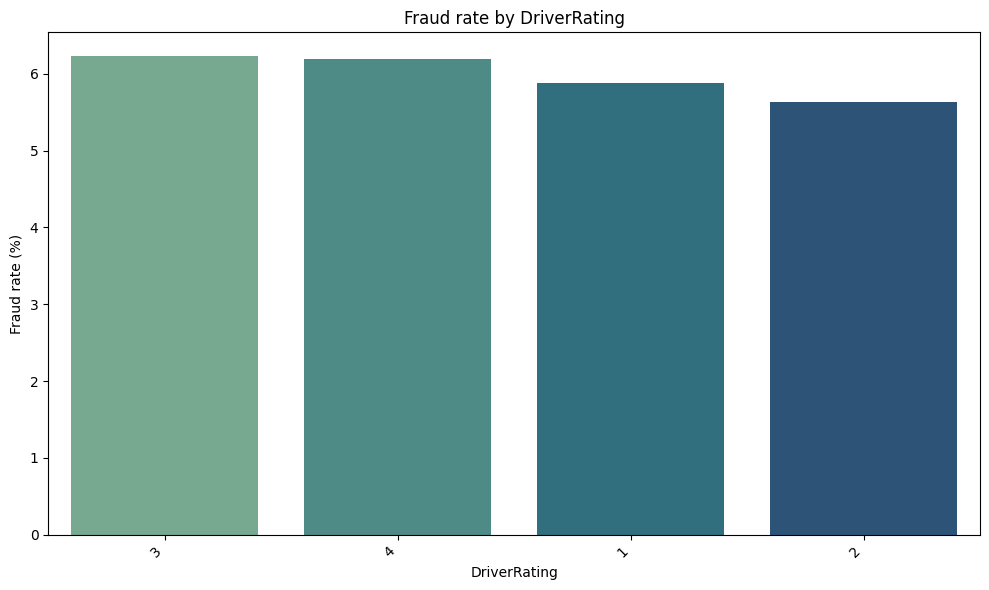

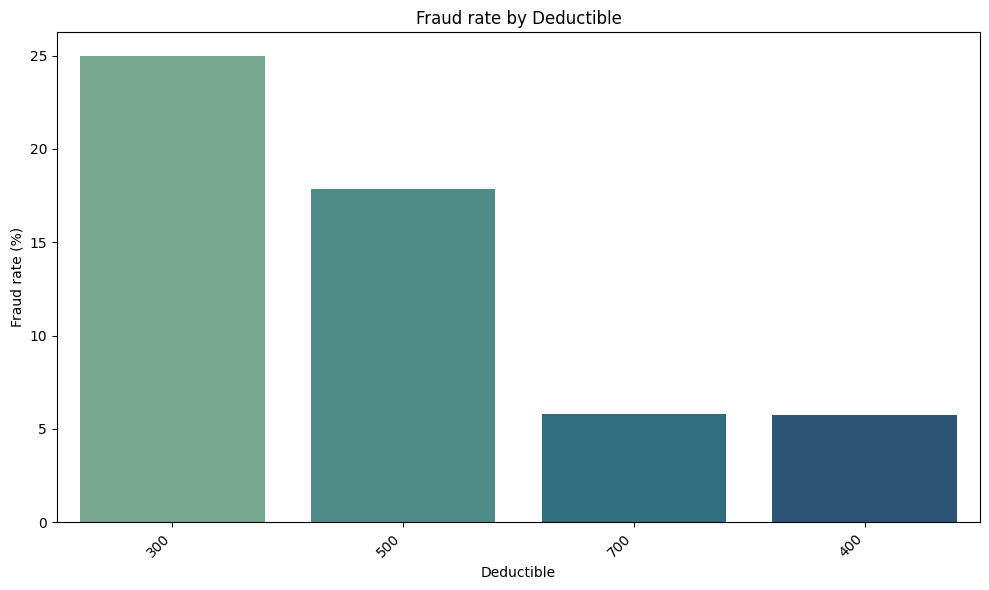

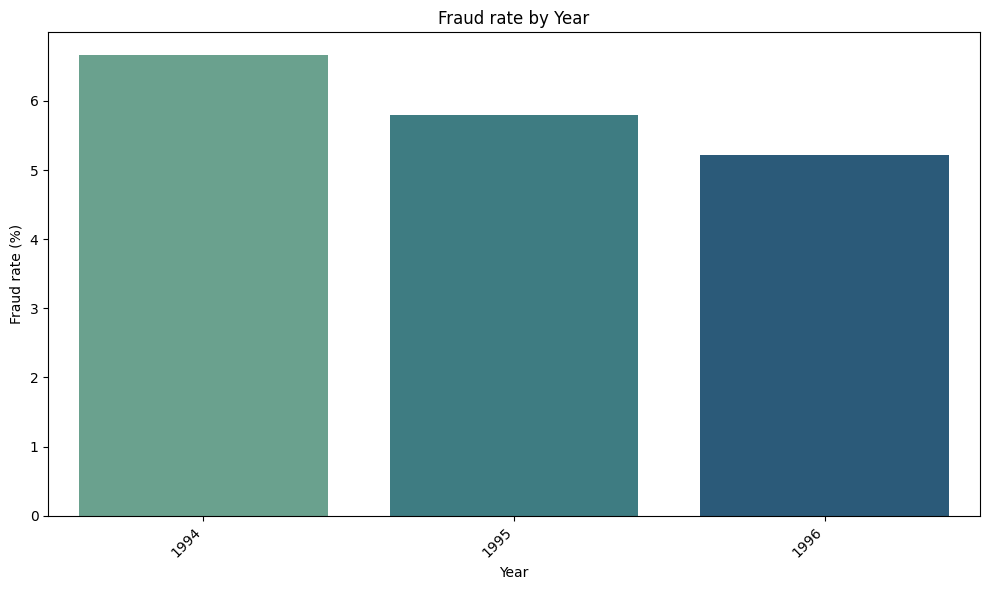

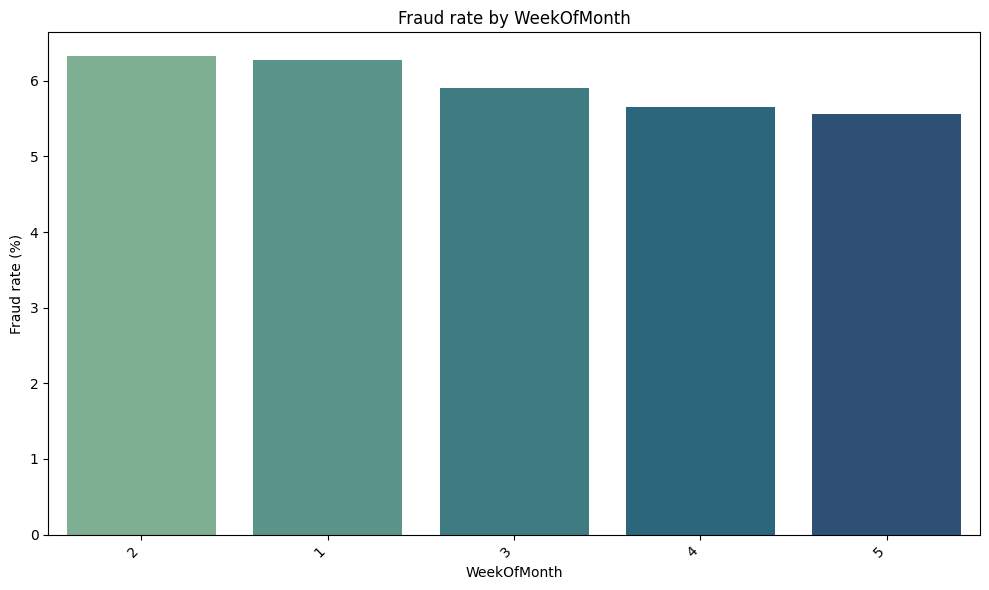

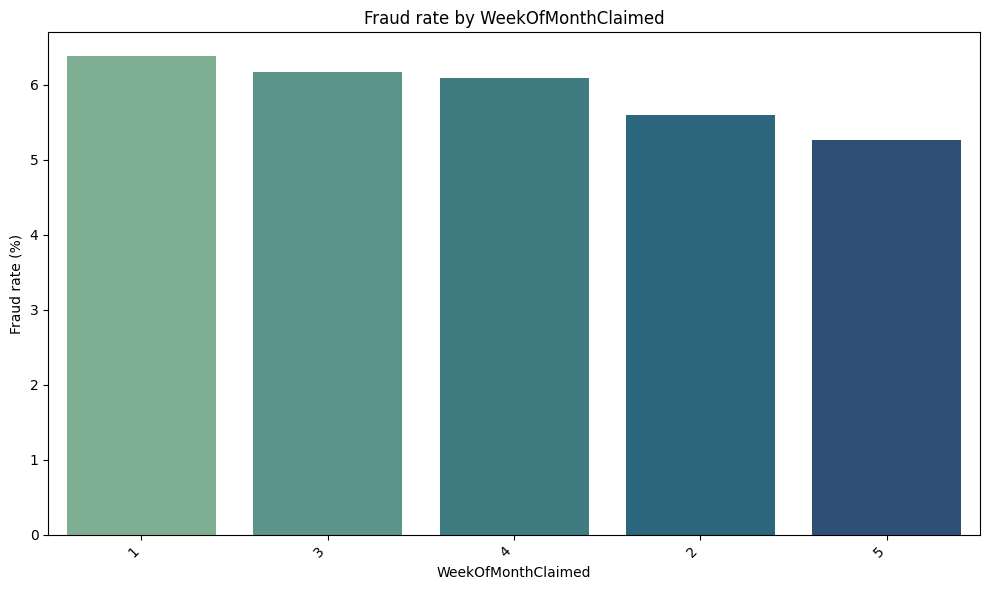

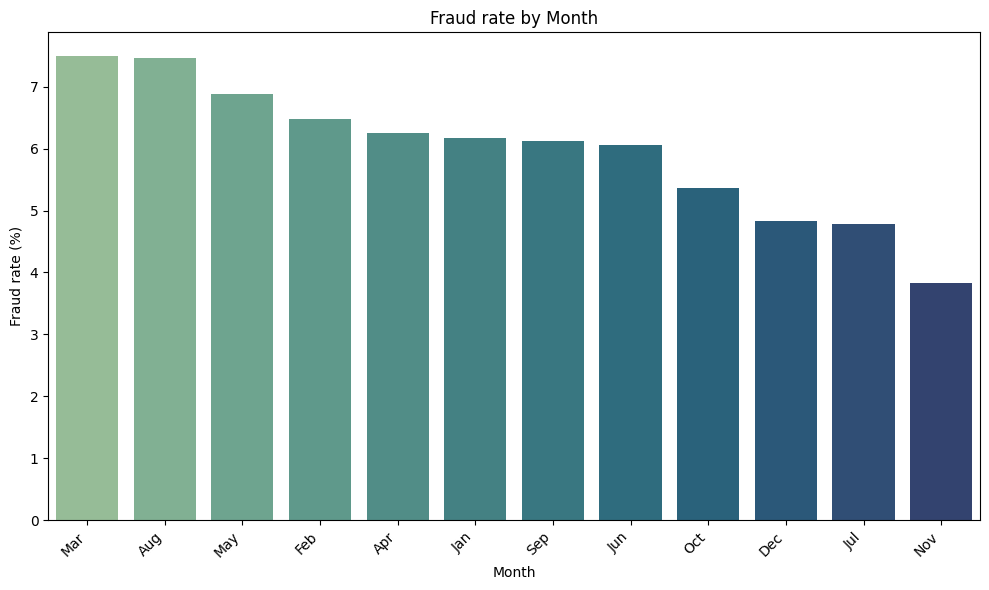

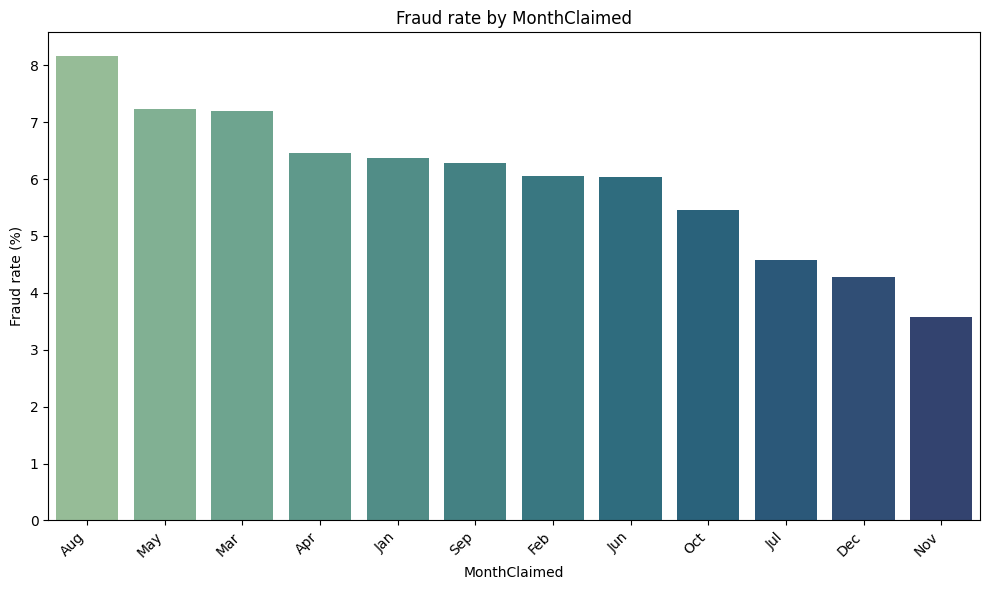

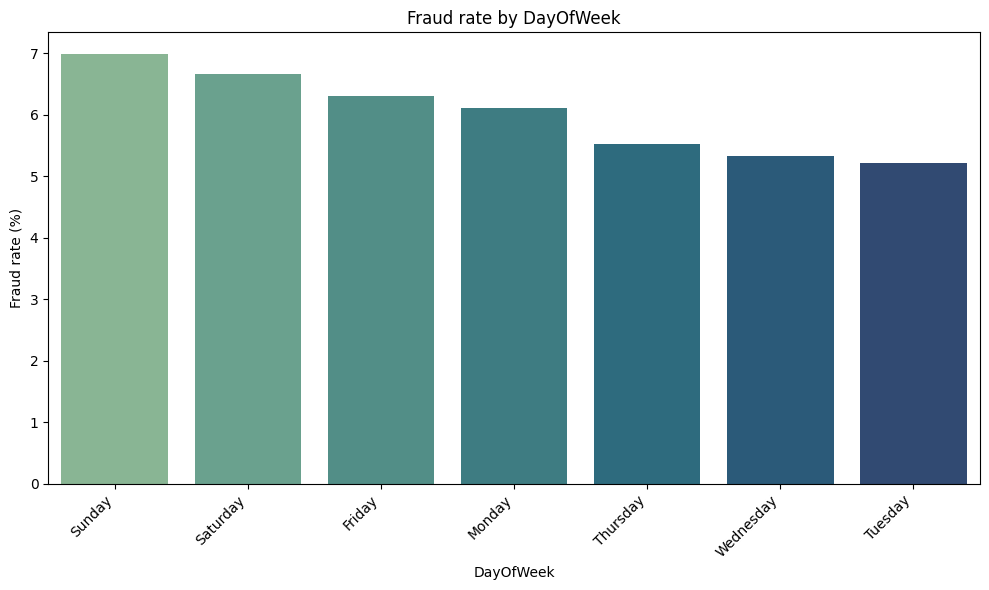

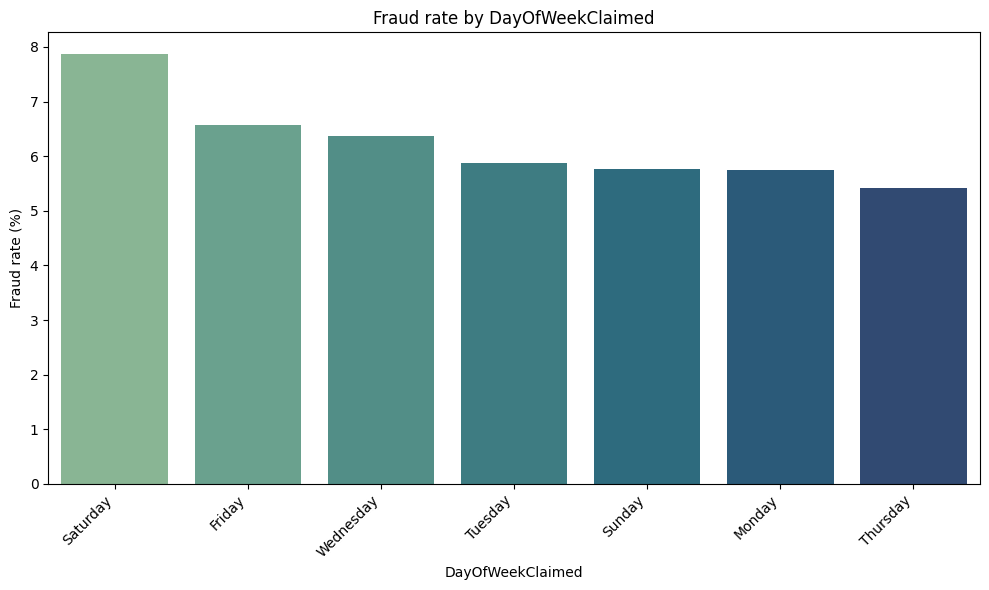

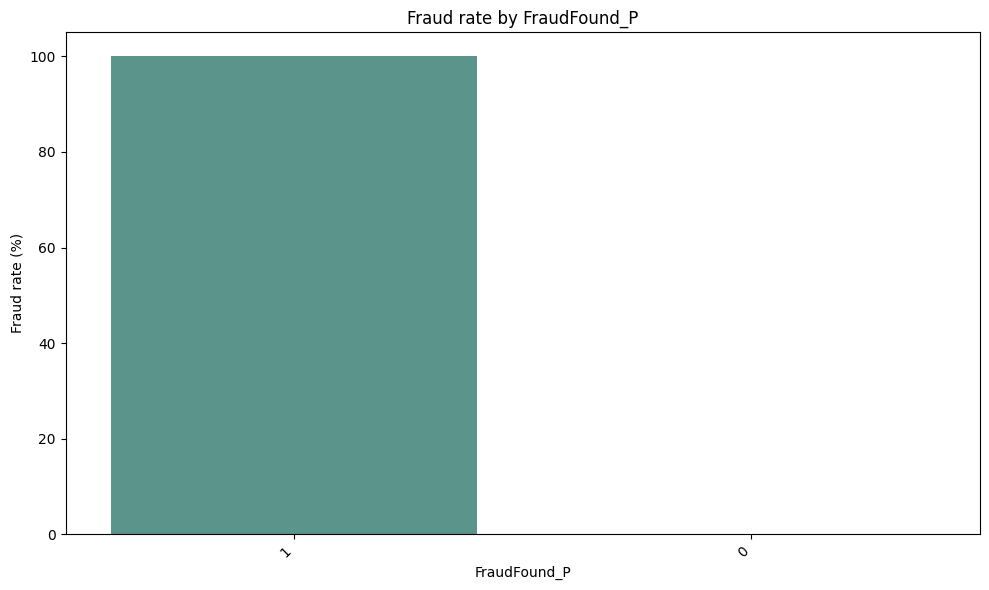

In [30]:
# create fraud rate bar plots
for feature in eda_features:
    tmp = pd.crosstab(df[feature], df["FraudFound_P"], normalize="index") * 100

    # pick the fraud/positive column name (adjust if needed)
    fraud_col = 1 if 1 in tmp.columns else "Y" if "Y" in tmp.columns else "Yes"
    rate = tmp[fraud_col].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=rate.index, y=rate.values, palette="crest", order=rate.index)
    plt.title(f"Fraud rate by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Fraud rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Fraud rate insights:

*  These plots more clearly identify categories with higher fraud rates.
    *  AddressChange_Claim: the 'under 6 month' category has > 70% fraud rate, making it highly seperatible comparably.
    *  Deductible: the $300 category has about a 25% fraud rate while the $500 categories has about 18% fraud rate.
    *  Make: 'Mercedes' has the highest fraud rate of 25%, followed by 'Accura' with about 12.5%
    *  Days_Policy_Accident: 'none' category had > 16% fraud rate
    *  AgeOfPolicyHolder: the '21 to 25' category had ~15% fraud rate, followed by the '18 to 20' category with ~13%.
    *  Days_Policy_Claim: the '8 to 15' category had > 14% fraud rate.
    *  PolicyType: the 'Sports-Collison' category had ~14% fraud rate, followed by 'Utility-all perils' with 12% fraud rate.
    *  VehicleCategory: the 'Utility' category showed ~12% fraud rate.
    *  These particular categories within these features appear to have have predictive value.


### Effect size: Lift  (relative likelihood of fraud over the baseline)

In [31]:
# establish baseline
#target = "FraudFound_P"
#df[target] = df[target].copy().astype('int64')
baseline = df[target].mean()
print(baseline)

0.0598612101952137


In [32]:
# separate special features
specials = ['DriverRating', 'Deductible', 'Year', 'WeekOfMonth', 'WeekOfMonthClaimed']
eda_features_lift = [c for c in eda_features if c not in specials]


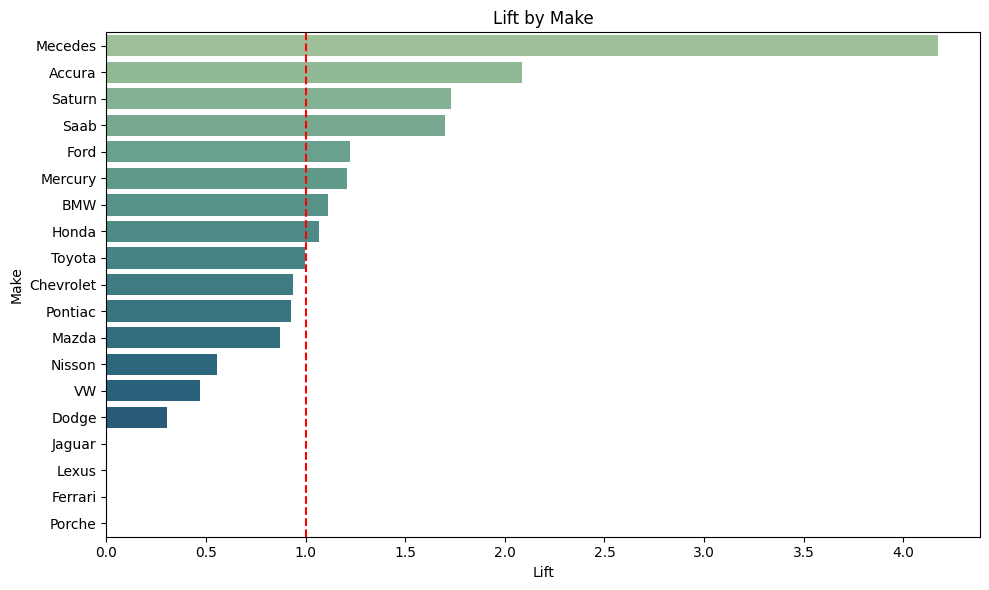

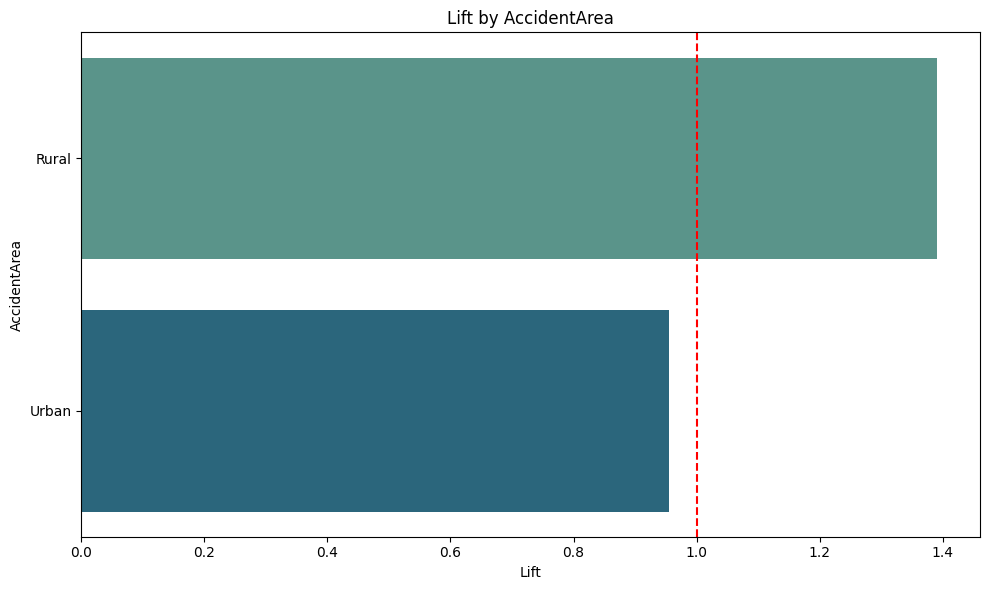

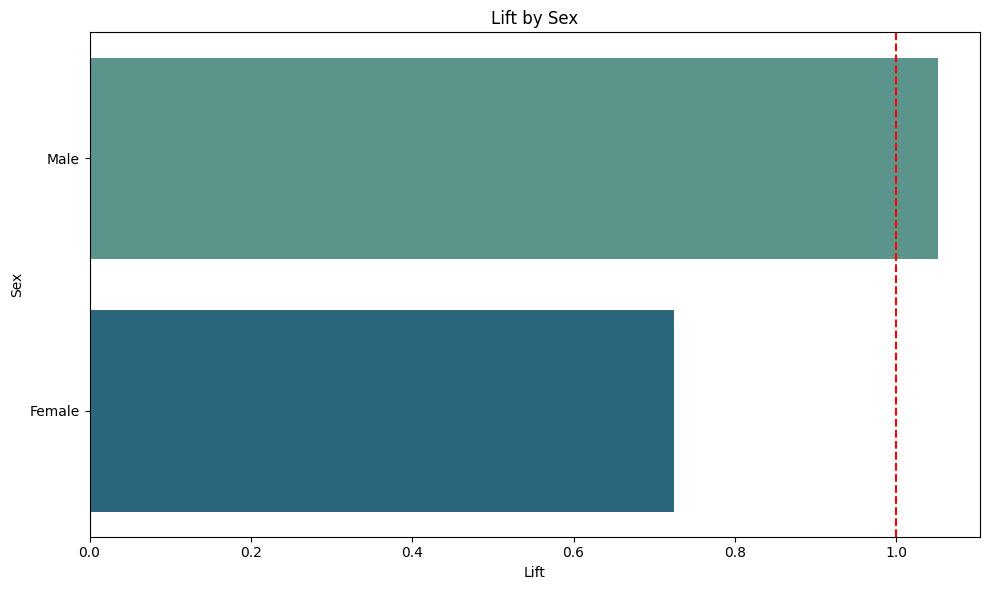

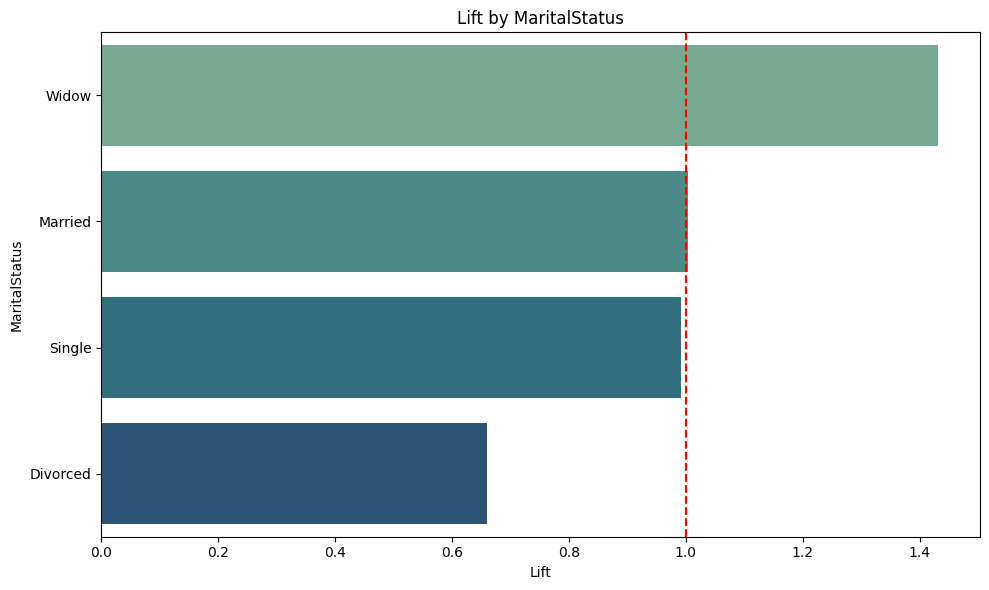

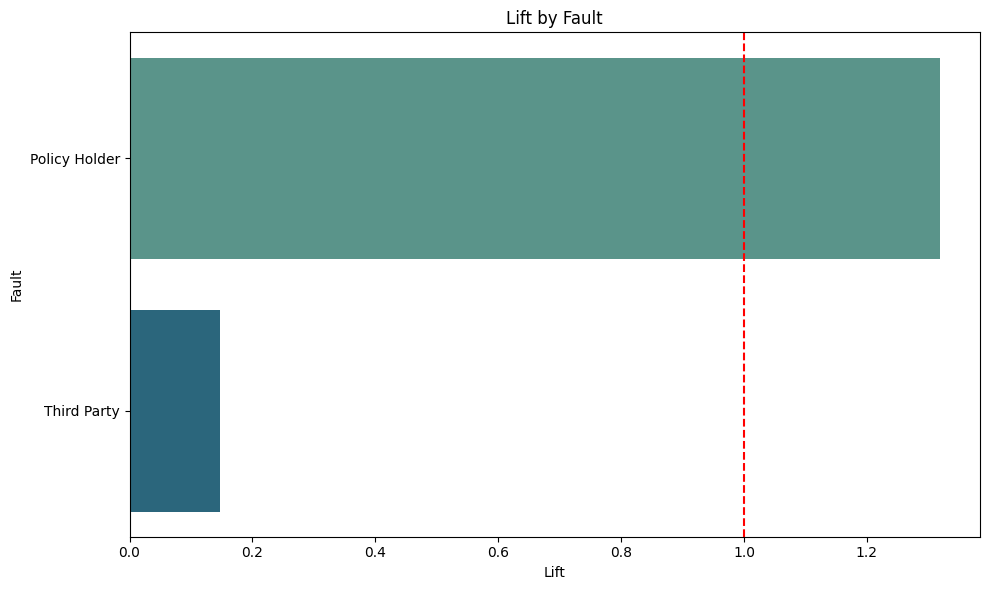

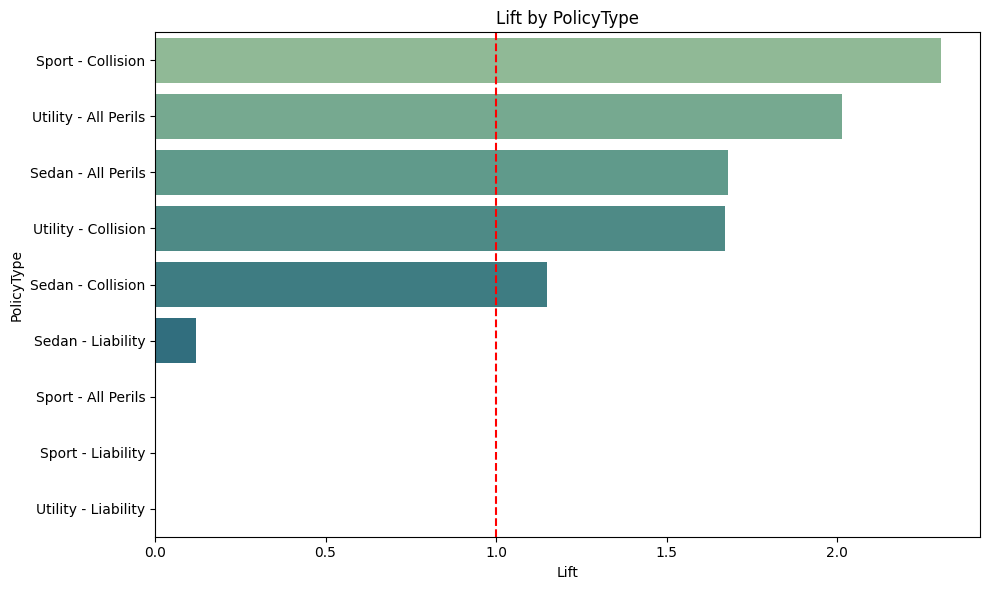

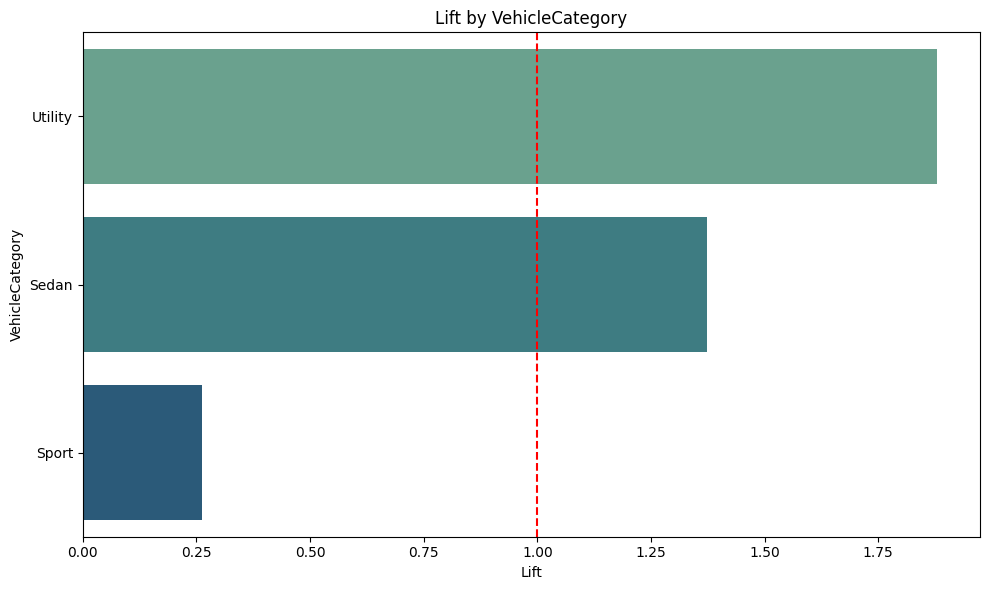

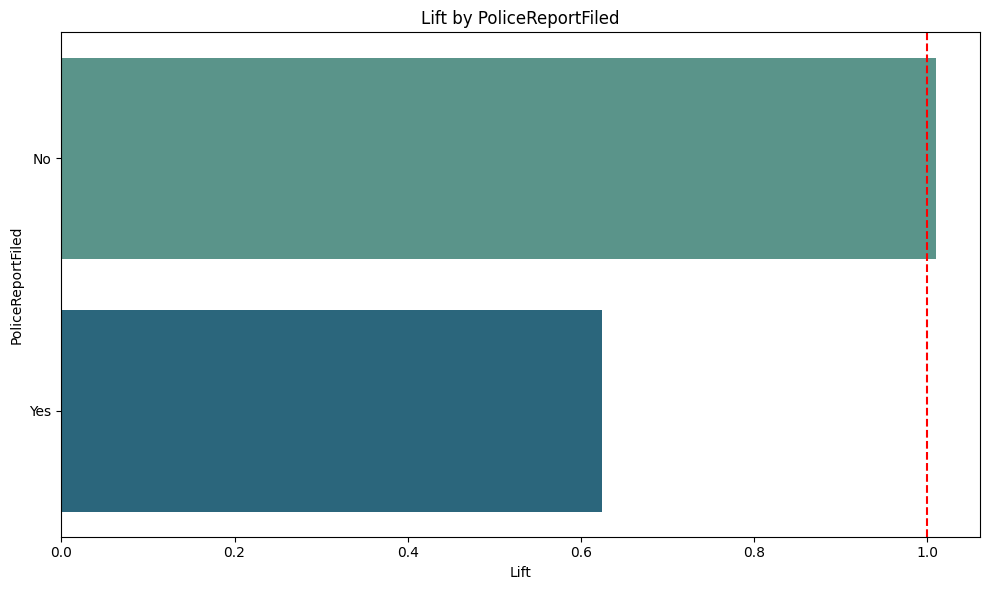

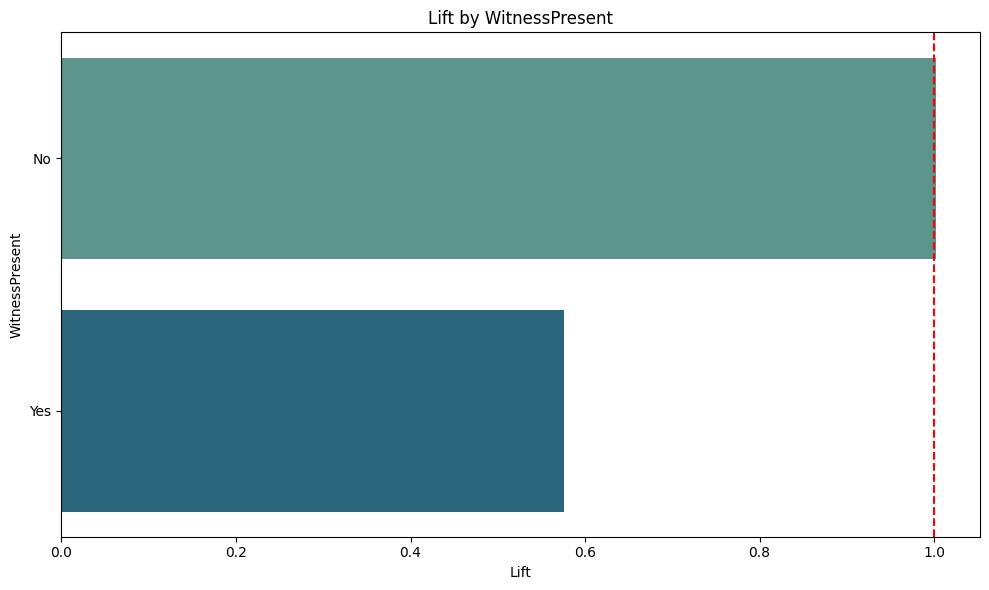

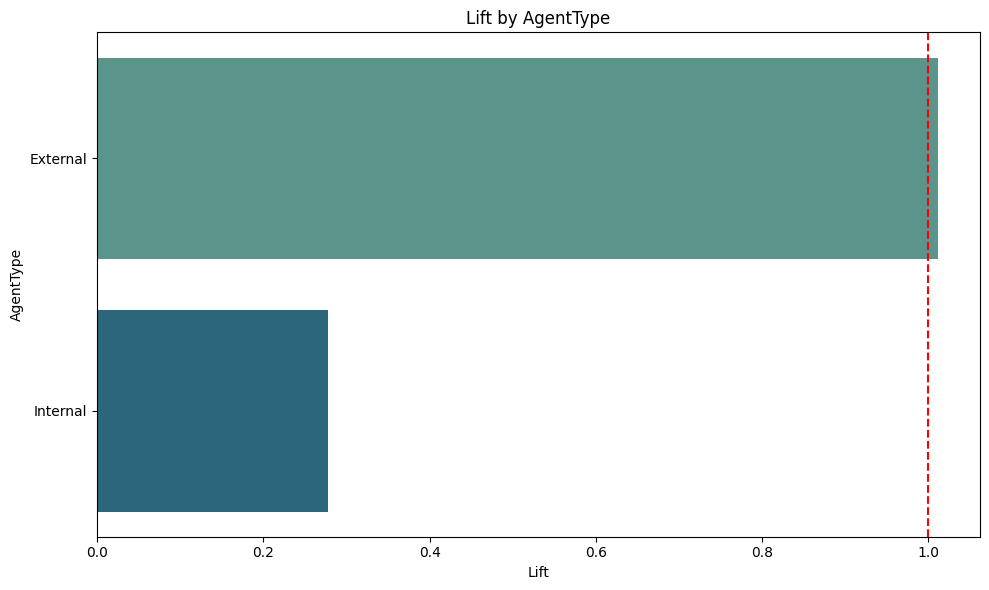

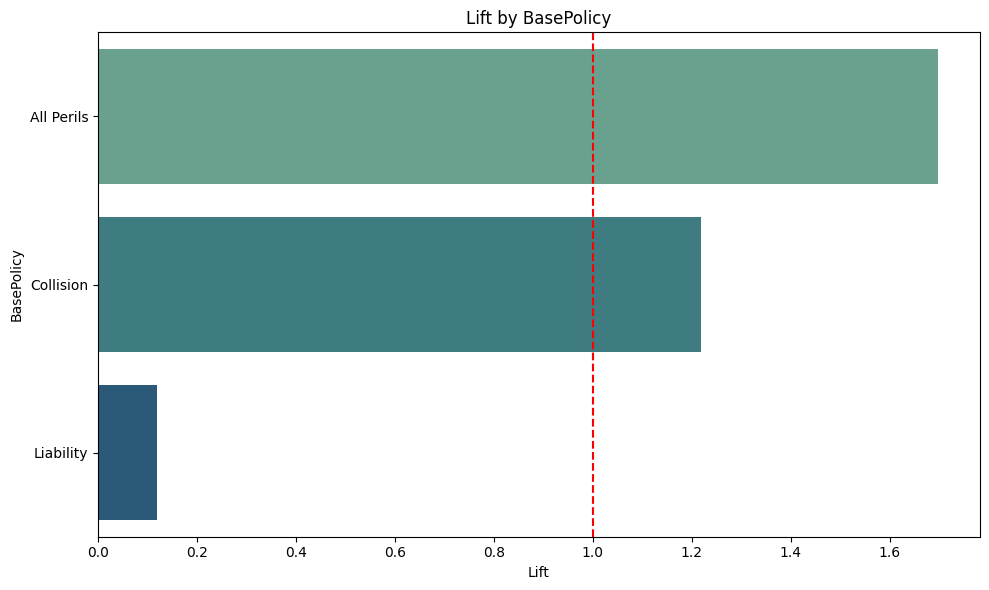

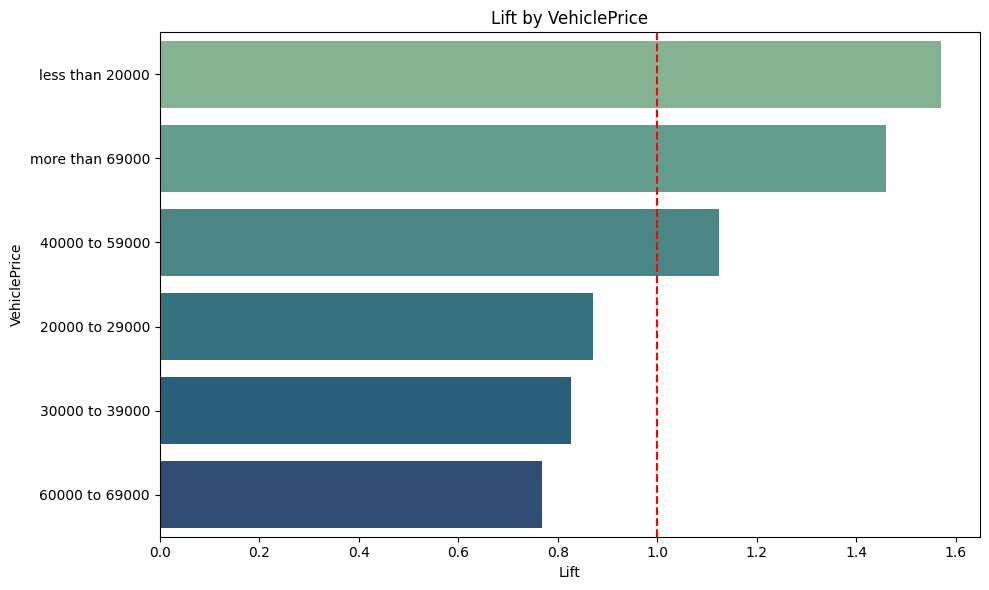

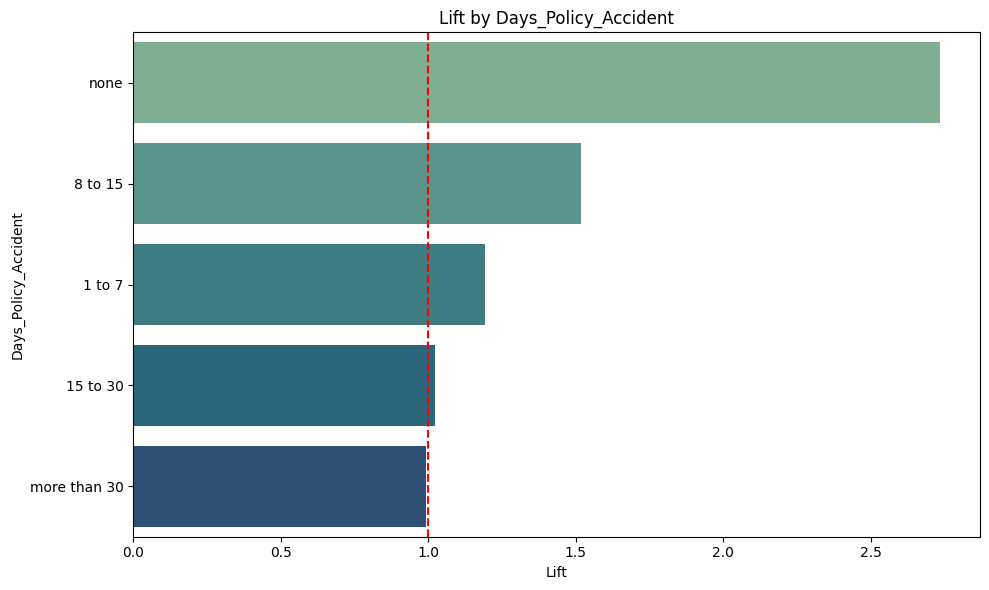

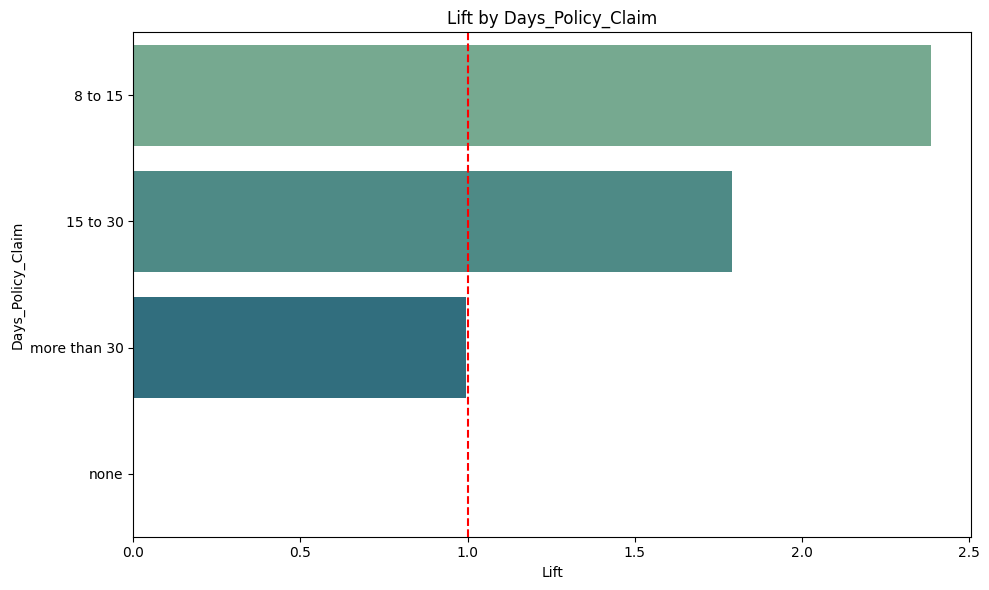

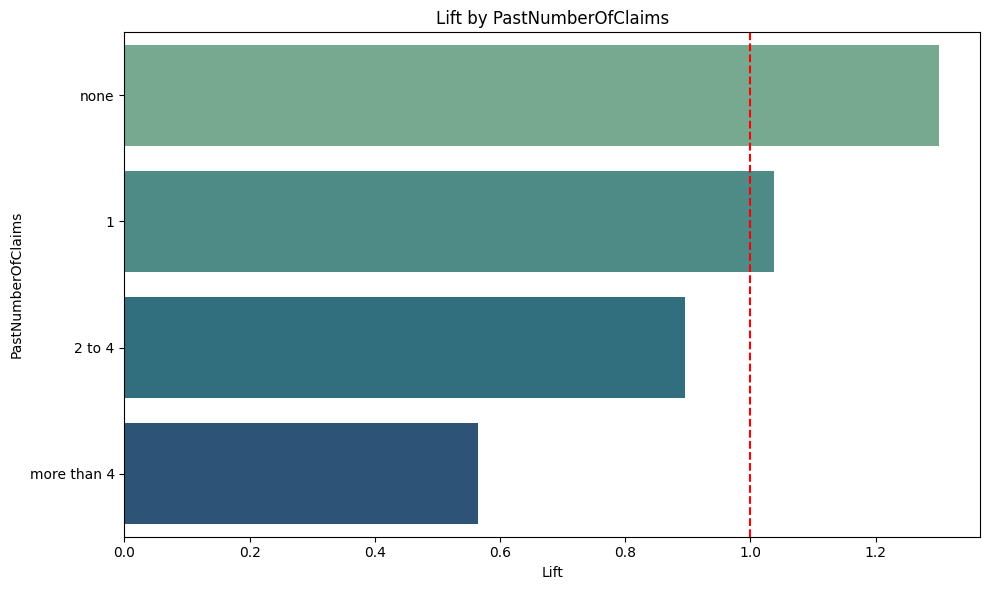

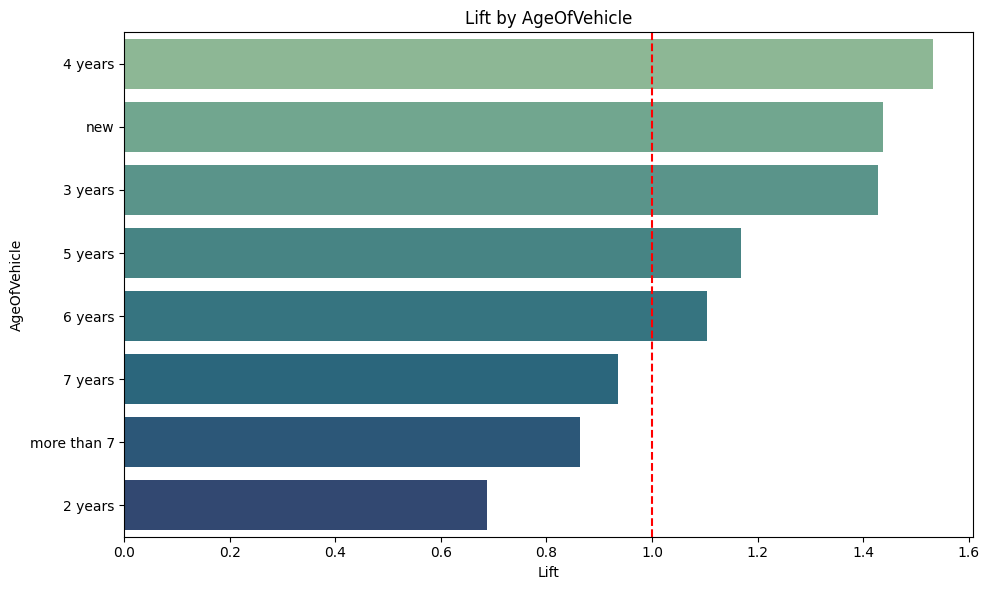

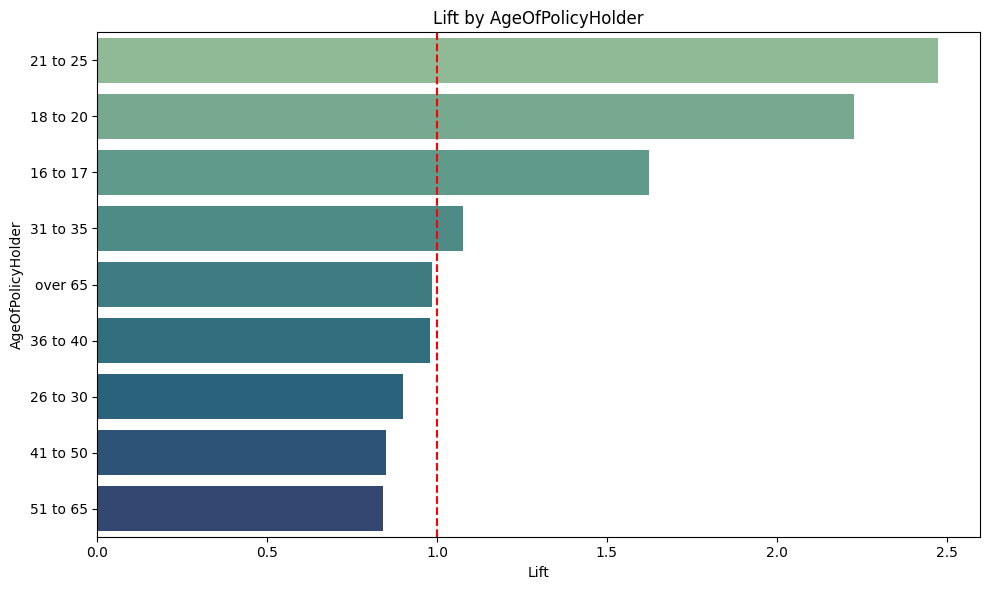

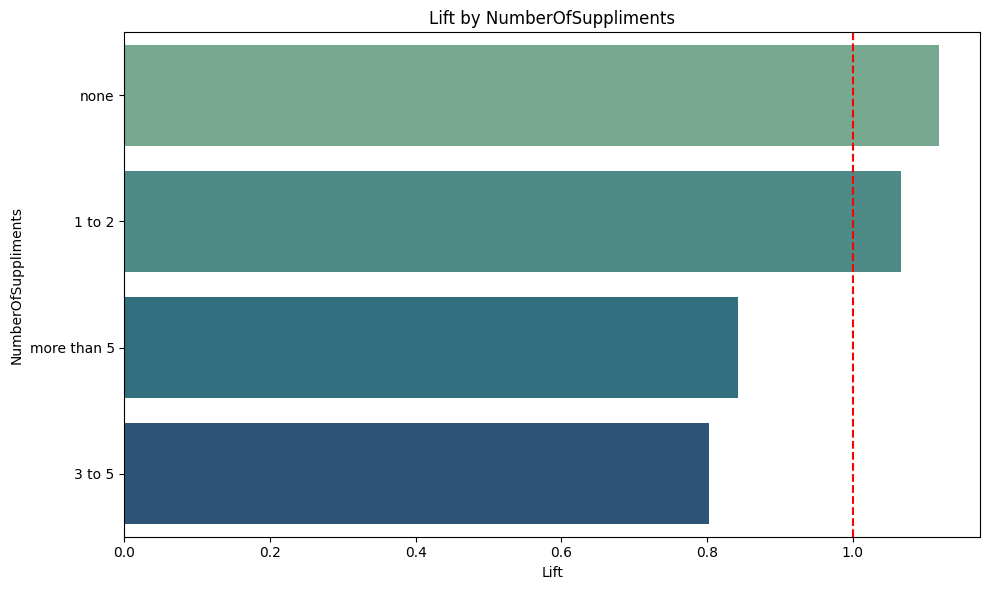

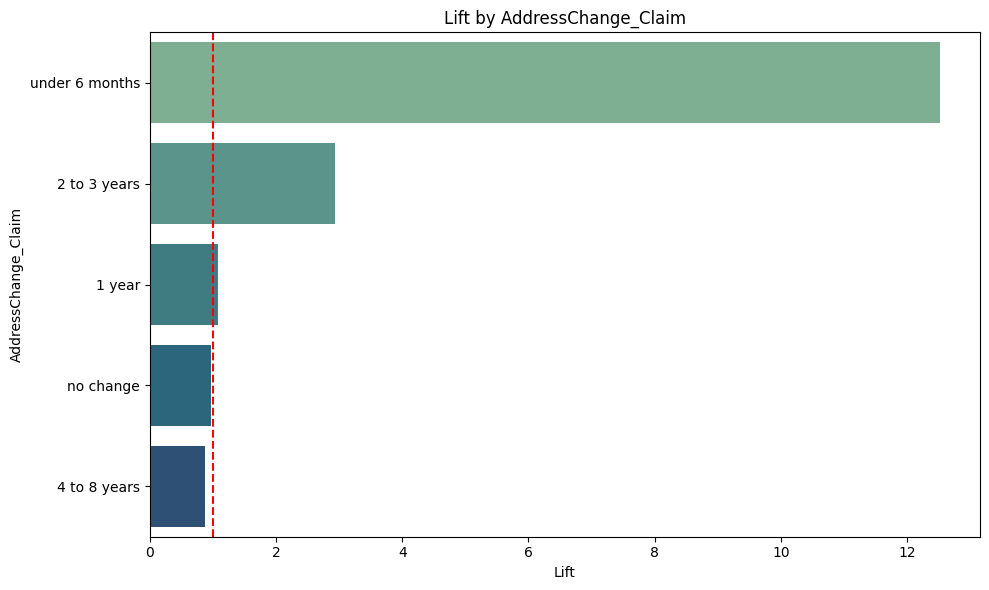

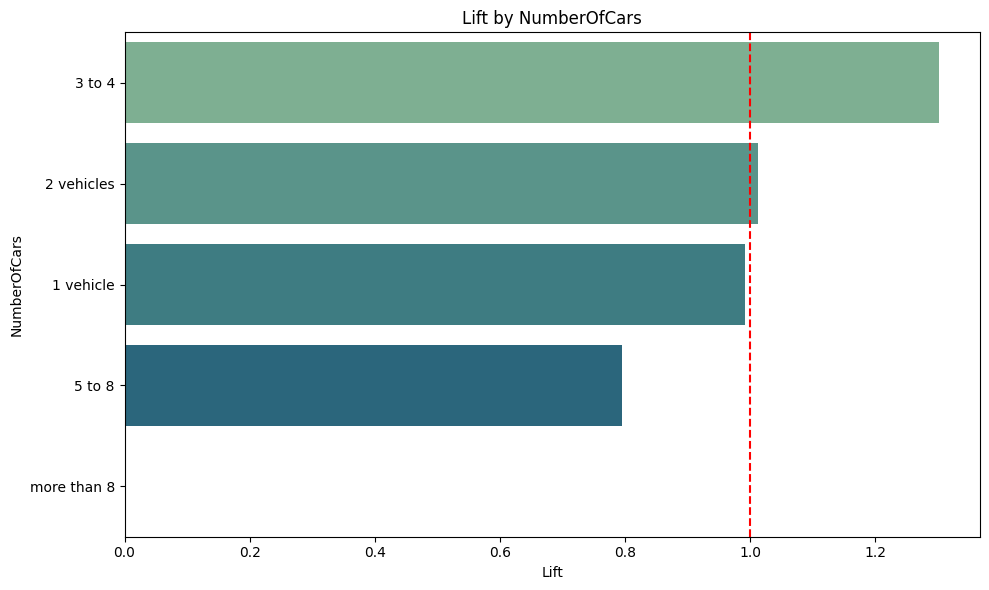

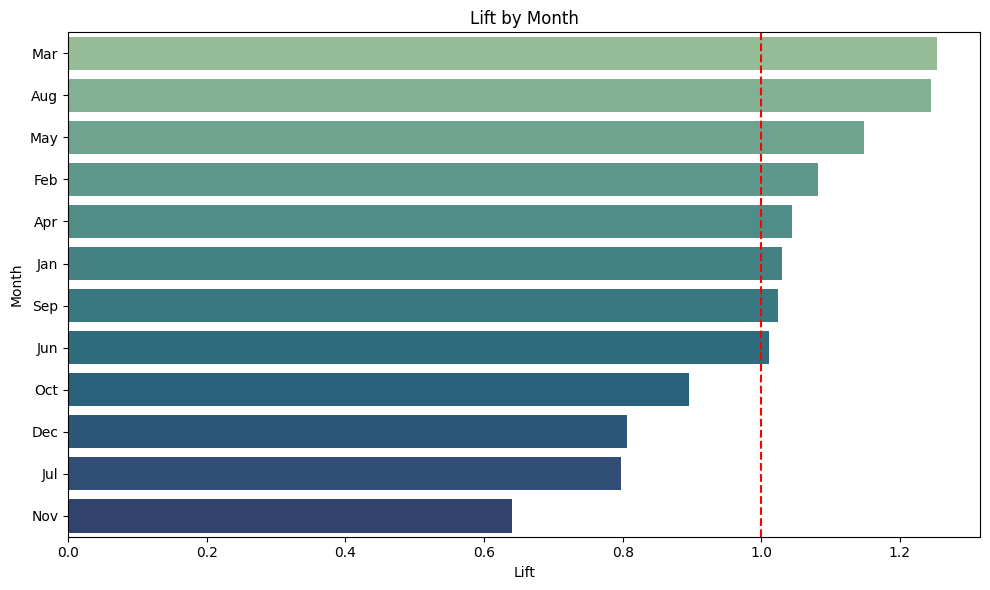

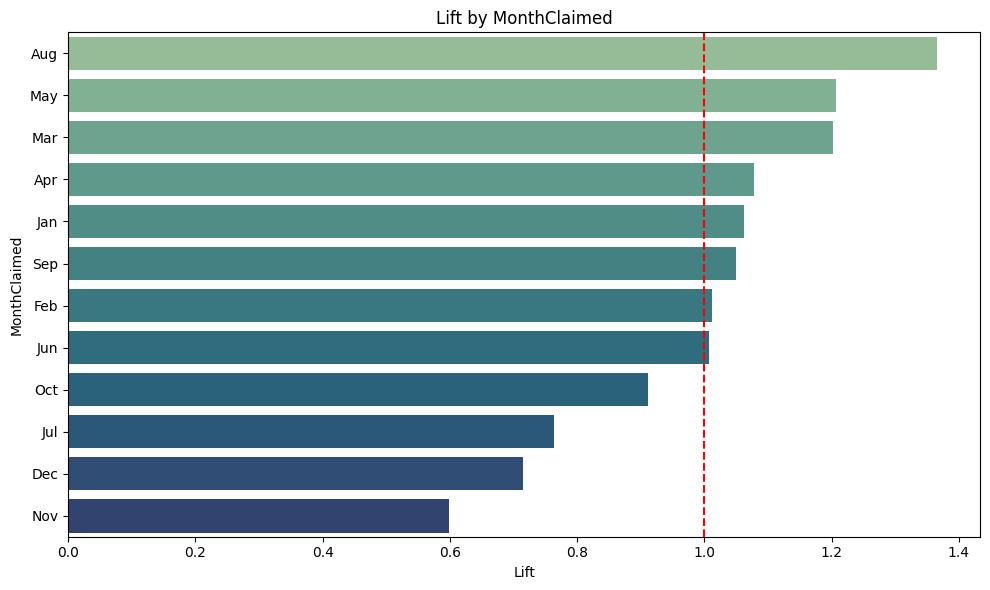

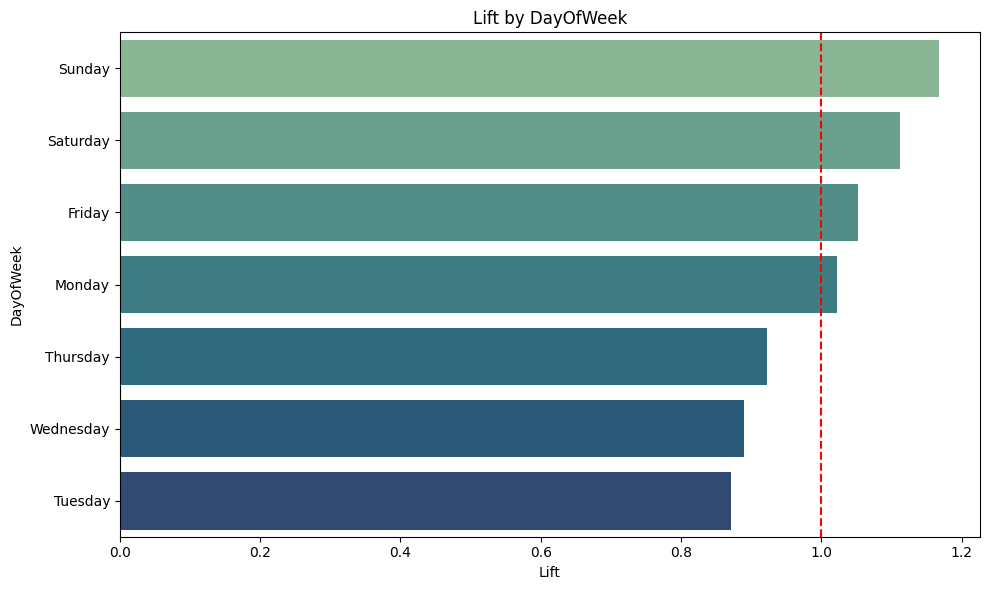

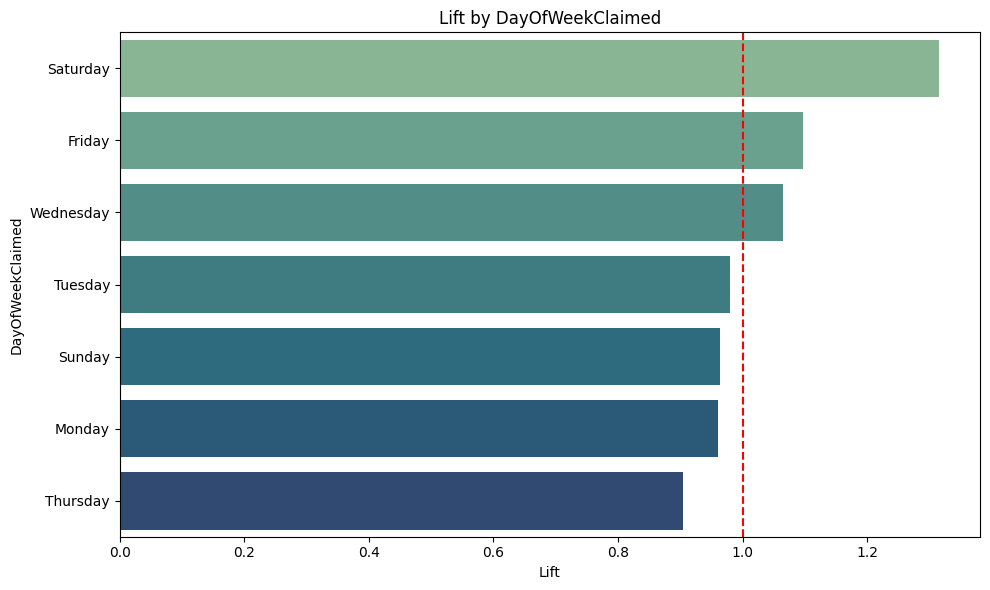

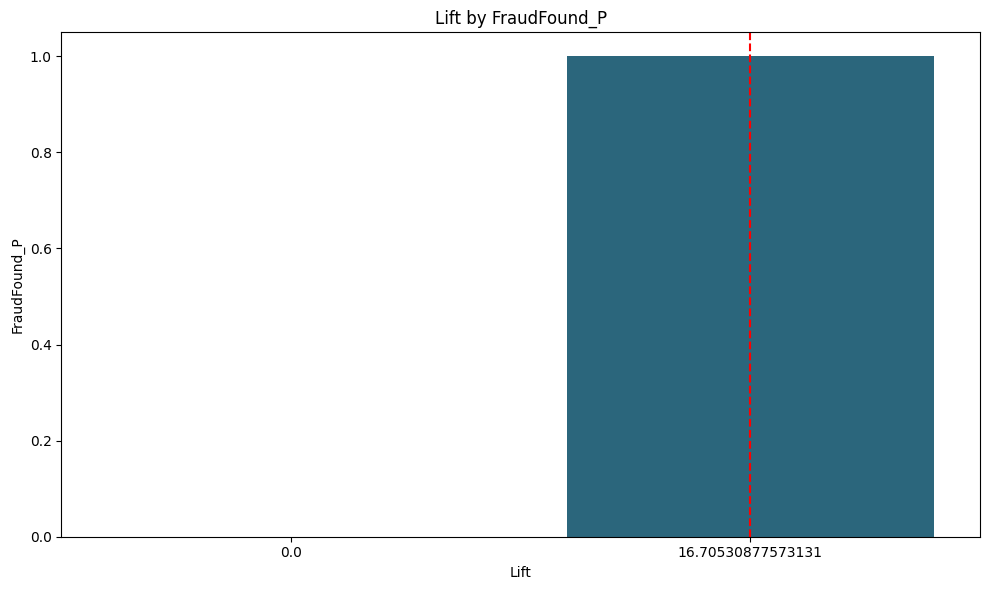

In [33]:
# create lift plots
for feature in eda_features_lift:
    rate = df.groupby(feature)[target].mean()
    lift = (rate/baseline).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=lift.values, y=lift.index.tolist(), palette='crest')
    ax.axvline(1, color='red', linestyle='--')
    plt.title(f'Lift by {feature}')
    plt.xlabel('Lift')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


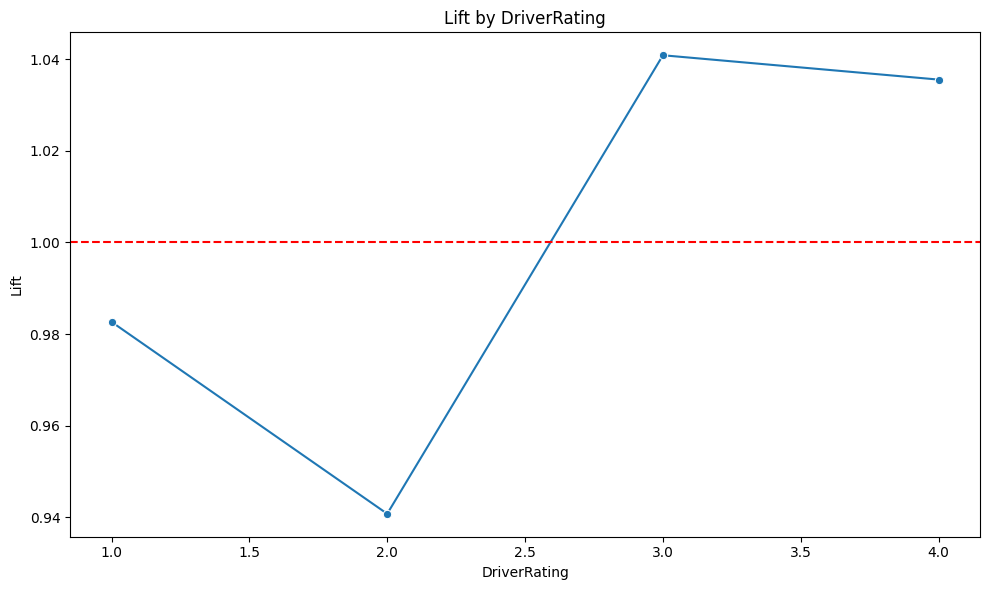

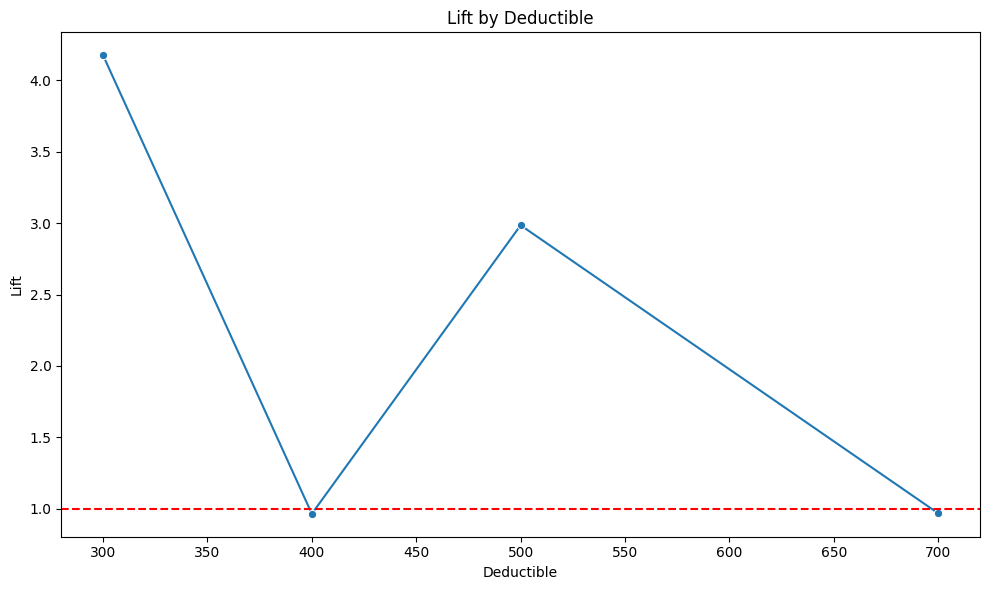

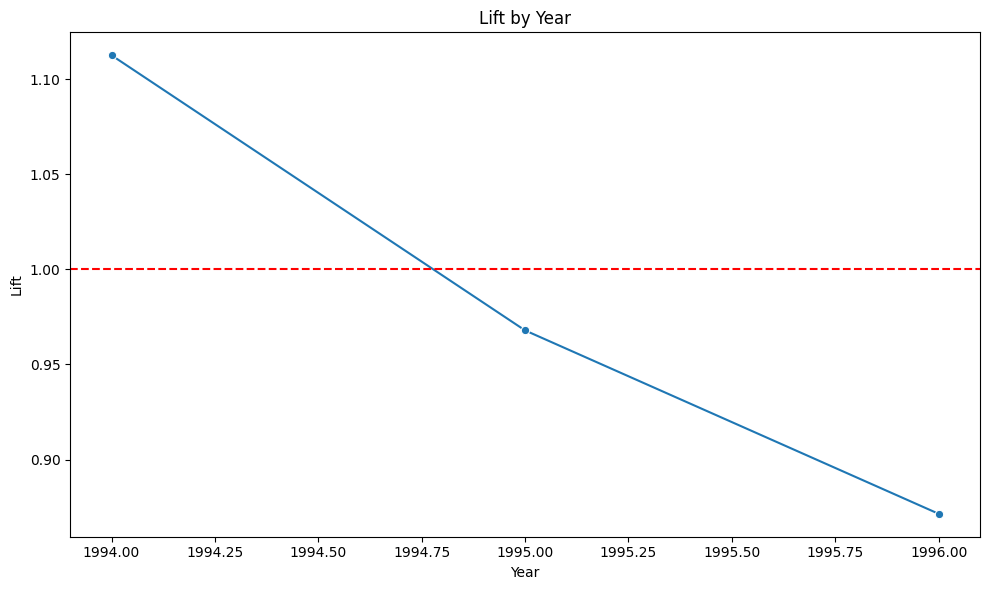

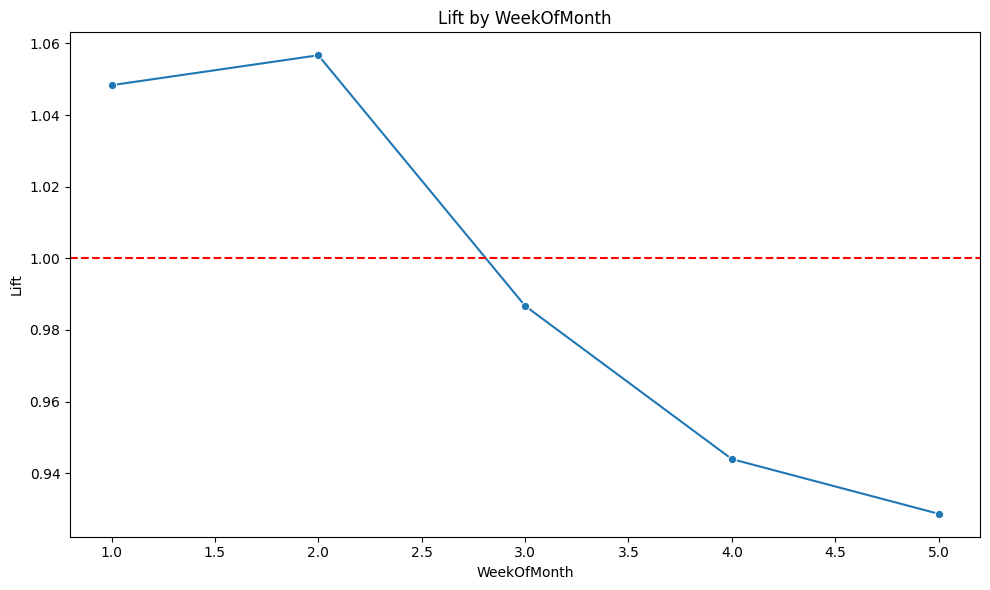

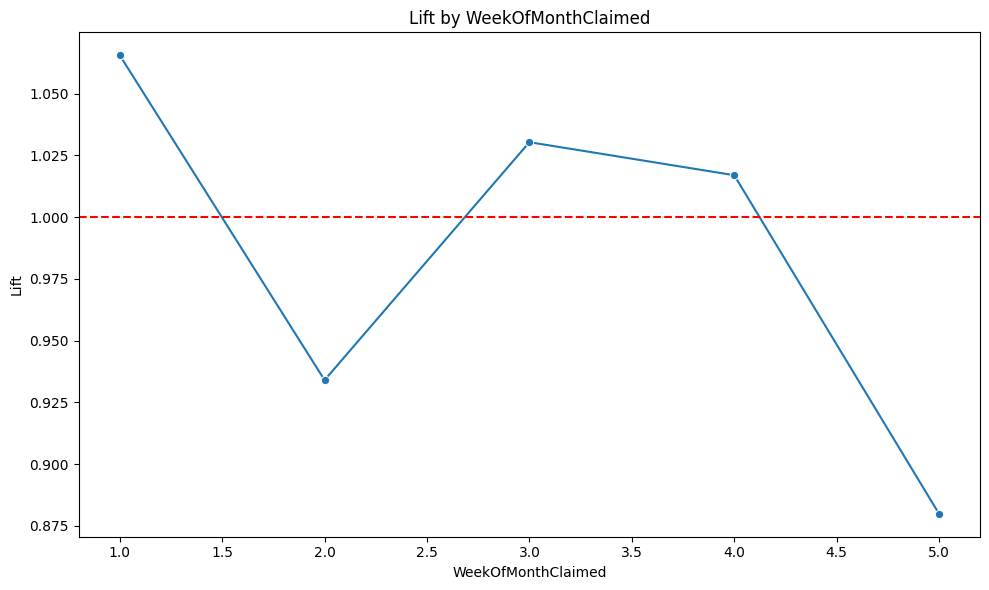

In [34]:
# create lift plots for specials
for feature in specials:
    g = df.groupby(feature)[target].agg(rate='mean', n='size')
    g['lift'] = (g['rate']/baseline).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    ax = sns.lineplot(data=g, x=feature, y='lift', marker='o', palette='crest')
    plt.axhline(1, color="red", linestyle="--")
    plt.title(f"Lift by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Lift")
    plt.tight_layout()
    plt.show()


Lift insights:

*  The visualizations are starting to tell a cohesive story.
*  Only a few features show increased likelihood of fraud when compared to the baseline (~6%).
*  AddressChange_Claim: the 'under 6 month' category is > 12x more likely to have fraud over the baseline.
*  Make: 'Mercedes' is > 4x more likely to have fraud over the baseline.
*  Deductible: the $300 and $500 categories are 3x and 4x more likely to have fraud over the baseline.
*  A few other features showed modest lift (between 2-3x) including Days_Policy_Claimed ('18 to 15'), Days_Policy_Accident ('none'), and AgeOfPolicyHolder ('18 to 25').


### Association analysis (with target) for categorical features

*  Cramer's V Coefficient (nominal features)
*  Spearman Correlation (ordinal/cyclic features)

In [35]:
nominal_cols

['Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'BasePolicy']

In [36]:
# define Cramér's V with bias correction
def cramers_v(x, y):
    """
    Compute Cramér's V with bias correction.
    """
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion, correction=False)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape

    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


In [37]:
# calculate cramers v for nominal features
#target = "FraudFound_P"
cramers_results = []

for col in nominal_cols:
    v = cramers_v(df[col], df[target])
    cramers_results.append({
        "feature": col,
        "cramers_v": v
    })

In [38]:
# store and sort the results
cramers_df = (pd.DataFrame(cramers_results).sort_values("cramers_v", ascending=False).reset_index(drop=True))
cramers_df

feature  cramers_v
0          PolicyType   0.166903
1          BasePolicy   0.161261
2     VehicleCategory   0.136905
3               Fault   0.131158
4                Make   0.052077
5        AccidentArea   0.032577
6                 Sex   0.028859
7           AgentType   0.021524
8   PoliceReportFiled   0.013838
9      WitnessPresent   0.000284
10      MaritalStatus   0.000000

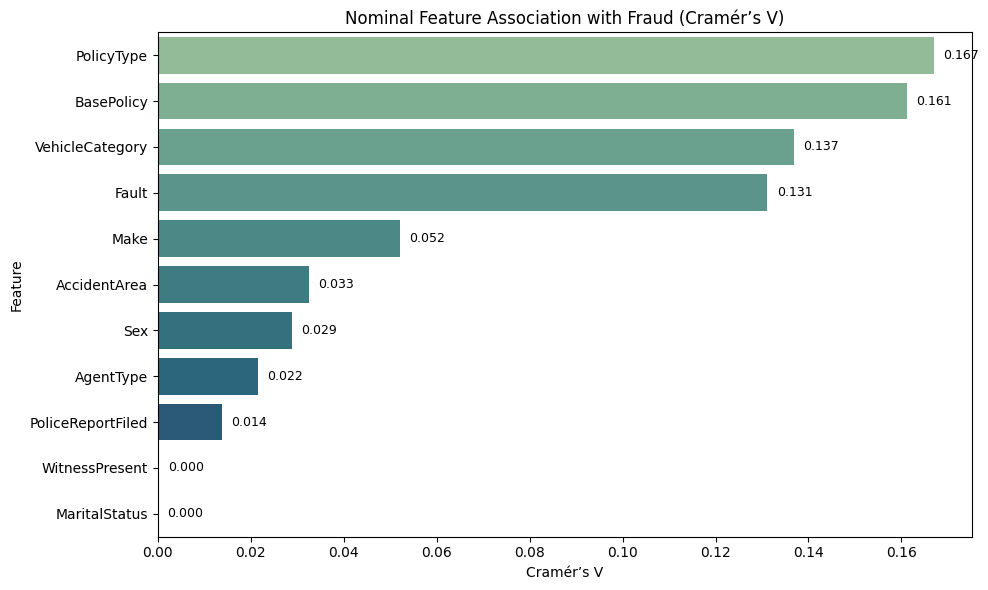

In [39]:
# create cramers V coefficient plots
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=cramers_df, x="cramers_v", y="feature", palette="crest")
plt.title("Nominal Feature Association with Fraud (Cramér’s V)")
plt.xlabel("Cramér’s V")
plt.ylabel("Feature")
for i, v in enumerate(cramers_df["cramers_v"]):
    ax.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

In [40]:
# list the ordinal columns
ordinal_cols

['VehiclePrice',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'DriverRating',
 'Deductible',
 'Year',
 'WeekOfMonth',
 'WeekOfMonthClaimed']

In [41]:
from scipy.stats import spearmanr

target = df["FraudFound_P"]

# ordinal: use codes
ordinal_results = []
for col in ordinal_cols:
    codes = df[col].cat.codes
    valid = codes != -1
    rho, p = spearmanr(codes[valid], target[valid])
    ordinal_results.append({"feature": col, "spearman_rho": rho, "p_value": p, "n_used": int(valid.sum())})

In [42]:
# map ordered categories -> 1.. so Jan=1 instead of 0
df["Month_num"] = df["Month"].cat.codes + 1
df["MonthClaimed_num"] = df["MonthClaimed"].cat.codes + 1
df["DayOfWeek_num"] = df["DayOfWeek"].cat.codes + 1
df["DayOfWeekClaimed_num"] = df["DayOfWeekClaimed"].cat.codes + 1

In [43]:
# define function that calculates sin/cos transformations
def add_cyclic(df, num_col, period):
    x = df[num_col].astype(float)
    df[f"{num_col}_sin"] = np.sin(2*np.pi*x/period)
    df[f"{num_col}_cos"] = np.cos(2*np.pi*x/period)

add_cyclic(df, "Month_num", 12)
add_cyclic(df, "MonthClaimed_num", 12)
add_cyclic(df, "DayOfWeek_num", 7)
add_cyclic(df, "DayOfWeekClaimed_num", 7)

In [44]:
# cyclic: use sin/cos numeric columns
cyclic_numeric_cols = [
    "Month_num_sin", "Month_num_cos",
    "MonthClaimed_num_sin", "MonthClaimed_num_cos",
    "DayOfWeek_num_sin", "DayOfWeek_num_cos",
    "DayOfWeekClaimed_num_sin", "DayOfWeekClaimed_num_cos"
]

In [45]:
# calculate spearman correlation for cyclic features
cyclic_results = []
for col in cyclic_numeric_cols:
    valid = df[col].notna() & target.notna()
    rho, p = spearmanr(df.loc[valid, col], target.loc[valid])
    cyclic_results.append({"feature": col, "spearman_rho": rho, "p_value": p, "n_used": int(valid.sum())})


In [46]:
# combine the cyclic and nominal spearman results
spearman_df = (
    pd.concat([pd.DataFrame(ordinal_results), pd.DataFrame(cyclic_results)], ignore_index=True)
      .sort_values("spearman_rho", key=lambda s: s.abs(), ascending=False))

spearman_df

feature  spearman_rho       p_value  n_used
3         PastNumberOfClaims     -0.057682  7.611348e-13   15419
10                Deductible      0.040902  3.762578e-07   15419
7        AddressChange_Claim      0.032967  4.232794e-05   15419
4               AgeOfVehicle     -0.032912  4.359162e-05   15419
6        NumberOfSuppliments     -0.031544  8.942307e-05   15419
5          AgeOfPolicyHolder     -0.028386  4.231339e-04   15419
11                      Year     -0.024902  1.985455e-03   15419
17      MonthClaimed_num_cos     -0.020353  1.149167e-02   15419
1       Days_Policy_Accident     -0.019948  1.324889e-02   15419
14             Month_num_sin      0.019924  1.335630e-02   15419
19         DayOfWeek_num_cos      0.017227  3.242886e-02   15419
2          Days_Policy_Claim     -0.017039  3.436371e-02   15419
16      MonthClaimed_num_sin      0.016640  3.881000e-02   15419
15             Month_num_cos     -0.014365  7.447783e-02   15419
18         DayOfWeek_num_sin     -0.013339  9.766749e-02   15419
0               VehiclePrice      0.012130  1.320182e-01   15419
12               WeekOfMonth     -0.011954  1.377137e-01   15419
8               NumberOfCars      0.007600  3.453562e-01   15419
9               DriverRating      0.007250  3.680270e-01   15419
20  DayOfWeekClaimed_num_sin     -0.006590  4.132005e-01   15419
13        WeekOfMonthClaimed     -0.005284  5.117319e-01   15419
21  DayOfWeekClaimed_num_cos     -0.000455  9.549838e-01   15419

In [47]:
# filter significant associations 
sig = (
    spearman_df
    .query("p_value < 0.05")
    .assign(p_value_round=lambda d: d["p_value"].round(4))
    .sort_values("p_value"))

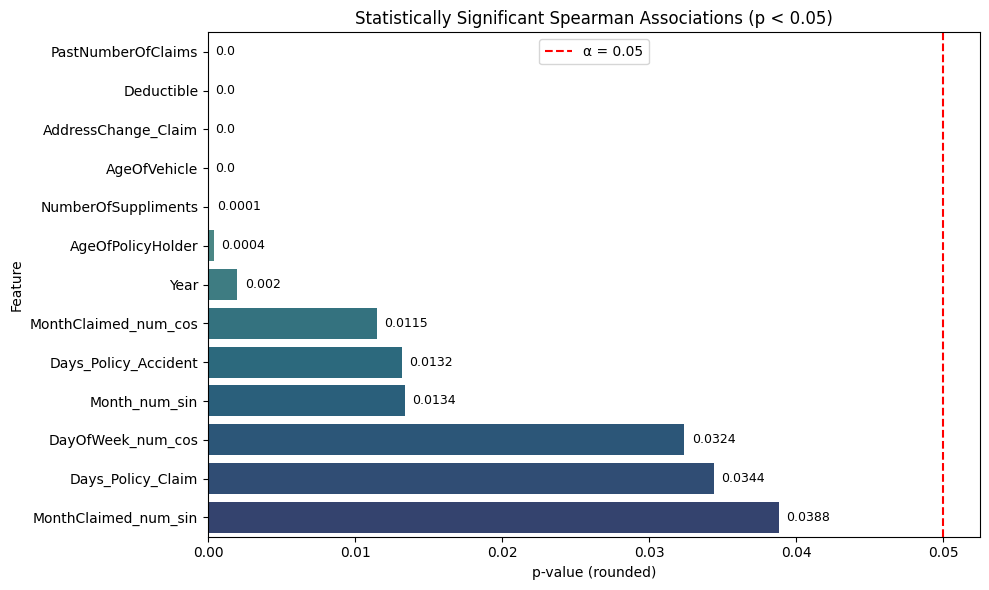

In [48]:
# plot significant associations
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sig["p_value_round"], y=sig["feature"], palette="crest")
plt.axvline(0.05, color="red", linestyle="--", label="α = 0.05")
plt.title("Statistically Significant Spearman Associations (p < 0.05)")
plt.xlabel("p-value (rounded)")
plt.ylabel("Feature")
for i, v in enumerate(sig["p_value_round"]):
    ax.text(v + 0.0005, i, f"{v}", va="center", fontsize=9)
plt.legend()
plt.tight_layout()
plt.show()

Association insights:

*  Most associations are relatively small, highlighting interactions between features.
*  Many of the features with higher associations were identified in previous sections of EDA, including:
    *  Cramer's V: PolicyType, BasePolicy, VehicleCategory, Fault, Make
    *  Spearman's Rho: Deductible, AddressChange_Claim, PastNumberOfClaims, AgeOfPolicyHolder

### Customer segmentation using KMeans

In [49]:
# select subset of predictive features (including cyclic)
X_seg = pd.DataFrame(index=df.index)
y_seg = target
cluster_ordinal_cols = [
    "PastNumberOfClaims",
    "NumberOfSuppliments",
    "VehiclePrice",
    "AgeOfPolicyHolder",
    "AddressChange_Claim",
    "DriverRating",
    "Deductible",
]

In [50]:
# ensure proprer types are used 
for col in cluster_ordinal_cols:
    if pd.api.types.is_categorical_dtype(df[col]):
        X_seg[col] = df[col].cat.codes.replace(-1, np.nan)
    else:
        X_seg[col] = pd.to_numeric(df[col], errors='coerce')

In [51]:
# add transformed cyclic features
X_seg[cyclic_numeric_cols] = df[cyclic_numeric_cols]

In [52]:
# scale cluster data
scaler = StandardScaler()
X_seg_scaled = scaler.fit_transform(X_seg)

In [53]:
# select KMeans optimal clusters
for c in [3,4,5]:
    labels = KMeans(n_clusters=c, random_state=42, n_init=10).fit_predict(X_seg_scaled)
    score = silhouette_score(X_seg_scaled, labels)
    print(f'Clusters: {c}, Silhouette Score: {score:.3f}')

Clusters: 3, Silhouette Score: 0.103
Clusters: 4, Silhouette Score: 0.111
Clusters: 5, Silhouette Score: 0.099


In [54]:
# fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_seg_scaled)
df.loc[X_seg.index, 'risk_cluster'] = clusters

In [55]:
# turn clusters into risk tiers
target_col = 'FraudFound_P'
cluster_risk = (df.loc[X_seg.index].groupby('risk_cluster')[target_col].mean().sort_values())

risk_map = {
    cluster_risk.index[0]: 'Low Risk',
    cluster_risk.index[1]: 'Medium Risk',   
    cluster_risk.index[2]: 'High Risk'  
}

df.loc[X_seg.index, "fraud_risk_tier"] = df.loc[X_seg.index, "risk_cluster"].map(risk_map)

In [56]:
# check fraud found means
df.groupby("fraud_risk_tier")[target_col].mean()

fraud_risk_tier
High Risk      0.062980
Low Risk       0.056642
Medium Risk    0.059699
Name: FraudFound_P, dtype: float64

In [57]:
# check risk tier proportions
df["fraud_risk_tier"].value_counts(normalize=True)

fraud_risk_tier
High Risk      0.346002
Medium Risk    0.335690
Low Risk       0.318309
Name: proportion, dtype: float64

In [58]:
# group by tier
risk_summary = (
    df.groupby("fraud_risk_tier")[target_col]
      .mean()
      .reindex(["Low Risk", "Medium Risk", "High Risk"])  
)

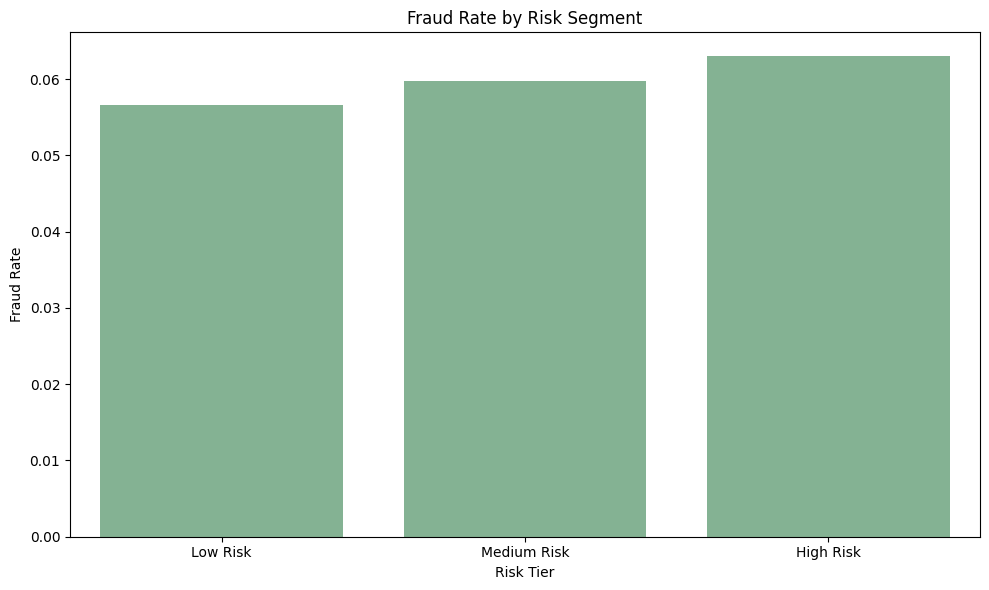

In [59]:
# plot risk clusters
sns.set_palette("crest")
plt.figure(figsize=(10,6))
sns.barplot(x=risk_summary.index, y=risk_summary.values)
plt.title("Fraud Rate by Risk Segment")
plt.ylabel("Fraud Rate")
plt.xlabel("Risk Tier")
plt.tight_layout()
plt.show()

Customer segmentation insights:

*  Since the silhouette scores were very similar, any of the three could be used.
*  KMeans showed modest differences in the observed fraud rate, with a narrow range of roughly 5.7% to 6.3%.
*  Minimal seperation suggests the risk is spread broadly across the customer base.
*  Predictive modeling will better capture subtle and interacting signals.

### Exploratory Data Analysis Summary

## Experimental Design:

A three-way split was made on the data, resulting in distinct training, validation, and test sets. Feature selection was evaluated using RFE cross-validated model performance.

Note: **All transformations are fit on training folds only via pipelines to avoid leakage.**

In addition to experimental feature selection, experimental model selection was also employed to select a model for this binary classification task. Models that were explored include:

*  Logistic Regression
*  Support Vector Machine
*  Random Forest
*  Gradient Boosting
*  AdaBoost
*  Neural Network

Though tree-based models work very well for binary classification (and many other types of tasks), simpler models were the starting point to gauge complexity of the task. A simple MLP was also included for good measure.

### Train/validation/test split:

*  Train (~80%): model fitting + CV

*  Val (~10%): selection + tuning verification

*  Test (10%): one-time evaluation 

In [ ]:
# review df
df.head()

Month WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec           5  Wednesday   Honda        Urban          Tuesday   
1   Jan           3  Wednesday   Honda        Urban           Monday   
2   Oct           5     Friday   Honda        Urban         Thursday   
3   Jun           2   Saturday  Toyota        Rural           Friday   
4   Jan           5     Monday   Honda        Urban          Tuesday   

  MonthClaimed WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                  1  Female        Single   21  Policy Holder   
1          Jan                  4    Male        Single   34  Policy Holder   
2          Nov                  2    Male       Married   47  Policy Holder   
3          Jul                  1    Male       Married   65    Third Party   
4          Feb                  2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

  Deductible DriverRating Days_Policy_Accident Days_Policy_Claim  \
0        300            1         more than 30      more than 30   
1        400            4         more than 30      more than 30   
2        400            3         more than 30      more than 30   
3        400            2         more than 30      more than 30   
4        400            1         more than 30      more than 30   

  PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder PoliceReportFiled  \
0               none      3 years          26 to 30                No   
1               none      6 years          31 to 35               Yes   
2                  1      7 years          41 to 50                No   
3                  1  more than 7          51 to 65               Yes   
4               none      5 years          31 to 35                No   

  WitnessPresent AgentType NumberOfSuppliments AddressChange_Claim  \
0             No  External                none              1 year   
1             No  External                none           no change   
2             No  External                none           no change   
3             No  External         more than 5           no change   
4             No  External                none           no change   

  NumberOfCars  Year BasePolicy  Month_num  MonthClaimed_num  DayOfWeek_num  \
0       3 to 4  1994  Liability         12                 1              3   
1    1 vehicle  1994  Collision          1                 1              3   
2    1 vehicle  1994  Collision         10                11              5   
3    1 vehicle  1994  Liability          6                 7              6   
4    1 vehicle  1994  Collision          1                 2              1   

   DayOfWeekClaimed_num  Month_num_sin  Month_num_cos  MonthClaimed_num_sin  \
0                     2  -2.449294e-16       1.000000              0.500000   
1                     1   5.000000e-01       0.866025              0.500000   
2                     4  -8.660254e-01       0.500000             -0.500000   
3                     5   1.224647e-16      -1.000000             -0.500000   
4                     2   5.000000e-01       0.866025              0.866025   

   MonthClaimed_num_cos  DayOfWeek_num_sin  DayOfWeek_num_cos  \
0              0.866025           0.433884          -0.900969   
1              0.866025           0.433884          -0.900969   
2              0.866025          -0.974928          -0.222521   
3             -0.866025          -0.781831           0.623490   
4              0.500000           0.781831           0.623490   

   DayOfWeekClaimed_num_sin  DayOfWeekClaimed_num_cos  ri

In [ ]:
# separate target from features
X = df.drop(columns=['FraudFound_P', 'risk_cluster', 'fraud_risk_tier'])
y = df['FraudFound_P']

# create train/val/test splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, random_state=42, stratify=y_temp)
print(f'Shape of train set: {X_train.shape}')
print(f'Shape of val set: {X_val.shape}')
print(f'Shape of test set: {X_test.shape}')

Shape of train set: (12489, 42)
Shape of val set: (1388, 42)
Shape of test set: (1542, 42)


In [61]:
# ensure features are grouped by type
print(nominal_cols)
print(ordinal_cols)
print(cyclic_numeric_cols)

['Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy']
['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'DriverRating', 'Deductible', 'Year', 'WeekOfMonth', 'WeekOfMonthClaimed']
['Month_num_sin', 'Month_num_cos', 'MonthClaimed_num_sin', 'MonthClaimed_num_cos', 'DayOfWeek_num_sin', 'DayOfWeek_num_cos', 'DayOfWeekClaimed_num_sin', 'DayOfWeekClaimed_num_cos']


### Feature Preprocessing:

Based on previous analysis, several transformations are needed , including:
*  OHE for categorical features (numeric conversion): gender, region, device, payment_method, favorite_genre, last_login_days(bin)
*  Scaling of numerical features for linear models: age, monthly_fee, number_of_profiles, watch_hours(log) , avg_watch_time_per_day(log)

In [67]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

In [68]:
# create numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [69]:
# create ordinal transformer
ordinal_categories = [ordinal_order_map[col] for col in ordinal_cols]
ordinal_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

In [70]:
# create nominal transformer
nominal_transformer = Pipeline(steps=[('oh_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [71]:
# create the preprocessor column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cyclic_numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [73]:
# instantiate a base estimator for RFE
base_lr_estimator = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', solver='saga', n_jobs=-1)

In [74]:
# instantiate RFE and it's pipeline
rfe = RFE(estimator=base_lr_estimator, n_features_to_select=50, step=0.05)

rfe_weighted_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfe', rfe),
    ('model', base_lr_estimator)
])

In [76]:
# use cross validation to determine the signal strength of the selected features
scores = cross_val_score(rfe_weighted_pipe, X_train, y_train, cv=5, scoring='average_precision', n_jobs=-1)
print(f'PR-AUC scores: {np.round(scores, 4)}')
print(f'The signal strength of the selected features: {scores.mean():.4f} ± {scores.std():.4f}')

PR-AUC scores: [0.1572 0.154  0.1713 0.1408 0.1698]
The signal strength of the selected features: 0.1586 ± 0.0112


In [77]:
# check baseline prevelance
print("Baseline prevalence:", y_train.mean().round(4))

Baseline prevalence: 0.0599


In [79]:
# retrieve selected RFE featuers
rfe_weighted_pipe.fit(X_train, y_train)

feature_names = rfe_weighted_pipe.named_steps["preprocessor"].get_feature_names_out()
selected_mask = rfe_weighted_pipe.named_steps["rfe"].support_
selected_features = feature_names[selected_mask]

selected_features[:30], len(selected_features)


(array(['Month_num_sin', 'Month_num_cos', 'MonthClaimed_num_sin',
        'MonthClaimed_num_cos', 'DayOfWeek_num_cos',
        'Days_Policy_Accident', 'AgeOfPolicyHolder', 'AddressChange_Claim',
        'Deductible', 'Make_Accura', 'Make_BMW', 'Make_Chevrolet',
        'Make_Dodge', 'Make_Ferrari', 'Make_Ford', 'Make_Honda',
        'Make_Jaguar', 'Make_Mazda', 'Make_Mecedes', 'Make_Mercury',
        'Make_Nisson', 'Make_Pontiac', 'Make_Porche', 'Make_Saab',
        'Make_Saturn', 'Make_Toyota', 'Make_VW', 'AccidentArea_Urban',
        'Sex_Female', 'MaritalStatus_Divorced'], dtype=object),
 50)

### Model Selection:

*  Multiple model families were evaluated using **cross-validation** and **multiple metrics** (ROC-AUC, recall, F1, accuracy). 

*  **Recall** was emphasized during tuning to prioritize identifying at-risk customers, reflecting a retention-focused use case.

*  **AdaBoost** provided the best balance of performance and stability after hyperparameter tuning and was selected as the final model. 

*  Final evaluation was conducted on a held-out test set to avoid optimistic bias.


### Metric Selection

Model evaluation prioritized recall and precision–recall tradeoffs rather than accuracy, given the highly imbalanced nature of insurance fraud data. In a fraud detection context, the costs associated with misclassification are asymmetric and require careful consideration.

From a business perspective:

- A **false negative** (failing to flag a fraudulent claim) results in direct financial loss, as illegitimate claims are paid and may propagate repeat fraud.
- A **false positive** (flagging a legitimate claim as fraud) introduces investigative and operational costs, and may negatively impact customer experience, but does not directly result in immediate financial loss.

During model selection, PR-AUC was used as the primary comparison metric to evaluate each model’s ability to rank fraudulent claims ahead of legitimate ones under severe class imbalance. Recall and precision were monitored jointly to assess the tradeoff between fraud capture and investigation burden.

While no single operating threshold was optimized at this stage, the results inform downstream threshold tuning, where decision cutoffs can be aligned with specific business risk tolerances and investigation capacity.

Instantiating and evaluating base model performance

In [85]:
# models
models = {'Logistic Regression': LogisticRegression(random_state=5, max_iter=1000),
          'Support Vector Machine': SVC(random_state=5, probability=True),
          'Random Forest': RandomForestClassifier(random_state=5),
          'Gradient Boosting': GradientBoostingClassifier(random_state=5),
          'AdaBoost': AdaBoostClassifier(random_state=5,n_estimators=100),
          'XGBoost': xgb.XGBClassifier(random_state=5, use_label_encoder=False, objective="binary:logistic", eval_metric='logloss'),
          'Neural Network': MLPClassifier(random_state=5, max_iter=1000)}

In [ ]:
# get baseline performance for each model using the selected feature set
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision", "f1": "f1", "precision": "precision", "recall": "recall"}
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

    # print out the name of each model and each of its scores with its name
    print(f'{name}: roc_auc: {scores["test_roc_auc"].mean():.3f}, pr_auc: {scores["test_pr_auc"].mean():.3f}, f1: {scores["test_f1"].mean():.3f}, precision: {scores["test_precision"].mean():.3f}, recall: {scores["test_recall"].mean():.3f}\n')

Logistic Regression: roc_auc: 0.798, pr_auc: 0.167, f1: 0.000, precision: 0.000, recall: 0.000

Support Vector Machine: roc_auc: 0.770, pr_auc: 0.185, f1: 0.000, precision: 0.000, recall: 0.000

Random Forest: roc_auc: 0.824, pr_auc: 0.226, f1: 0.021, precision: 0.600, recall: 0.011

Gradient Boosting: roc_auc: 0.841, pr_auc: 0.246, f1: 0.071, precision: 0.803, recall: 0.037

AdaBoost: roc_auc: 0.799, pr_auc: 0.158, f1: 0.015, precision: 0.137, recall: 0.008

XGBoost: roc_auc: 0.848, pr_auc: 0.252, f1: 0.144, precision: 0.353, recall: 0.091

Neural Network: roc_auc: 0.786, pr_auc: 0.175, f1: 0.183, precision: 0.210, recall: 0.163



Based on the PR-AUC score, the XGBoost model has been identified as the best performing model.

In [88]:
# create pipeline for best model (XGBoost)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(random_state=5, tree_method="hist", objective="binary:logistic", eval_metric='logloss', scale_pos_weight=neg_pos_ratio, n_jobs=-1))
])

In [90]:
# create params
params = {
    "model__n_estimators": [300, 450,600],
    "model__learning_rate": [0.03, 0.05, 0.10],
    "model__max_depth": [3, 5, 7],
    "model__min_child_weight": [1, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

# instantiate gridsearch
grid = GridSearchCV(xgb_pipe, param_grid=params, cv=5, scoring="average_precision", n_jobs=-1, refit=True, verbose=1) 

# fit gridsearch
grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Month_num_sin',
                                                                          'Month_num_cos',
                                                                          'MonthClaimed_num_sin',
                                                                          'MonthClaimed_num_cos',
                                                                          'DayOfWeek_num_sin',
                                                                          'DayOfWeek_num_cos',
                                                                          'DayOfWeekClaimed_num_sin',
                                                                          'DayOfWeekClaimed_num_cos']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ordin...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.03, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__min_child_weight': [1, 5],
                         'model__n_estimators': [300, 450, 600],
                         'model__subsample': [0.8, 1.0]},
             scoring='average_precision', verbose=1)

In [91]:
# get the params and recall score of the best model
best_pipe = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV recall:", grid.best_score_)

Best params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV recall: 0.2843211576004195


In [ ]:
# get train predictions so they can be compared to validation to check for overfitting
y_train_pred = best_pipe.predict(X_train)
print('TRAINING SET PERFORMANCE')
print(f'Classification Report: {classification_report(y_train, y_train_pred)}')

# get probabilities for ROC and PR curves
y_train_proba = best_pipe.predict_proba(X_train)[:, 1]
print("TRAIN PR-AUC:", average_precision_score(y_train, y_train_proba))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, y_train_proba))

TRAINING SET Performance
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.79      0.88     11741
           1       0.23      0.98      0.37       748

    accuracy                           0.80     12489
   macro avg       0.61      0.89      0.63     12489
weighted avg       0.95      0.80      0.85     12489

TRAIN PR-AUC: 0.636781786839467
TRAIN ROC-AUC: 0.96208752682109


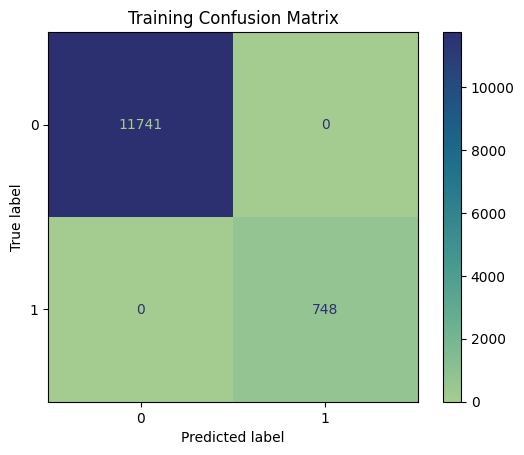

In [96]:
# create training confusion matrix
train_cm = confusion_matrix(y_train, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=best_pipe.classes_)
disp.plot(cmap='crest')
plt.title('Training Confusion Matrix')
plt.show()

In [98]:
# evaluate best model on validation set
y_val_pred = best_pipe.predict(X_val)
print('VALIDATION SET PERFORMANCE')
print(f'Classification Report: {classification_report(y_val, y_val_pred, digits=4)}')

# get probabilities for ROC and PR curves
y_val_proba = best_pipe.predict_proba(X_val)[:, 1]
val_baseline = y_val.mean()
print("Validation prevalence (baseline):", round(val_baseline, 4))
print("VAL PR-AUC:", average_precision_score(y_val, y_val_proba))
print("VAL ROC-AUC:", roc_auc_score(y_val, y_val_proba))

VALIDATION SET PERFORMANCE
Classification Report:               precision    recall  f1-score   support

           0     0.9863    0.7747    0.8678      1305
           1     0.1901    0.8313    0.3094        83

    accuracy                         0.7781      1388
   macro avg     0.5882    0.8030    0.5886      1388
weighted avg     0.9387    0.7781    0.8344      1388

Validation prevalence (baseline): 0.0598
VAL PR-AUC: 0.3285838580741856
VAL ROC-AUC: 0.8651156349536075


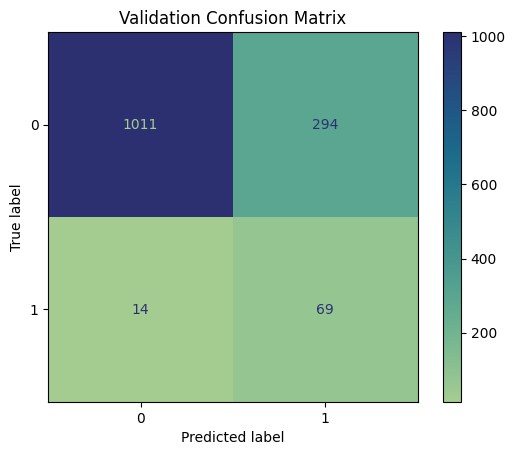

In [94]:
# create validation confusion matrix
v_cm = confusion_matrix(y_val, y_val_pred, labels=best_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=v_cm, display_labels=best_pipe.classes_)
disp.plot(cmap='crest')
plt.title('Validation Confusion Matrix')
plt.show()

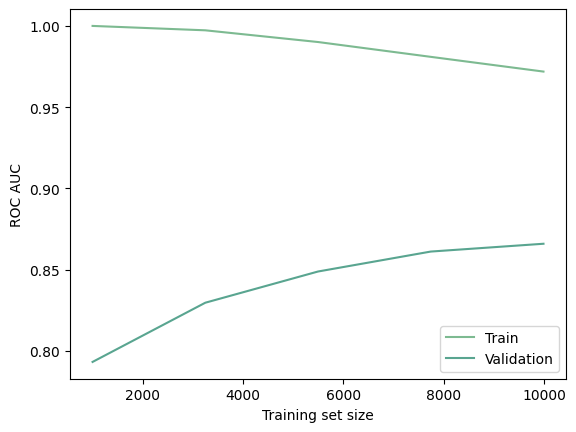

In [ ]:
# plot the learning curves for the xgboost model
train_sizes, train_scores, val_scores = learning_curve(estimator=best_pipe, X=X_train, y=y_train, cv=5, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.xlabel("Training set size")
plt.ylabel("ROC AUC")
plt.legend()
plt.show()